In [60]:
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import seaborn as sns
from sklearn.metrics import average_precision_score, confusion_matrix, brier_score_loss, matthews_corrcoef
import sys
sys.path.append('../')
from src.utils.metrics.true_skill_statistic import vectorized_true_skill_statistic

%matplotlib inline

In [61]:
colors = {
    "yellow": "#EBB53D",
    "green": "#3B916D",
    "orange": "#DE8945",
    "blue": "#39909E",
    "red": "#EB4336",
    "black": "#231F20",
    "beige": "#EFEADF",
    "leafgreen": "#8CA530",
    "softmint": "#C3D9BF"
}

cm_to_inch = 1/2.54

onecolumn = 8.8 * cm_to_inch
twocolumn = 17.6 * cm_to_inch
onehalfcolumn = 13.2 * cm_to_inch

# Three row figure
# Set font to FiraCode NF (can remove if you don't have the font, not essential)
plt.rcParams["font.family"] = "Fira Code"

# Set all base black colors to my colors["black"]
plt.rcParams["text.color"] = colors["black"]
plt.rcParams["axes.labelcolor"] = colors["black"]
plt.rcParams["xtick.color"] = colors["black"]
plt.rcParams["ytick.color"] = colors["black"]
plt.rcParams["axes.edgecolor"] = colors["black"]


In [6]:
import matplotlib.font_manager as fm

import matplotlib.font_manager as fm, matplotlib.pyplot as plt
# point to any one of the Fira files that Fontconfig lists
fm.fontManager.addfont("/run/host/user-fonts/firacode/FiraCode-Regular.ttf")
fm._load_fontmanager(try_read_cache=False)   # refresh the manager

# Splits characterization table

In [9]:
# Connect to the features database
sdb_path = "../data/features.db"
sconn = sqlite3.connect(sdb_path)
scur = sconn.cursor()

# List all tables for reference
scur.execute("SELECT name FROM sqlite_master WHERE type='table';")

In [10]:
table = "T_24_L_24_S_0_2_B_0_OVERLAPS_1_MIN_FLARE_30_dataset"

In [11]:
# IMPORTANT IS_ACTIVE REFERS TO WHETHER A REGION PRODUCES ANY KIND OF FLARE, NOT ONLY >M. IS_CME_ACTIVE THE SAME, ANY KIND OF CME.
data = pd.read_sql(f"""
SELECT 
  split,
  COUNT(DISTINCT harpnum) AS n_unique_harpnum,
  COUNT(*) AS n_examples,
  SUM(CASE WHEN has_flare_above_threshold = 1 THEN 1 ELSE 0 END) AS n_flare_above_threshold_examples,
  SUM(CASE WHEN has_flare_below_threshold = 1 THEN 1 ELSE 0 END) AS n_flare_below_threshold_examples,
  SUM(CASE WHEN has_cme_flare_above_threshold = 1 THEN 1 ELSE 0 END) AS n_cme_flare_above_threshold_examples,
  SUM(CASE WHEN has_cme_flare_below_threshold = 1 THEN 1 ELSE 0 END) AS n_cme_flare_below_threshold_examples,
  SUM(CASE WHEN has_cme_no_flare = 1 THEN 1 ELSE 0 END) AS n_cme_no_flare_examples,
  COUNT(DISTINCT CASE WHEN has_flare_above_threshold = 1 THEN harpnum END) AS n_unique_harpnum_flare_above_threshold,
  COUNT(DISTINCT CASE WHEN has_flare_below_threshold = 1 THEN harpnum END) AS n_unique_harpnum_flare_below_threshold,
  COUNT(DISTINCT CASE WHEN has_cme_flare_above_threshold = 1 THEN harpnum END) AS n_unique_harpnum_cme_flare_above_threshold,
  COUNT(DISTINCT CASE WHEN has_cme_flare_below_threshold = 1 THEN harpnum END) AS n_unique_harpnum_cme_flare_below_threshold,
  COUNT(DISTINCT CASE WHEN has_cme_no_flare = 1 THEN harpnum END) AS n_unique_harpnum_cme_no_flare,
  COUNT(DISTINCT CASE WHEN is_flare_active = 1 THEN harpnum END) AS n_unique_harpnum_flare_active,
  COUNT(DISTINCT CASE WHEN is_flare_active = 0 THEN harpnum END) AS n_unique_harpnum_no_flare_active,
  COUNT(DISTINCT CASE WHEN is_cme_active = 1 THEN harpnum END) AS n_unique_harpnum_cme_active,
  COUNT(DISTINCT CASE WHEN has_cme_flare_above_threshold = 1 OR has_cme_flare_below_threshold = 1 OR has_cme_no_flare = 1 THEN harpnum END) AS n_unique_harpnum_cme,
  COUNT(DISTINCT CASE WHEN is_cme_active = 0 THEN harpnum END) AS n_unique_harpnum_no_cme_active,
  COUNT(DISTINCT flare_above_threshold_id) AS n_unique_flare_above_threshold,
  COUNT(DISTINCT flare_below_threshold_id) AS n_unique_flare_below_threshold,
  COUNT(DISTINCT cme_flare_above_threshold_id) AS n_unique_cme_flare_above_threshold,
  COUNT(DISTINCT cme_flare_below_threshold_id) AS n_unique_cme_flare_below_threshold,
  COUNT(DISTINCT cme_no_flare_id) AS n_unique_cme_no_flare
FROM (
  SELECT 
    d.*,
    s.split,
    s.is_active as is_flare_active,
    s.is_cme_active as is_cme_active
  FROM {table} d
  INNER JOIN {table}_splits s
  ON d.harpnum = s.harpnum
) AS subquery
GROUP BY split;
""", sconn)

data["n_cme_examples"] = data["n_cme_flare_above_threshold_examples"] + data["n_cme_flare_below_threshold_examples"] + data["n_cme_no_flare_examples"]
data["n_unique_cme"] = data["n_unique_cme_flare_above_threshold"] + data["n_unique_cme_flare_below_threshold"] + data["n_unique_cme_no_flare"]
data["n_unique_harpnum_cme"] = data["n_unique_harpnum_cme_flare_above_threshold"] + data["n_unique_harpnum_cme_flare_below_threshold"]

data

,split,n_unique_harpnum,n_examples,n_flare_above_threshold_examples,n_flare_below_threshold_examples,n_cme_flare_above_threshold_examples,n_cme_flare_below_threshold_examples,n_cme_no_flare_examples,n_unique_harpnum_flare_above_threshold,n_unique_harpnum_flare_below_threshold,...,n_unique_harpnum_cme_active,n_unique_harpnum_cme,n_unique_harpnum_no_cme_active,n_unique_flare_above_threshold,n_unique_flare_below_threshold,n_unique_cme_flare_above_threshold,n_unique_cme_flare_below_threshold,n_unique_cme_no_flare,n_cme_examples,n_unique_cme
0,0,282,155633,3253,32781,878,3998,1670,20,78,...,39,34,243,46,861,10,46,17,6546,73
1,1,291,164884,2918,34601,945,4415,1644,15,91,...,53,49,238,38,814,12,45,16,7004,73
2,2,296,168647,3743,29689,1146,4430,1282,18,82,...,38,37,258,45,677,12,49,12,6858,73
3,3,332,180130,2720,29872,1089,3482,1139,18,93,...,39,38,293,46,690,13,47,13,5710,73
4,4,270,144572,2982,24022,902,3820,1108,18,60,...,35,35,235,46,580,14,49,15,5830,78
5,5,297,155974,2864,30522,977,3665,1714,14,77,...,39,32,258,46,735,14,43,21,6356,78
6,6,283,143383,2934,23405,927,4021,1549,12,59,...,32,28,251,46,532,14,47,17,6497,78
7,7,291,146299,2666,22239,1020,3406,2508,4,71,...,36,26,255,54,498,14,44,24,6934,82
8,8,267,141734,3427,22823,1501,3720,1590,16,61,...,37,32,230,46,510,16,45,17,6811,78
9,9,272,156722,3395,26830,1185,3962,1104,13,79,...,40,36,232,54,627,16,50,13,6251,79


In [12]:
# Table with the total number of events per type (flare, cme, flare_cme)

n_events_data = pd.read_sql(f"""
SELECT 
  COUNT(DISTINCT flare_above_threshold_id) AS n_flare_above_threshold,
  COUNT(DISTINCT cme_flare_above_threshold_id) + COUNT(DISTINCT cme_flare_below_threshold_id) AS n_cme,
  COUNT(DISTINCT cme_flare_above_threshold_id) AS n_cme_flare_above_threshold,
  (SELECT COUNT(DISTINCT harpnum) FROM {table} WHERE has_flare_above_threshold = 1) AS n_flare_active,
  (SELECT COUNT(DISTINCT harpnum) FROM {table} WHERE has_cme_flare_above_threshold = 1 OR has_cme_flare_below_threshold = 1 OR has_cme_no_flare = 1) AS n_cme_active,
  (SELECT COUNT(DISTINCT harpnum) FROM {table} WHERE has_cme_flare_above_threshold = 1) AS n_cme_flare_active,
  (SELECT COUNT(DISTINCT harpnum) FROM {table}) AS n_unique_harpnum_flare,
  (SELECT COUNT(DISTINCT harpnum) FROM {table}) AS n_unique_harpnum_cme,
  (SELECT COUNT(DISTINCT harpnum) FROM {table} WHERE has_flare_above_threshold = 1) AS n_unique_harpnum_cme_flare
  FROM {table}
  """, sconn
)

# Now let's format nicely into a table that has columns "Event", "N. Unique Events", "N. Event Active regions", "Total number of regions"

n_flare_above_threshold = n_events_data["n_flare_above_threshold"].values[0]
n_cme = n_events_data["n_cme"].values[0]
n_cme_flare_above_threshold = n_events_data["n_cme_flare_above_threshold"].values[0]
n_flare_active = n_events_data["n_flare_active"].values[0]
n_cme_active = n_events_data["n_cme_active"].values[0]
n_cme_flare_active = n_events_data["n_cme_flare_active"].values[0]
n_unique_harpnum_flare = n_events_data["n_unique_harpnum_flare"].values[0]
n_unique_harpnum_cme = n_events_data["n_unique_harpnum_cme"].values[0]
n_unique_harpnum_cme_flare = n_events_data["n_unique_harpnum_cme_flare"].values[0]

n_events_final_table = pd.DataFrame({
    "Event": ["Flare $>M$", "CME", "CME + Flare $>M$"],
    "N. Unique Events": [n_flare_above_threshold, n_cme, n_cme_flare_above_threshold],
    "N. Event Active regions": [n_flare_active, n_cme_active, n_cme_flare_active],
    "Total number of regions": [n_unique_harpnum_flare, n_unique_harpnum_cme, n_unique_harpnum_cme_flare]
})

# Save to latex
n_events_final_table.to_latex("./flare_cme_event_table.tex", index=False)

n_events_final_table

,Event,N. Unique Events,N. Event Active regions,Total number of regions
0,Flare $>M$,467,148,2881
1,CME,600,388,2881
2,CME + Flare $>M$,135,69,148


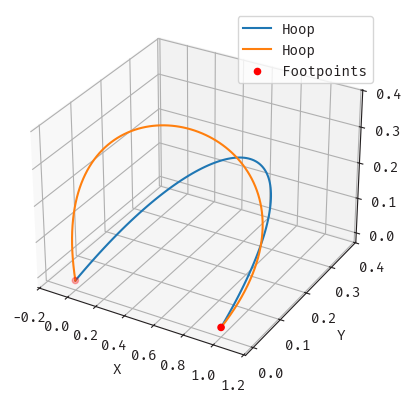

In [13]:
import numpy as np
import matplotlib.pyplot as plt

def cubic_bezier_hoop(p0, p1, height=0.5, curvature=1, skew=0.0, n_points=100):
    """
    Parametrize a curved hoop between p0 and p1 using a cubic Bézier curve.

    Parameters:
    - p0, p1: (3,) array-like footpoints
    - height: float, elevation above midpoint
    - curvature: float in [0,1], controls how flat or curved the arch is
    - skew: float, lateral offset of the apex
    - n_points: number of points to sample

    Returns:
    - (n_points, 3) numpy array of the hoop curve
    """
    p0 = np.array(p0)
    p1 = np.array(p1)
    d = p1 - p0
    m = (p0 + p1) / 2

    # Default upward vector, adjust if d is vertical
    up = np.array([0, 0, 1])
    n = np.cross(up, d)
    if np.linalg.norm(n) < 1e-6:
        n = np.cross(np.array([1, 0, 0]), d)
    n = n / np.linalg.norm(n)

    # Create a lateral direction perpendicular to both d and n (for skew)
    lat = np.cross(d, n)
    lat = lat / np.linalg.norm(lat)

    # Control points
    c1 = p0 + curvature * (p1 - p0) / 3 + height * n + skew * lat
    c2 = p1 - curvature * (p1 - p0) / 3 + height * n + skew * lat

    # Evaluate Bézier curve
    t = np.linspace(0, 1, n_points).reshape(-1, 1)
    curve = (
        (1 - t) ** 3 * p0 +
        3 * (1 - t) ** 2 * t * c1 +
        3 * (1 - t) * t ** 2 * c2 +
        t ** 3 * p1
    )

    return curve

# Example
p0 = [0, 0, 0]
p1 = [1, 0, 0]
curve = cubic_bezier_hoop(p0, p1, height=0.5, curvature=0.3, skew=0.2)
curve2 = cubic_bezier_hoop(p0, p1, height=0.2, curvature=-2, skew=0.5)

# Plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot(curve[:,0], curve[:,1], curve[:,2], label='Hoop')
ax.plot(curve2[:,0], curve2[:,1], curve2[:,2], label='Hoop')
ax.scatter(*zip(p0, p1), color='red', label='Footpoints')
ax.legend()
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.show()


findfont: Font family 'FiraCode Nerd Font' not found.
findfont: Font family 'FiraCode Nerd Font' not found.
findfont: Font family 'FiraCode Nerd Font' not found.
findfont: Font family 'FiraCode Nerd Font' not found.
findfont: Font family 'FiraCode Nerd Font' not found.
findfont: Font family 'FiraCode Nerd Font' not found.
findfont: Font family 'FiraCode Nerd Font' not found.
findfont: Font family 'FiraCode Nerd Font' not found.
findfont: Font family 'FiraCode Nerd Font' not found.
findfont: Font family 'FiraCode Nerd Font' not found.
findfont: Font family 'FiraCode Nerd Font' not found.
findfont: Font family 'FiraCode Nerd Font' not found.
findfont: Font family 'FiraCode Nerd Font' not found.
findfont: Font family 'FiraCode Nerd Font' not found.
findfont: Font family 'FiraCode Nerd Font' not found.
findfont: Font family 'FiraCode Nerd Font' not found.
findfont: Font family 'FiraCode Nerd Font' not found.
findfont: Font family 'FiraCode Nerd Font' not found.
findfont: Font family 'FiraC

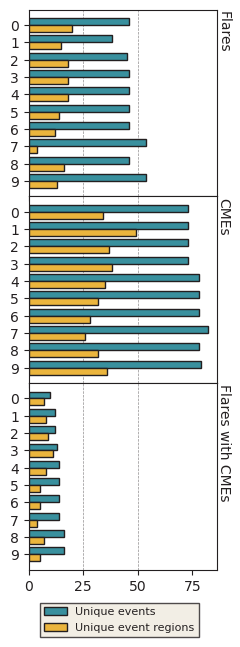

In [ ]:
# Three row figure
# Set font to FiraCode NF

# Set all base black colors to my colors["black"]
plt.rcParams["text.color"] = colors["black"]
plt.rcParams["axes.labelcolor"] = colors["black"]
plt.rcParams["xtick.color"] = colors["black"]
plt.rcParams["ytick.color"] = colors["black"]
plt.rcParams["axes.edgecolor"] = colors["black"]

fig, axes = plt.subplots(3, 1, figsize=(0.7 * onecolumn, 2.1 * onecolumn), sharex=True)

# Remove vertical space between subplots
plt.subplots_adjust(hspace=0)

for ax in axes:
    # Set y ticks to 1 to 10 with step 1
    ax.set_yticks(np.arange(0, 10, 1))

column_names = (
("n_unique_flare_above_threshold", "n_unique_harpnum_flare_above_threshold"),
("n_unique_cme", "n_unique_harpnum_cme"),
("n_unique_cme_flare_above_threshold", "n_unique_harpnum_cme_flare_above_threshold")
)
fig_names = ("Flares", "CMEs", "Flares with CMEs")

for i in range(3):
    ax = axes[i]

    ax.set_title(fig_names[i], fontsize=10, rotation=-90,ha='left', va='top', y=0.95, x=1)

    # Invert y-axis
    ax.invert_yaxis()

    # Vertical grid at 0, 25 and 50
    ax.axvline(x=25, color=colors["black"], linewidth=0.5, linestyle="--", alpha=0.5, zorder=0, label="_nolegend_")
    ax.axvline(x=50, color=colors["black"], linewidth=0.5, linestyle="--", alpha=0.5, zorder=0, label="_nolegend_")

    # Horizontal bars with number of flares per split
    ax.barh(data["split"]-0.2, data[column_names[i][0]], color=colors["blue"], label="Unique Flares", height=0.4, linewidth=1, edgecolor=colors["black"], zorder=10)
    ax.barh(data["split"]+0.2, data[column_names[i][1]], color=colors["yellow"], label="Unique regions with flare", height=0.4, linewidth=1, edgecolor=colors["black"], zorder=10)


# Now a legend below the bottom plot with the colors and "N. unique events" and "N. unique regions with event"
# Create a legend
legend = fig.legend(
    loc="lower center",
    ncol=1,
    labels=["Unique events", "Unique event regions"],
    bbox_to_anchor=(0.5, 0.01),
    bbox_transform=fig.transFigure,
    fancybox=False,
    facecolor=colors["beige"],
    edgecolor=colors["black"],
    fontsize=8
)

plt.savefig("splits_fig.pdf", bbox_inches="tight")

In [15]:
summary_data = data[[
    "split",
    "n_unique_harpnum", 
    "n_examples", 
    "n_flare_above_threshold_examples",
    "n_cme_examples",
    "n_cme_flare_above_threshold_examples",
    ]].copy()

summary_data.rename(columns={
    "split": "Split",
    "n_unique_harpnum": "HARP regions",
    "n_examples": "Total examples",
    "n_flare_above_threshold_examples": "Flare examples",
    "n_cme_examples": "CME examples",
    "n_cme_flare_above_threshold_examples": "CME flare examples",
}, inplace=True)

summary_data.to_latex(index=False, buf="splits_table.tex")

In [16]:
# Let's get for each fold some statistics

rows = []

for fold in range(10):
    val_splits = [fold, fold+1]
    train_splits = list(set(range(10)) - set(val_splits))

    # get from the data table, for each fold the number of examples, the number of unique flares, cmes, cmes associated with a large flare
    val_data = data[data["split"].isin(val_splits)]
    train_data = data[data["split"].isin(train_splits)]

    for dat, typ in zip([val_data, train_data], ["Val.", "Train"]):
        row = {
            "Fold": fold,
            "Type": typ,
            "N. HARP regions": dat["n_unique_harpnum"].sum(),
            "N. $\geq$ M Flares": dat["n_unique_flare_above_threshold"].sum(),
            "N. CMEs": dat["n_unique_cme"].sum(),
            "N. CMEs with $\geq$ M Flare": dat["n_unique_cme_flare_above_threshold"].sum(),
            "Flare Class Imbalance": dat["n_flare_above_threshold_examples"].sum() / dat["n_examples"].sum(),
            "CME Class Imbalance": dat["n_cme_examples"].sum() / dat["n_examples"].sum(),
            "CME + Flare Class Imbalance": dat["n_cme_flare_above_threshold_examples"].sum() / dat["n_flare_above_threshold_examples"].sum(),
            "Flare Event Active Ratio": dat["n_unique_harpnum_flare_above_threshold"].sum() / dat["n_unique_harpnum"].sum(),
            "CME Event Active Ratio": dat["n_unique_harpnum_cme"].sum() / dat["n_unique_harpnum"].sum(),
            "CME + Flare Event Active Ratio": dat["n_unique_harpnum_cme_flare_above_threshold"].sum() / dat["n_unique_harpnum_flare_above_threshold"].sum(),
        }

        rows.append(row)

summary_df = pd.DataFrame(rows)

summary_df
    

,Fold,Type,N. HARP regions,N. $\geq$ M Flares,N. CMEs,N. CMEs with $\geq$ M Flare,Flare Class Imbalance,CME Class Imbalance,CME + Flare Class Imbalance,Flare Event Active Ratio,CME Event Active Ratio,CME + Flare Event Active Ratio
0,0,Val.,573,84,146,22,0.019253,0.042275,0.295414,0.061082,0.144852,0.428571
1,0,Train,2308,383,619,113,0.019985,0.041413,0.353686,0.048960,0.114385,0.477876
2,1,Val.,587,83,146,24,0.019971,0.041561,0.313917,0.056218,0.146508,0.515152
3,1,Train,2294,384,619,111,0.019798,0.041598,0.349779,0.050131,0.113775,0.452174
4,2,Val.,628,91,146,25,0.018530,0.036034,0.345815,0.057325,0.119427,0.555556
5,2,Train,2253,376,619,110,0.020211,0.043193,0.341053,0.049711,0.120728,0.437500
6,3,Val.,602,92,151,27,0.017561,0.035540,0.349176,0.059801,0.121262,0.527778
7,3,Train,2279,375,614,108,0.020433,0.043183,0.340437,0.049144,0.120228,0.446429
8,4,Val.,567,92,156,28,0.019451,0.040546,0.321416,0.056437,0.118166,0.406250
9,4,Train,2314,375,609,107,0.019926,0.041840,0.346863,0.050130,0.121003,0.482759


In [17]:
import pandas as pd

# --- Assume summary_df is already defined above ---

# 1) Rename columns to remove backslashes and simplify names
summary_df = summary_df.rename(columns={
    "N. $\\geq$ M Flares": "N ≥ M Flares",
    "N. CMEs with $\\geq$ M Flare": "N CMEs with ≥ M Flare"
})

# 2) Copy for formatting
fmt = summary_df.copy()

# 3) Format each column:

# HARP regions (just integer, no ratios)
fmt['N. HARP regions'] = fmt['N. HARP regions'].astype(int).astype(str)

# ≥ M Flares
fmt['N ≥ M Flares'] = fmt.apply(
    lambda r: f"{int(r['N ≥ M Flares'])} "
              f"({r['Flare Class Imbalance']:.2f}) "
              f"[{r['Flare Event Active Ratio']:.2f}]",
    axis=1
)

# CMEs
fmt['N. CMEs'] = fmt.apply(
    lambda r: f"{int(r['N. CMEs'])} "
              f"({r['CME Class Imbalance']:.2f}) "
              f"[{r['CME Event Active Ratio']:.2f}]",
    axis=1
)

# CMEs with ≥ M Flare
fmt['N CMEs with ≥ M Flare'] = fmt.apply(
    lambda r: f"{int(r['N CMEs with ≥ M Flare'])} "
              f"({r['CME + Flare Class Imbalance']:.2f}) "
              f"[{r['CME + Flare Event Active Ratio']:.2f}]",
    axis=1
)

# 4) Select only the desired columns
cols = [
    'Fold', 'Type',
    'N. HARP regions',
    'N ≥ M Flares',
    'N. CMEs',
    'N CMEs with ≥ M Flare'
]

# 5) Generate LaTeX table
latex = fmt[cols].to_latex(index=False, escape=False)
print(latex)


\begin{tabular}{rlllll}
\toprule
Fold & Type & N. HARP regions & N ≥ M Flares & N. CMEs & N CMEs with ≥ M Flare \\
\midrule
0 & Val. & 573 & 84 (0.02) [0.06] & 146 (0.04) [0.14] & 22 (0.30) [0.43] \\
0 & Train & 2308 & 383 (0.02) [0.05] & 619 (0.04) [0.11] & 113 (0.35) [0.48] \\
1 & Val. & 587 & 83 (0.02) [0.06] & 146 (0.04) [0.15] & 24 (0.31) [0.52] \\
1 & Train & 2294 & 384 (0.02) [0.05] & 619 (0.04) [0.11] & 111 (0.35) [0.45] \\
2 & Val. & 628 & 91 (0.02) [0.06] & 146 (0.04) [0.12] & 25 (0.35) [0.56] \\
2 & Train & 2253 & 376 (0.02) [0.05] & 619 (0.04) [0.12] & 110 (0.34) [0.44] \\
3 & Val. & 602 & 92 (0.02) [0.06] & 151 (0.04) [0.12] & 27 (0.35) [0.53] \\
3 & Train & 2279 & 375 (0.02) [0.05] & 614 (0.04) [0.12] & 108 (0.34) [0.45] \\
4 & Val. & 567 & 92 (0.02) [0.06] & 156 (0.04) [0.12] & 28 (0.32) [0.41] \\
4 & Train & 2314 & 375 (0.02) [0.05] & 609 (0.04) [0.12] & 107 (0.35) [0.48] \\
5 & Val. & 580 & 92 (0.02) [0.04] & 156 (0.04) [0.10] & 28 (0.33) [0.38] \\
5 & Train & 2301 & 3

# Model performance tables

In [18]:
preds_path = "../out/main_predictions.db"

conn = sqlite3.connect(preds_path)
cur = conn.cursor()

for table in ["flare_forecast", "cme_forecast", "flare_cme_assoc"]:
    cur.execute(f"CREATE INDEX IF NOT EXISTS {table}_harpnum_idx ON {table}_rotary_transformer_24_predictions (harpnum)")
    cur.execute(f"CREATE INDEX IF NOT EXISTS {table}_run_id_idx ON {table}_rotary_transformer_24_predictions (run_id)")

# Attach ../data/features.db

cur.execute("ATTACH DATABASE '../data/features.db' AS features")

# Delete temp view if exists
cur.execute("DROP TABLE IF EXISTS combined_forecasts")

cur.executescript("""
CREATE INDEX IF NOT EXISTS idx_flare_forecast ON flare_forecast_rotary_transformer_24_predictions(run_id, harpnum, start);
CREATE INDEX IF NOT EXISTS idx_cme_forecast ON cme_forecast_rotary_transformer_24_predictions(run_id, harpnum, start);
CREATE INDEX IF NOT EXISTS idx_flare_cme_assoc ON flare_cme_assoc_rotary_transformer_24_predictions(run_id, harpnum, start);

CREATE TEMP TABLE IF NOT EXISTS combined_forecasts AS
WITH unique_keys AS (
    SELECT run_id, harpnum, start, end FROM flare_forecast_rotary_transformer_24_predictions
    UNION
    SELECT run_id, harpnum, start, end FROM cme_forecast_rotary_transformer_24_predictions
    UNION
    SELECT run_id, harpnum, start, end FROM flare_cme_assoc_rotary_transformer_24_predictions
),
baselines AS (
                  SELECT 
                  harpnum, 
                  MAX(has_flare_above_threshold) AS baseline_flare,
                  MAX(MAX(has_cme_flare_above_threshold), MAX(has_cme_flare_below_threshold), MAX(has_cme_no_flare)) AS baseline_cme,
                  MAX(has_cme_flare_above_threshold) AS baseline_cme_flare
                  FROM features.T_24_L_24_S_0_2_B_0_OVERLAPS_1_MIN_FLARE_30_dataset
                  GROUP BY harpnum
),
combined_data AS (
    SELECT 
        uk.run_id, 
        uk.harpnum, 
        uk.start,
        uk.end,
        f.pred AS flare_pred, f.target AS flare_target,
        c.pred AS cme_pred, c.target AS cme_target,
        fc.pred AS flare_cme_pred, fc.target AS flare_cme_target,
        s.baseline_cme as base_cme_pred,
        s.baseline_cme_flare as base_flare_cme_pred,
        s.baseline_flare as base_flare_pred
    FROM unique_keys uk
    LEFT JOIN flare_forecast_rotary_transformer_24_predictions f ON uk.run_id = f.run_id AND uk.harpnum = f.harpnum AND uk.start = f.start
    LEFT JOIN cme_forecast_rotary_transformer_24_predictions c ON uk.run_id = c.run_id AND uk.harpnum = c.harpnum AND uk.start = c.start
    LEFT JOIN flare_cme_assoc_rotary_transformer_24_predictions fc ON uk.run_id = fc.run_id AND uk.harpnum = fc.harpnum AND uk.start = fc.start
    INNER JOIN baselines s ON uk.harpnum = s.harpnum
)
SELECT * FROM combined_data;
""")

In [19]:
# ────────────────────────────────────────────────────────────────────
# 1. calculate_scores  – same signature, now returns a dict
# ────────────────────────────────────────────────────────────────────
def calculate_scores(predictions, base_predictions, true_labels,
                     threshold, doprint=False):
    binary_predictions      = (predictions      > threshold).astype(int)
    base_binary_predictions = (base_predictions > threshold).astype(int)

    cm  = confusion_matrix(true_labels, binary_predictions)
    bcm = confusion_matrix(true_labels, base_binary_predictions)
    TN, FP, FN, TP     = cm.ravel()
    BTN, BFP, BFN, BTP = bcm.ravel()

    recall      = TP  / (TP  + FN)
    b_recall    = BTP / (BTP + BFN)
    precision   = TP  / (TP  + FP)
    b_precision = BTP / (BTP + BFP)
    acc   = (TP  + TN)  / (TP  + TN + FP + FN)
    b_acc = (BTP + BTN) / (BTP + BTN + BFP + BFN)
    bacc   = 0.5 * (TP  / (TP  + FN) + TN  / (TN  + FP))
    b_bacc = 0.5 * (BTP / (BTP + BFN) + BTN / (BTN + BFP))
    HSS   = 2 * (TP  * TN  - FP  * FN) / ((TP  + FN) * (FN  + TN) +
                                          (TP  + FP) * (FP  + TN))
    b_HSS = 2 * (BTP * BTN - BFP * BFN) / ((BTP + BFN) * (BFN + BTN) +
                                           (BTP + BFP) * (BFP + BTN))
    TSS   = recall   - (FP  / (FP  + TN))
    b_TSS = b_recall - (BFP / (BFP + BTN))
    F1    = 2 * precision   * recall   / (precision   + recall)
    b_F1  = 2 * b_precision * b_recall / (b_precision + b_recall)

    avg_pres_score   = average_precision_score(true_labels, predictions)
    b_avg_pres_score = average_precision_score(true_labels, base_predictions)

    climat_rate        = np.mean(true_labels)
    climat_preds       = np.full_like(true_labels, climat_rate)
    brier_score        = brier_score_loss(true_labels, predictions)
    climat_brier_score = brier_score_loss(true_labels, climat_preds)
    brier_skill_score  = 1 - (brier_score / climat_brier_score)

    matthews_corr     = matthews_corrcoef(true_labels, binary_predictions)
    b_matthews_corr   = matthews_corrcoef(true_labels, base_binary_predictions)

    if doprint:
        print(f"Recall: {recall}")
        print(f"Precision: {precision}")
        print(f"Accuracy: {acc}")
        print(f"Balanced Accuracy: {bacc}")
        print(f"Heidke Skill Score: {HSS}")
        print(f"True Skill Statistic: {TSS}")
        print(f"Average Precision Score: {avg_pres_score}")

    # ▸ return **dictionary** instead of tuple
    return {
        "recall": recall, "precision": precision, "accuracy": acc,
        "balanced_accuracy": bacc, "heidke_skill_score": HSS, "true_skill_statistic": TSS, "average_precision_score": avg_pres_score,
        "b_recall": b_recall, "b_precision": b_precision, "b_accuracy": b_acc,
        "b_balanced_accuracy": b_bacc, "b_heidke_skill_score": b_HSS, "b_true_skill_statistic": b_TSS,
        "b_average_precision_score": b_avg_pres_score,
        "F1": F1, "b_F1": b_F1,
        "TN": TN, "FP": FP, "FN": FN, "TP": TP,
        "brier_skill_score": brier_skill_score,
        "matthews_corr": matthews_corr, "b_matthews_corr": b_matthews_corr,
        "brier_score": brier_score, "climat_brier_score": climat_brier_score,
        "climat_rate": climat_rate,
    }


In [20]:
# ─────────────────────────────────────────────────────────────
# 2. get_independent_metrics  – metric-agnostic
# ─────────────────────────────────────────────────────────────
def get_independent_metrics(data=None, threshold=None,
                            only_active=False, print_cm=True):
    if data is None:
        raise ValueError("Data must be provided.")

    rows = []   # collect dicts → dataframe at the end
    cms  = {ft: {"TN": [], "FP": [], "FN": [], "TP": []}
            for ft in ["flare", "cme", "flare_cme"]}

    for run_id in tqdm(data["run_id"].unique()):
        for forecast_type in ["flare", "cme", "flare_cme"]:
            run_data = data[data["run_id"] == run_id]

            if only_active:
                run_data = run_data[
                    run_data[f"base_{forecast_type}_pred"] == 1]

            preds, labels, base_preds = (
                run_data[[f"{forecast_type}_pred",
                          f"{forecast_type}_target",
                          f"base_{forecast_type}_pred"]]
                .dropna()
                .values
                .T
            )

            if threshold is None:
                thr_grid = np.arange(0, 1.01, 0.01)
                tss_vals = vectorized_true_skill_statistic(labels, preds,
                                                           thr_grid)
                use_thr = thr_grid[np.argmax(tss_vals)]
            else:
                use_thr = threshold[forecast_type]

            sc = calculate_scores(preds, base_preds, labels, use_thr)

            for k in ["TN", "FP", "FN", "TP"]:
                cms[forecast_type][k].append(sc[k])

            row = {"run_id": run_id, "type": forecast_type,
                   "threshold": use_thr}
            row.update(sc)        # dump **all** metrics in
            rows.append(row)

    # build dataframe with whatever columns exist
    metrics = pd.DataFrame(rows)

    if print_cm:
        for ft in ["flare", "cme", "flare_cme"]:
            print(f"\n{ft}")
            for k in ["TN", "FP", "FN", "TP"]:
                vals = cms[ft][k]
                print(k, np.mean(vals), np.std(vals))

    return metrics

# ─────────────────────────────────────────────────────────────
# 3. get_combined_metrics  – metric-agnostic
# ─────────────────────────────────────────────────────────────
def get_combined_metrics(data=None, threshold=None,
                         combine_cme_alone=False, print_cm=True):
    if data is None:
        data = pd.read_sql("""
            SELECT * FROM combined_forecasts
        """, conn)

    rows = []
    cms  = {ft: {"TN": [], "FP": [], "FN": [], "TP": []}
            for ft in ["flare", "cme", "flare_cme"]}

    for run_id in tqdm(data["run_id"].unique()):
        run_data = data[data["run_id"] == run_id]

        for forecast_type in ["cme", "flare_cme"]:
            use_thr = threshold[forecast_type]

            subset = run_data[run_data["flare_target"] == 1]
            preds, labels, base_preds = (
                subset[[f"{forecast_type}_pred",
                        f"{forecast_type}_target",
                        f"base_{forecast_type}_pred"]]
                .dropna()
                .values
                .T
            )

            if forecast_type == "flare_cme":
                flare_binary = (subset["flare_pred"] >
                                threshold["flare"]).astype(int)
                preds = preds * flare_binary

            sc = calculate_scores(preds, base_preds, labels, use_thr)

            for k in ["TN", "FP", "FN", "TP"]:
                cms[forecast_type][k].append(sc[k])

            row = {"run_id": run_id, "type": forecast_type,
                   "threshold": use_thr}
            row.update(sc)
            rows.append(row)

    metrics = pd.DataFrame(rows)

    if print_cm:
        for ft in ["flare", "cme", "flare_cme"]:
            print(f"\n{ft}")
            for k in ["TN", "FP", "FN", "TP"]:
                vals = cms[ft][k]
                print(k, np.mean(vals), np.std(vals))

    return metrics


In [21]:
data = pd.read_sql("""
SELECT * FROM combined_forecasts
                    """, conn)

### First step is to get the threshold for each model

In [22]:
metrics = get_independent_metrics(data)

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:08<00:00,  1.15it/s]


flare
TN 268137.0 12865.761788561142
FP 37278.2 11792.315241715682
FN 271.1 109.71549571505386
TP 5909.3 481.51138096622384

cme
TN 218827.5 24848.527208870953
FP 80767.1 20578.58106114219
FN 2310.5 557.797678374516
TP 9690.5 929.5500255499969

flare_cme
TN 2783.0 760.7094057522886
FP 1283.4 519.0524443637656
FN 917.8 313.03252227204763
TP 1196.2 369.1126657268753


In [23]:

thresholds = metrics.groupby("type").agg(["mean", "std", "median", "min", "max"])["threshold"]["mean"].to_dict()
thresholds

{'cme': 0.308, 'flare': 0.248, 'flare_cme': 0.55}

In [24]:
thresholds = {
    'cme': 0.5,
    'flare': 0.5,
    'flare_cme': 0.5
}

In [25]:
thresholded_metrics = get_independent_metrics(data, threshold=thresholds)
grouped_thresholded_metrics = thresholded_metrics.groupby("type").agg(["mean", "std"])

100%|██████████| 10/10 [00:07<00:00,  1.39it/s]


flare
TN 284188.6 18201.462414872054
FP 21226.6 2832.0160027796455
FN 871.9 383.41477540647804
TP 5308.5 477.4126621697418

cme
TN 268758.7 17949.25294295002
FP 30835.9 3565.322606721585
FN 5311.6 985.8435169944569
TP 6689.4 584.81436370869

flare_cme
TN 2288.1 883.6103722795473
FP 1778.3 939.6017294577529
FN 865.1 404.03550586551177
TP 1248.9 495.7419590875882


In [26]:
thresholded_metrics

,run_id,type,threshold,recall,precision,accuracy,balanced_accuracy,heidke_skill_score,true_skill_statistic,average_precision_score,...,TN,FP,FN,TP,brier_skill_score,matthews_corr,b_matthews_corr,brier_score,climat_brier_score,climat_rate
0,2,flare,0.5,0.794523,0.211919,0.941441,0.869369,0.314538,0.738738,0.350764,...,323218,19096,1328,5135,-1.271103,0.391828,0.420227,0.041305,0.018187,0.018530
1,2,cme,0.5,0.573236,0.195495,0.902172,0.743690,0.252404,0.487381,0.174748,...,307636,28893,5227,7021,-2.212541,0.295191,0.385685,0.108853,0.033884,0.035117
2,2,flare_cme,0.5,0.438926,0.443891,0.615813,0.574123,0.148637,0.148245,0.383059,...,2999,1229,1254,981,-0.103488,0.148642,0.549390,0.249639,0.226227,0.345815
3,3,flare,0.5,0.856717,0.184319,0.930906,0.894474,0.282635,0.788949,0.376160,...,297382,21618,817,4885,-1.731898,0.378492,0.406437,0.047132,0.017252,0.017561
4,3,cme,0.5,0.560741,0.162547,0.888202,0.730162,0.210937,0.460325,0.200720,...,282285,31510,4791,6116,-2.012446,0.259118,0.375495,0.097791,0.032462,0.033591
5,3,flare_cme,0.5,0.540934,0.462629,0.620309,0.601914,0.196135,0.203828,0.523128,...,2460,1251,914,1077,-0.087232,0.197689,0.498902,0.247076,0.227252,0.349176
6,1,flare,0.5,0.766852,0.185106,0.927923,0.849028,0.274894,0.698057,0.333954,...,304383,22487,1553,5108,-1.496256,0.354501,0.431804,0.048857,0.019572,0.019971
7,1,cme,0.5,0.455084,0.151101,0.874533,0.673650,0.176880,0.347301,0.148595,...,285544,34495,7352,6140,-1.942442,0.209189,0.357280,0.114213,0.038816,0.040452
8,1,flare_cme,0.5,0.507891,0.593628,0.736376,0.674405,0.363031,0.348810,0.524140,...,3843,727,1029,1062,0.055511,0.365229,0.519957,0.203418,0.215373,0.313917
9,6,flare,0.5,0.909643,0.198357,0.927186,0.918587,0.303588,0.837174,0.623976,...,263495,20587,506,5094,-1.493408,0.405530,0.587749,0.047270,0.018958,0.019332


In [27]:
# Now format for latex, we want only some columns and we wan mean (std)

latex_metrics = {
    "threshold": "Threshold",
    "true_skill_statistic": "TSS",
    "matthews_corr": "MCC",
    "average_precision_score": "AP",
                 }

# MUST HAVE FORMATTING THAT IS A STRING BEING FOR EACH LATEX METRIC MEAN (STD)

latex_thresholded_metrics = grouped_thresholded_metrics[[metric for metric in latex_metrics.keys()]].copy()

# Create new formatted column
for key, value in latex_metrics.items():
    for forecast_type in ["flare", "cme", "flare_cme"]:
        f_data = latex_thresholded_metrics.loc[forecast_type, key]
        if key == "threshold":
            latex_thresholded_metrics.loc[forecast_type, f"{value}"] = f"{float(f_data['mean']):.2f}"
            continue
        latex_thresholded_metrics.loc[forecast_type, f"{value}"] = f"{float(f_data['mean']):.2f} ({float(f_data['std']):.2f})"

# Drop old columns
latex_thresholded_metrics.drop(list(latex_metrics.keys()), axis=1, inplace=True)
latex_thresholded_metrics

# Convert to normal dataframe, type is another column

latex_thresholded_metrics.reset_index(inplace=True)

# Rename Forecast Type as follows
forcast_types = {
    "flare": "Flare",
    "cme": "CME",
    "flare_cme": "Flare-CME"
}

# Rename type to Forecast Type
latex_thresholded_metrics.rename(columns={"type": "Forecast Type"}, inplace=True)
# Rename the rows and order as in forecast_types
latex_thresholded_metrics["Forecast Type"] = latex_thresholded_metrics["Forecast Type"].map(forcast_types)

# Reorder the rows
latex_thresholded_metrics = latex_thresholded_metrics.reindex([1, 0, 2]).reset_index(drop=True)


latex_thresholded_metrics.to_latex(index=False, buf="thresholded_metrics.tex")
latex_thresholded_metrics

/tmp/ipykernel_655/3575819443.py:24: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  latex_thresholded_metrics.drop(list(latex_metrics.keys()), axis=1, inplace=True)


,Forecast Type,Threshold,TSS,MCC,AP
,,,,,
0,Flare,0.50,0.79 (0.06),0.40 (0.05),0.46 (0.12)
1,CME,0.50,0.46 (0.07),0.27 (0.04),0.22 (0.06)
2,Flare-CME,0.50,0.15 (0.10),0.16 (0.10),0.45 (0.08)


In [28]:
# Now same table but with the baseline metrics

latex_metrics = {
    "b_true_skill_statistic": "TSS",
    "b_matthews_corr": "MCC",
    "b_average_precision_score": "AP",
                 }

# MUST HAVE FORMATTING THAT IS A STRING BEING FOR EACH LATEX METRIC MEAN (STD)

latex_thresholded_metrics = grouped_thresholded_metrics[[metric for metric in latex_metrics.keys()]].copy()

# Create new formatted column
for key, value in latex_metrics.items():
    for forecast_type in ["flare", "cme", "flare_cme"]:
        f_data = latex_thresholded_metrics.loc[forecast_type, key]
        if key == "threshold":
            latex_thresholded_metrics.loc[forecast_type, f"{value}"] = f"{float(f_data['mean']):.2f}"
            continue
        latex_thresholded_metrics.loc[forecast_type, f"{value}"] = f"{float(f_data['mean']):.2f} ({float(f_data['std']):.2f})"

# Drop old columns
latex_thresholded_metrics.drop(list(latex_metrics.keys()), axis=1, inplace=True)
latex_thresholded_metrics

# Convert to normal dataframe, type is another column

latex_thresholded_metrics.reset_index(inplace=True)

# Rename Forecast Type as follows
forcast_types = {
    "flare": "Flare",
    "cme": "CME",
    "flare_cme": "Flare-CME"
}

# Rename type to Forecast Type
latex_thresholded_metrics.rename(columns={"type": "Forecast Type"}, inplace=True)
# Rename the rows and order as in forecast_types
latex_thresholded_metrics["Forecast Type"] = latex_thresholded_metrics["Forecast Type"].map(forcast_types)

# Reorder the rows
latex_thresholded_metrics = latex_thresholded_metrics.reindex([1, 0, 2]).reset_index(drop=True)


latex_thresholded_metrics.to_latex(index=False, buf="baseline_metrics.tex")
latex_thresholded_metrics

/tmp/ipykernel_655/1550058905.py:23: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  latex_thresholded_metrics.drop(list(latex_metrics.keys()), axis=1, inplace=True)


,Forecast Type,TSS,MCC,AP
,,,,
0,Flare,0.93 (0.02),0.47 (0.06),0.24 (0.06)
1,CME,0.81 (0.02),0.38 (0.02),0.18 (0.02)
2,Flare-CME,0.55 (0.12),0.54 (0.09),0.54 (0.07)


In [29]:
combined_metrics = get_combined_metrics(data, threshold=thresholds)
grouped_combined_metrics = combined_metrics.groupby("type").agg(["mean", "std"])

100%|██████████| 10/10 [00:00<00:00, 14.61it/s]


flare
TN nan nan
FP nan nan
FN nan nan
TP nan nan

cme
TN 287.3 141.45250086159663
FP 2780.7 388.9241699869012
FN 307.3 104.47971094906417
TP 2805.1 519.1667265917569

flare_cme
TN 2349.9 917.8671418021238
FP 1716.5 967.8896889625387
FN 899.7 431.88819154961857
TP 1214.3 512.3210028878378



/var/home/julio/micromamba/envs/ml/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/var/home/julio/micromamba/envs/ml/lib/python3.10/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/var/home/julio/micromamba/envs/ml/lib/python3.10/site-packages/numpy/_core/_methods.py:223: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/var/home/julio/micromamba/envs/ml/lib/python3.10/site-packages/numpy/_core/_methods.py:181: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/var/home/julio/micromamba/envs/ml/lib/python3.10/site-packages/numpy/_core/_methods.py:215: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [30]:
combined_metrics

,run_id,type,threshold,recall,precision,accuracy,balanced_accuracy,heidke_skill_score,true_skill_statistic,average_precision_score,...,TN,FP,FN,TP,brier_skill_score,matthews_corr,b_matthews_corr,brier_score,climat_brier_score,climat_rate
0,2,cme,0.5,0.883715,0.563956,0.545722,0.492377,-0.016745,-0.015246,0.491140,...,282,2509,427,3245,-0.271257,-0.024165,0.311531,0.311909,0.245355,0.568157
1,2,flare_cme,0.5,0.387472,0.461867,0.632059,0.574412,0.154698,0.148825,0.396360,...,3219,1009,1369,866,-0.195534,0.155980,0.549390,0.270462,0.226227,0.345815
2,3,cme,0.5,0.882588,0.505734,0.484742,0.463114,-0.076887,-0.073773,0.537614,...,118,2586,352,2646,-0.344517,-0.133946,0.202311,0.335236,0.249335,0.525780
3,3,flare_cme,0.5,0.509292,0.479886,0.635917,0.606573,0.210161,0.213145,0.541241,...,2612,1099,977,1014,-0.153669,0.210388,0.498902,0.262174,0.227252,0.349176
4,1,cme,0.5,0.883407,0.448987,0.466597,0.508424,0.015357,0.016848,0.377203,...,494,3208,345,2614,-0.475375,0.025230,0.378407,0.364254,0.246889,0.444228
5,1,flare_cme,0.5,0.461502,0.598635,0.733824,0.659963,0.341121,0.319926,0.500964,...,3923,647,1126,965,-0.048553,0.346657,0.519957,0.225830,0.215373,0.313917
6,6,cme,0.5,0.942847,0.506403,0.502857,0.494531,-0.011119,-0.010937,0.740061,...,127,2621,163,2689,-0.277056,-0.024675,0.244078,0.319154,0.249914,0.509286
7,6,flare_cme,0.5,0.612738,0.393210,0.536607,0.554384,0.096224,0.108768,0.376852,...,1812,1841,754,1193,-0.095103,0.103962,0.435755,0.248367,0.226798,0.347679
8,7,cme,0.5,0.943980,0.591719,0.583456,0.505523,0.012677,0.011046,0.691516,...,168,2337,201,3387,-0.183989,0.022786,0.235431,0.286646,0.242102,0.588872
9,7,flare_cme,0.5,0.356208,0.478933,0.573281,0.541346,0.085931,0.082692,0.433287,...,2595,977,1623,898,-0.347826,0.088237,0.424655,0.326931,0.242562,0.413753


In [31]:
# Filter the combined_metrics dataframe for "cme" and "flare_cme" types
cme_metrics = combined_metrics[combined_metrics["type"] == "cme"].set_index("run_id")
flare_cme_metrics = combined_metrics[combined_metrics["type"] == "flare_cme"].set_index("run_id")

# Select only the metric columns (everything after 'threshold')
metric_columns = cme_metrics.columns.difference(["type", "threshold"])

# Calculate the difference in metrics
metrics_difference = cme_metrics[metric_columns].subtract(flare_cme_metrics[metric_columns], fill_value=0)

# Reset the index for better readability
metrics_difference.reset_index(inplace=True)

# Display the result
metrics_difference


,run_id,F1,FN,FP,TN,TP,accuracy,average_precision_score,b_F1,b_accuracy,...,balanced_accuracy,brier_score,brier_skill_score,climat_brier_score,climat_rate,heidke_skill_score,matthews_corr,precision,recall,true_skill_statistic
0,2,0.267110,-942,1500,-2937,2379,-0.086338,0.094781,0.053769,-0.072412,...,-0.082036,0.041447,-0.075722,0.019128,0.222343,-0.171443,-0.180145,0.102089,0.496243,-0.164071
1,3,0.148861,-625,1487,-2494,1632,-0.151175,-0.003627,0.029140,-0.104700,...,-0.143459,0.073062,-0.190848,0.022083,0.176605,-0.287048,-0.344334,0.025848,0.373297,-0.286918
2,1,0.074177,-781,2561,-3429,1649,-0.267227,-0.123761,0.021364,-0.089176,...,-0.151539,0.138424,-0.426822,0.031516,0.130311,-0.325764,-0.321427,-0.149649,0.421905,-0.303078
3,6,0.179887,-591,780,-1685,1496,-0.033750,0.363209,0.059167,-0.046786,...,-0.059853,0.070787,-0.181953,0.023116,0.161607,-0.107343,-0.128637,0.113193,0.330110,-0.119706
4,7,0.318895,-1422,1360,-2427,2489,0.010176,0.258229,0.075290,0.008863,...,-0.035823,-0.040285,0.163837,-0.000460,0.175119,-0.073254,-0.065451,0.112786,0.587772,-0.071646
5,5,0.120273,-276,872,-2088,1492,-0.102794,0.234079,0.022962,-0.111073,...,-0.153043,0.030876,0.007025,0.027997,0.209727,-0.272221,-0.301691,0.078870,0.205753,-0.306085
6,4,0.188766,-570,1396,-2489,1663,-0.141293,0.171784,0.054033,-0.075094,...,-0.107793,0.074929,-0.137667,0.031822,0.186965,-0.211932,-0.254771,0.081415,0.391037,-0.215586
7,0,0.121153,-653,1782,-2105,976,-0.182953,0.049458,-0.093245,-0.226219,...,-0.039918,0.098762,-0.320901,0.018677,0.052342,-0.062005,-0.099281,0.027549,0.394198,-0.079837
8,9,0.125041,-67,-318,-516,901,0.057912,0.048335,-0.114165,-0.283093,...,-0.018053,-0.064152,0.506165,0.031853,0.125451,-0.017239,-0.023603,0.116489,0.058153,-0.036106
9,8,0.145472,3,-778,-456,1231,0.113603,0.054165,-0.043456,-0.160950,...,-0.025623,-0.088636,0.397956,0.005727,0.180885,-0.025633,-0.045075,0.165708,0.024667,-0.051246


In [32]:
import numpy as np
import emcee
from scipy.special import gammaln        # Student-t log-pdf helper
import corner, matplotlib.pyplot as plt

# ------------------------------------------------------------------
# DATA  – paired MCC differences, one per CV fold
# ------------------------------------------------------------------
diffs = - metrics_difference["matthews_corr"].to_numpy() # (- so it's Flare-CME - CME)
N = len(diffs)

# ------------------------------------------------------------------
# Student-t log-pdf
# ------------------------------------------------------------------
def student_t_logpdf(x, loc, scale, df):
    z = (x - loc) / scale
    return (
        gammaln((df + 1) / 2) - gammaln(df / 2)
        - 0.5 * np.log(df * np.pi) - np.log(scale)
        - (df + 1) / 2 * np.log1p(z**2 / df)
    )

# ------------------------------------------------------------------
# Prior hyper-parameter for σ’s  (Uniform 0-H)
# ------------------------------------------------------------------
SIGMA_HIGH = 4.0    # much wider than observed scales

# ------------------------------------------------------------------
# LOG-PRIOR   (μ, log σ’s, log(ν−1), θᵢ)
# ------------------------------------------------------------------
def log_prior(theta):
    (mu,
     log_sigma_between,
     log_sigma_noise,
     log_nu_minus_one,
     *theta_fold) = theta

    sigma_between = np.exp(log_sigma_between)
    sigma_noise   = np.exp(log_sigma_noise)
    nu_minus_one  = np.exp(log_nu_minus_one)
    nu            = nu_minus_one + 1.0

    # --- support checks -------------------------------------------
    if not (-2 < mu < 2):
        return -np.inf
    if not (0 < sigma_between < SIGMA_HIGH):
        return -np.inf
    if not (0 < sigma_noise < SIGMA_HIGH):
        return -np.inf
    if not (-6 < log_nu_minus_one < 6):
        return -np.inf

    # ---- priors ---------------------------------------------------
    lp  = -0.5 * mu**2 - 0.5 * np.log(2*np.pi)         # Normal(0,1)

    # Uniform(0,H) on σ  →  log-pdf  =  −log H  +  log σ   (Jacobian)
    lp += -np.log(SIGMA_HIGH) + log_sigma_between
    lp += -np.log(SIGMA_HIGH) + log_sigma_noise

    # ν−1  ~  Exp(1/29)     + Jacobian for log-transform
    lambda_rate = 1/29
    lp += -lambda_rate * nu_minus_one + log_nu_minus_one

    # Latent θᵢ  ~  Normal(μ, σ_between)
    lp += -0.5 * np.sum(
        ((theta_fold - mu) / sigma_between) ** 2
        + 2 * log_sigma_between
        + np.log(2*np.pi)
    )
    return lp

# ------------------------------------------------------------------
# LOG-LIKELIHOOD
# ------------------------------------------------------------------
def log_likelihood(theta, data):
    (_, _,
     log_sigma_noise,
     log_nu_minus_one,
     *theta_fold) = theta

    sigma_noise = np.exp(log_sigma_noise)
    nu          = np.exp(log_nu_minus_one) + 1.0
    return np.sum(
        student_t_logpdf(
            data,
            loc=np.array(theta_fold),
            scale=sigma_noise,
            df=nu,
        )
    )

# ------------------------------------------------------------------
# LOG-POSTERIOR
# ------------------------------------------------------------------
def log_posterior(theta, data):
    lp = log_prior(theta)
    return lp + log_likelihood(theta, data) if np.isfinite(lp) else -np.inf

# ------------------------------------------------------------------
# MCMC with emcee
# ------------------------------------------------------------------
ndim      = 4 + N                         # μ, log σ_b, log σ_n, log(ν−1), θᵢ
n_walkers = 4 * ndim
rng       = np.random.default_rng(42)

initial = np.column_stack([
    rng.normal(0.0, 0.2,  n_walkers),          # μ
    rng.normal(-1.0, 0.2, n_walkers),          # log σ_between  (≈ σ=0.37)
    rng.normal(-1.0, 0.2, n_walkers),          # log σ_noise
    rng.normal( 1.0, 0.2, n_walkers),          # log(ν−1) ≈ ln 3
    rng.normal(0.0, 0.2, (n_walkers, N)),      # θᵢ
])

sampler = emcee.EnsembleSampler(n_walkers, ndim,
                                log_posterior, args=(diffs,))
sampler.run_mcmc(initial, 4000, progress=True)   # burn-in
sampler.reset()
sampler.run_mcmc(None, 20000, progress=True)     # posterior

flat = sampler.get_chain(flat=True)

# ------------------------------------------------------------------
# Extract main parameters
# ------------------------------------------------------------------
mu_samples            = flat[:, 0]
sigma_between_samples = np.exp(flat[:, 1])
sigma_noise_samples   = np.exp(flat[:, 2])
nu_samples            = np.exp(flat[:, 3]) + 1.0


# ------------------------------------------------------------------
# Posterior summaries
# ------------------------------------------------------------------
p_modelA_better = (mu_samples > 0).mean()
hdi_low, hdi_high = np.percentile(mu_samples, [2.5, 97.5])

print(f"P(Model A better)      = {p_modelA_better:.3f}")
print(f"95% HDI for μ          = [{hdi_low:.4f}, {hdi_high:.4f}]")
print(f"Mean σ_between (fold)  = {sigma_between_samples.mean():.4f}")
print(f"Mean σ_noise (test)    = {sigma_noise_samples.mean():.4f}")

ModuleNotFoundError: No module named 'emcee'

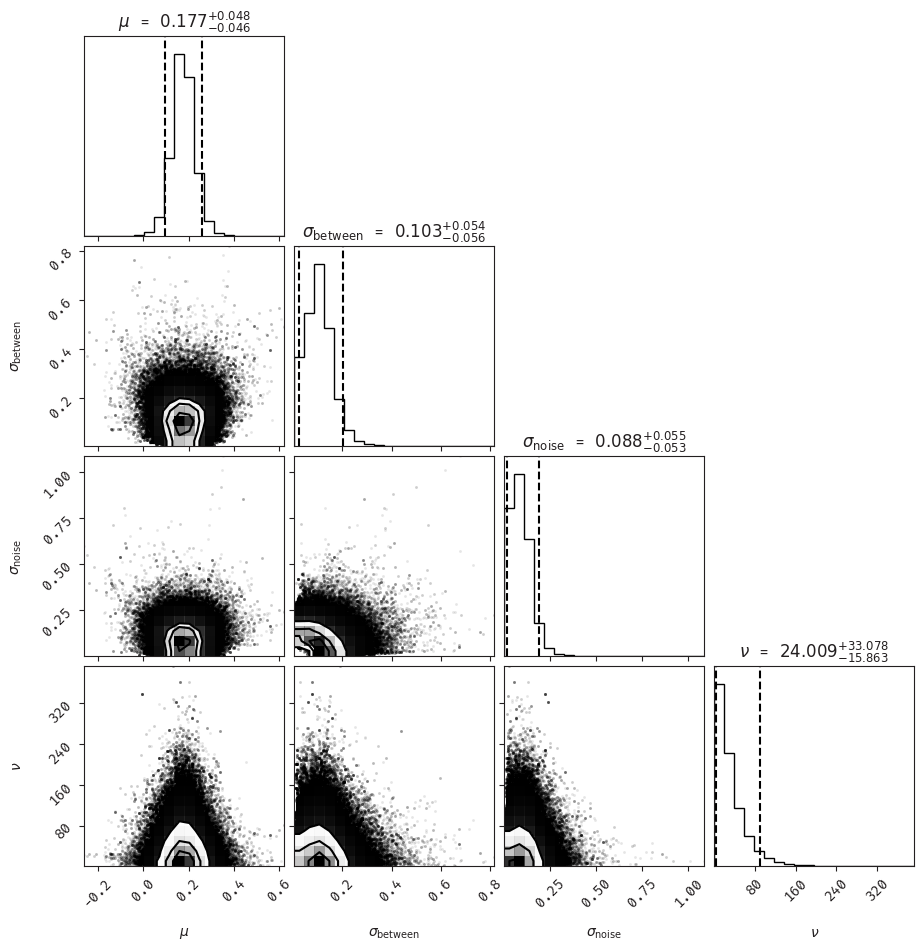

In [ ]:
# ------------------------------------------------------------------
# Corner plot
# ------------------------------------------------------------------
samples_4d = np.column_stack([mu_samples,
                              sigma_between_samples,
                              sigma_noise_samples,
                              nu_samples])

labels = [r"$\mu$",
          r"$\sigma_{\mathrm{between}}$",
          r"$\sigma_{\mathrm{noise}}$",
          r"$\nu$"]

fig = corner.corner(samples_4d,
                    labels=labels,
                    quantiles=[0.05, 0.95],
                    show_titles=True,
                    title_fmt=".3f")
plt.show()


100%|██████████| 8000/8000 [00:04<00:00, 1600.96it/s]


P(Model A better)  = 0.999
95% HDI for μ      = [0.0801, 0.2690]
Posterior mean σ   = 0.1404
Posterior median ν = 25.6


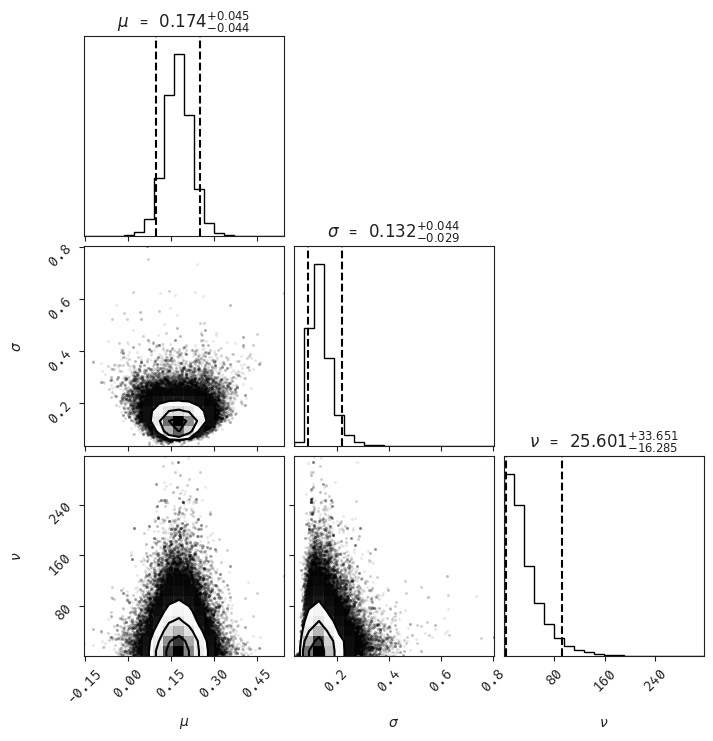

In [ ]:
import numpy as np
import emcee
from scipy.special import gammaln
import corner, matplotlib.pyplot as plt

# ------------------------------------------------------------------
# DATA  – paired MCC differences
# ------------------------------------------------------------------
diffs = - metrics_difference["matthews_corr"].to_numpy() # (- so it's Flare-CME - CME)
N = len(diffs)

# ------------------------------------------------------------------
# Student-t log-pdf
# ------------------------------------------------------------------
def student_t_logpdf(x, loc, scale, df):
    z = (x - loc) / scale
    return (
        gammaln((df + 1) / 2) - gammaln(df / 2)
        - 0.5 * np.log(df * np.pi) - np.log(scale)
        - (df + 1) / 2 * np.log1p(z**2 / df)
    )

# ------------------------------------------------------------------
# Prior hyper-params
# ------------------------------------------------------------------
SIGMA_HIGH = 4.0     # Uniform(0,H) upper bound

# ------------------------------------------------------------------
# LOG-PRIOR
# ------------------------------------------------------------------
def log_prior(theta):
    mu, log_sigma, log_nu_minus_one = theta

    sigma        = np.exp(log_sigma)
    nu_minus_one = np.exp(log_nu_minus_one)
    nu           = nu_minus_one + 1.0

    # support
    if not (-2 < mu < 2):
        return -np.inf
    if not (0 < sigma < SIGMA_HIGH):
        return -np.inf
    if not (-6 < log_nu_minus_one < 6):
        return -np.inf

    lp  = -0.5 * mu**2 - 0.5 * np.log(2*np.pi)        # μ ~ N(0,1)

    # Uniform(0,H) on σ  ⇒  log pdf = −log H + log σ
    lp += -np.log(SIGMA_HIGH) + log_sigma

    # ν−1 ~ Exp(1/29)  +  Jacobian for log
    lambda_rate = 1/29
    lp += -lambda_rate * nu_minus_one + log_nu_minus_one
    return lp

# ------------------------------------------------------------------
# LOG-LIKELIHOOD
# ------------------------------------------------------------------
def log_likelihood(theta, data):
    mu, log_sigma, log_nu_minus_one = theta
    sigma = np.exp(log_sigma)
    nu    = np.exp(log_nu_minus_one) + 1.0
    return np.sum(student_t_logpdf(data, loc=mu, scale=sigma, df=nu))

# ------------------------------------------------------------------
# LOG-POSTERIOR
# ------------------------------------------------------------------
def log_posterior(theta, data):
    lp = log_prior(theta)
    return lp + log_likelihood(theta, data) if np.isfinite(lp) else -np.inf

# ------------------------------------------------------------------
# MCMC setup
# ------------------------------------------------------------------
ndim      = 3                   # μ, log σ, log(ν−1)
n_walkers = 10 * ndim
rng       = np.random.default_rng(42)

init = np.column_stack([
    rng.normal(0.0, 0.2,  n_walkers),   # μ
    rng.normal(-1.0, 0.2, n_walkers),   # log σ
    rng.normal( 1.0, 0.2, n_walkers),   # log(ν−1)
])

sampler = emcee.EnsembleSampler(n_walkers, ndim,
                                log_posterior, args=(diffs,))
sampler.run_mcmc(init, 2000, progress=True)  # burn-in
sampler.reset()
sampler.run_mcmc(None, 8000, progress=True)  # posterior

flat = sampler.get_chain(flat=True)
mu_samples     = flat[:, 0]
sigma_samples  = np.exp(flat[:, 1])
nu_samples     = np.exp(flat[:, 2]) + 1.0

# ------------------------------------------------------------------
# Posterior summaries
# ------------------------------------------------------------------
p_better = (mu_samples > 0).mean()
hdi_low, hdi_high = np.percentile(mu_samples, [2.5, 97.5])
print(f"P(Model A better)  = {p_better:.3f}")
print(f"95% HDI for μ      = [{hdi_low:.4f}, {hdi_high:.4f}]")
print(f"Posterior mean σ   = {sigma_samples.mean():.4f}")
print(f"Posterior median ν = {np.median(nu_samples):.1f}")

# ------------------------------------------------------------------
# Corner plot
# ------------------------------------------------------------------
corner.corner(np.column_stack([mu_samples, sigma_samples, nu_samples]),
              labels=[r"$\mu$", r"$\sigma$", r"$\nu$"],
              quantiles=[0.05, 0.95],
              show_titles=True, title_fmt=".3f")
plt.show()


/home/julio/.local/lib/python3.10/site-packages/xarray/core/concat.py:527: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))



─ ArviZ summary ─
                   mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  \
log_nu_minus_one  3.091  1.005     1.096      4.863      0.013    0.009   
log_sigma        -2.004  0.278    -2.515     -1.435      0.004    0.003   
mu                0.175  0.047     0.084      0.272      0.001    0.000   

                  ess_bulk   ess_tail  r_hat  
log_nu_minus_one  5864.119  14457.091  1.004  
log_sigma         5731.106  14928.945  1.004  
mu                6117.544  14155.110  1.006  

Max R̂: 1.006  (✓ OK)


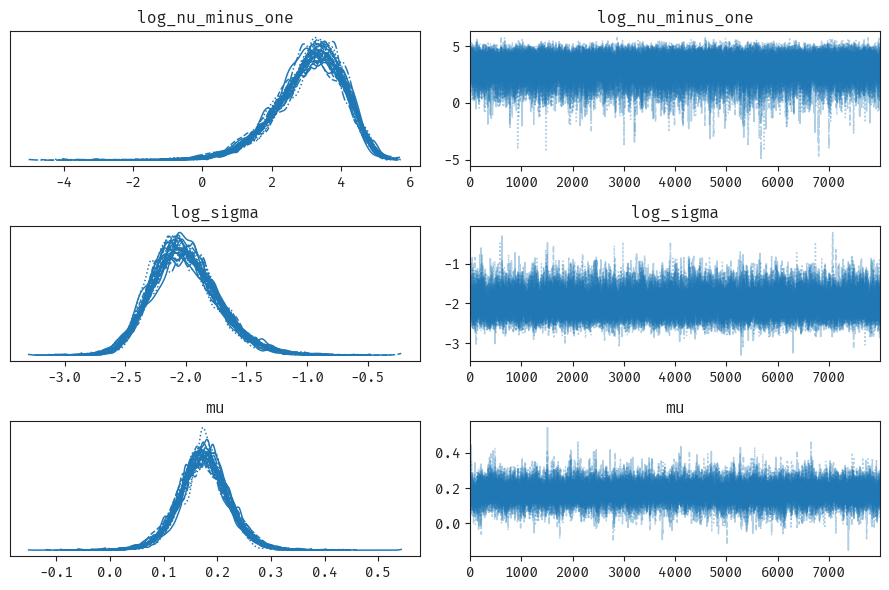

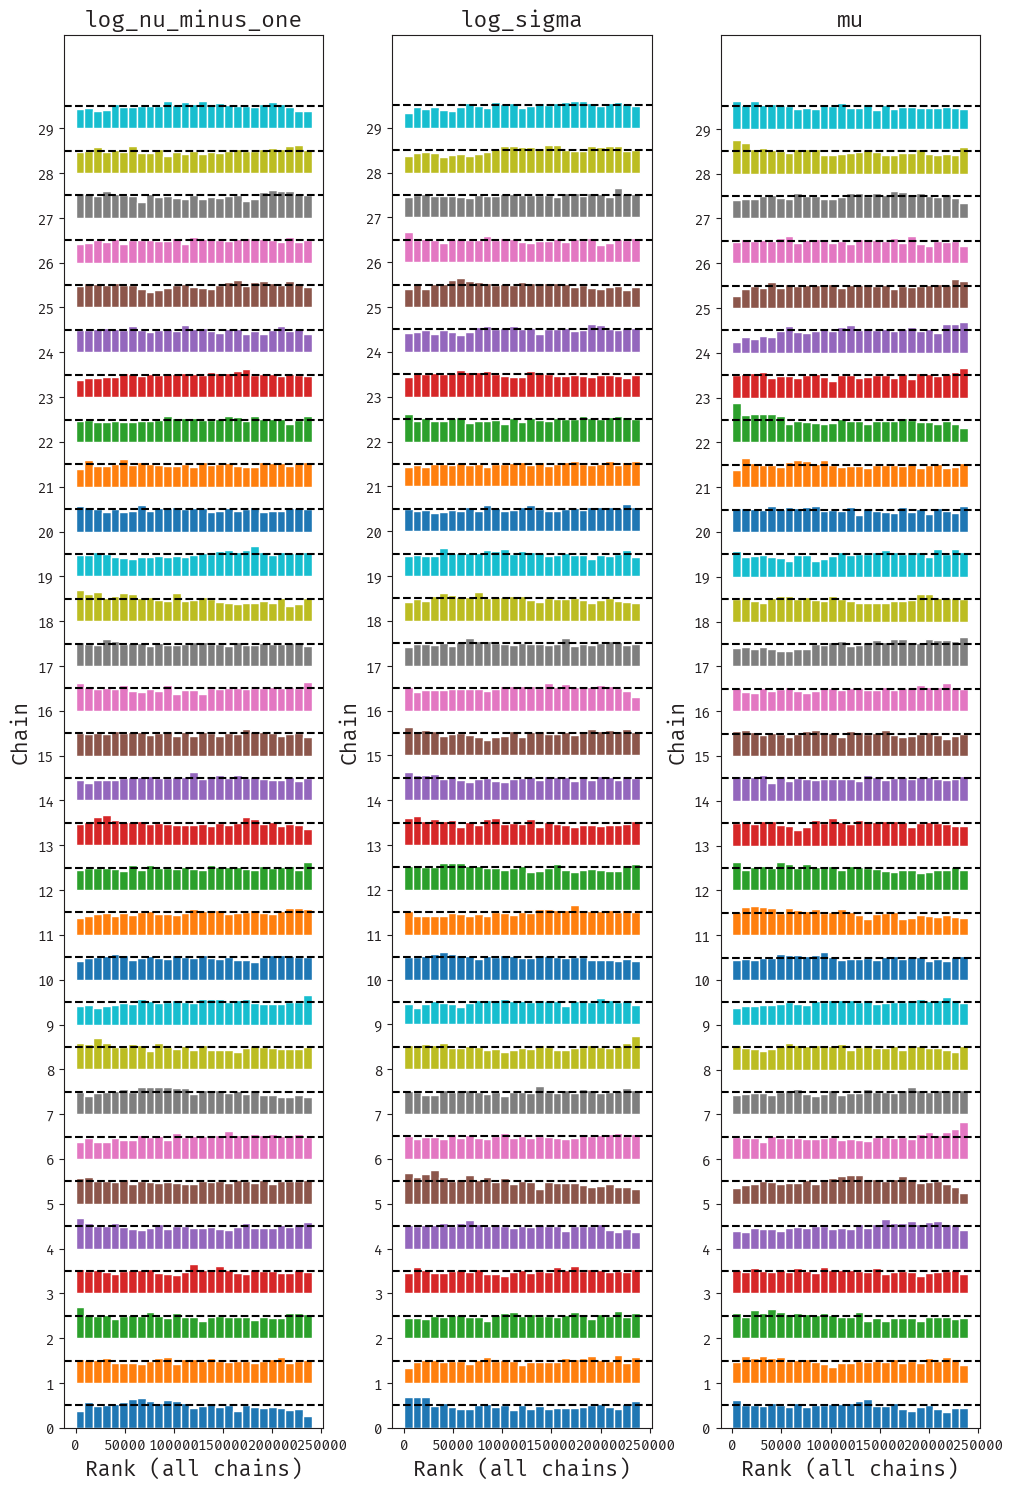


Integrated autocorrelation time (IAT):
                 mu:   36.8
          log_sigma:   39.6
   log_nu_minus_one:   39.6

Mean acceptance fraction: 0.642


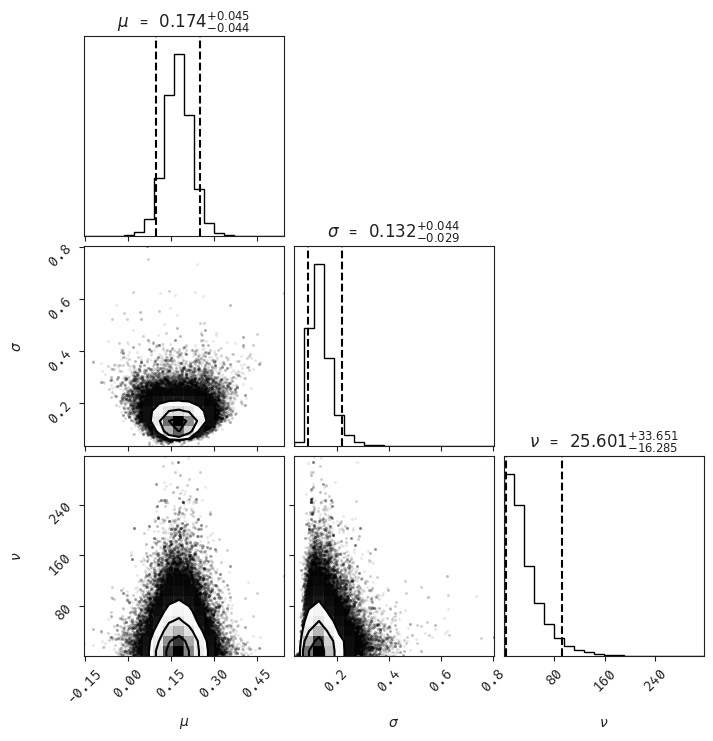

In [ ]:
# ================================================================
#  Diagnostics for the non-hierarchical model
# ================================================================
import arviz as az
import numpy as np
import matplotlib.pyplot as plt
import corner

# ------------------------------------------------
# 1.  Convert emcee output → ArviZ InferenceData
# ------------------------------------------------
idata = az.from_emcee(
    sampler,
    var_names=["mu", "log_sigma", "log_nu_minus_one"],
)

# ------------------------------------------------
# 2.  R̂ and ESS
# ------------------------------------------------
summary = az.summary(idata, round_to=3, hdi_prob=0.95)
print("\n─ ArviZ summary ─")
print(summary)

rhat_max = summary["r_hat"].max()
print(f"\nMax R̂: {rhat_max:.3f}  "
      f"({'✓ OK' if rhat_max < 1.05 else '⚠ needs more draws'})")

# ------------------------------------------------
# 3.  Trace & rank plots
# ------------------------------------------------
az.plot_trace(idata, compact=True, figsize=(9, 6))
plt.tight_layout()
plt.show()

az.plot_rank(idata, figsize=(10,15))
plt.tight_layout()
plt.show()

# ------------------------------------------------
# 4.  Integrated autocorrelation time (IAT)
# ------------------------------------------------
try:
    tau = sampler.get_autocorr_time(tol=0)
    print("\nIntegrated autocorrelation time (IAT):")
    for name, t in zip(["mu", "log_sigma", "log_nu_minus_one"], tau):
        print(f"  {name:>17s}: {t:6.1f}")
except emcee.autocorr.AutocorrError as e:
    print("\nIAT could not be reliably estimated:", e)

# ------------------------------------------------
# 5.  Acceptance fraction
# ------------------------------------------------
print("\nMean acceptance fraction:",
      np.mean(sampler.acceptance_fraction).round(3))

# ------------------------------------------------
# 6.  Corner plot of marginal posteriors (optional)
# ------------------------------------------------
mu_samp   = flat[:, 0]
sigma_samp= np.exp(flat[:, 1])
nu_samp   = np.exp(flat[:, 2]) + 1

corner.corner(
    np.column_stack([mu_samp, sigma_samp, nu_samp]),
    labels=[r"$\mu$", r"$\sigma$", r"$\nu$"],
    show_titles=True, title_fmt=".3f", quantiles=[0.05, 0.95]
)
plt.show()


In [ ]:
# Now format for latex, we want only some columns and we wan mean (std)

latex_metrics = {
    "true_skill_statistic": "TSS",
    "matthews_corr": "MCC",
    "average_precision_score": "AP",
                 }

latex_combined_metrics = grouped_combined_metrics[[metric for metric in latex_metrics.keys()]].copy()

# Create new formatted column

for key, value in latex_metrics.items():
    for forecast_type in ["cme", "flare_cme"]:
        f_data = latex_combined_metrics.loc[forecast_type, key]
        if key == "threshold":
            latex_combined_metrics.loc[forecast_type, f"{value}"] = f"{float(f_data['mean']):.2f}"
            continue
        latex_combined_metrics.loc[forecast_type, f"{value}"] = f"{float(f_data['mean']):.2f} ({float(f_data['std']):.2f})"

# Drop old columns
latex_combined_metrics.drop(list(latex_metrics.keys()), axis=1, inplace=True)

# Convert to normal dataframe, type is another column
latex_combined_metrics.reset_index(inplace=True)

# Rename Forecast Type as follows
forcast_types = {
    "cme": "CME",
    "flare_cme": "Flare + Flare-CME"
}

# Rename type to Forecast Type
latex_combined_metrics.rename(columns={"type": "Forecast Type"}, inplace=True)

# Rename the rows and order as in forecast_types
latex_combined_metrics["Forecast Type"] = latex_combined_metrics["Forecast Type"].map(forcast_types)

# Reorder the rows
latex_combined_metrics = latex_combined_metrics.reindex([0, 1]).reset_index(drop=True)

latex_combined_metrics.to_latex(index=False, buf="combined_metrics.tex")
latex_combined_metrics

/tmp/ipykernel_155241/498437321.py:22: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  latex_combined_metrics.drop(list(latex_metrics.keys()), axis=1, inplace=True)


,Forecast Type,TSS,MCC,AP
,,,,
0,CME,-0.01 (0.05),-0.02 (0.08),0.56 (0.12)
1,Flare + Flare-CME,0.15 (0.10),0.16 (0.10),0.45 (0.08)


In [ ]:
# Finally, only_active metrics

only_active_metrics = get_independent_metrics(data, threshold=thresholds, only_active=True)
grouped_only_active_metrics = only_active_metrics.groupby("type").agg(["mean", "std"])

100%|██████████| 10/10 [00:02<00:00,  4.66it/s]


flare
TN 10229.7 3078.1899242899226
FP 11179.9 3068.0542840699545
FN 871.9 383.41477540647804
TP 5308.5 477.4126621697418

cme
TN 35126.3 5283.052735871562
FP 21048.1 3696.9547048888767
FN 5311.6 985.8435169944569
TP 6689.4 584.81436370869

flare_cme
TN 879.4 553.5001716350231
FP 932.8 342.3290230173305
FN 865.1 404.03550586551177
TP 1248.9 495.7419590875882


In [ ]:
# Now format for latex, we want only some columns and we wan mean (std)

latex_metrics = {
    "true_skill_statistic": "TSS",
    "heidke_skill_score": "HSS",
    "average_precision_score": "AP",
                 }

latex_only_active_metrics = grouped_only_active_metrics[[metric for metric in latex_metrics.keys()]].copy()


# Create new formatted column

for key, value in latex_metrics.items():
    for forecast_type in ["flare", "cme", "flare_cme"]:
        f_data = latex_only_active_metrics.loc[forecast_type, key]
        if key == "threshold":
            latex_only_active_metrics.loc[forecast_type, f"{value}"] = f"{float(f_data['mean']):.2f}"
            continue
        latex_only_active_metrics.loc[forecast_type, f"{value}"] = f"{float(f_data['mean']):.2f} ({float(f_data['std']):.2f})"

# Drop old columns
        
latex_only_active_metrics.drop(list(latex_metrics.keys()), axis=1, inplace=True)

# Convert to normal dataframe, type is another column

latex_only_active_metrics.reset_index(inplace=True)

# Rename Forecast Type as follows

forcast_types = {
    "flare": "Flare",
    "cme": "CME",
    "flare_cme": "Flare-CME"
}

# Rename type to Forecast Type
latex_only_active_metrics.rename(columns={"type": "Forecast Type"}, inplace=True)

# Rename the rows and order as in forecast_types
latex_only_active_metrics["Forecast Type"] = latex_only_active_metrics["Forecast Type"].map(forcast_types)

# Reorder the rows

latex_only_active_metrics = latex_only_active_metrics.reindex([1, 0, 2]).reset_index(drop=True)

latex_only_active_metrics.to_latex(index=False, buf="only_active_metrics.tex")
latex_only_active_metrics

/tmp/ipykernel_155241/2872614170.py:24: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  latex_only_active_metrics.drop(list(latex_metrics.keys()), axis=1, inplace=True)


,Forecast Type,TSS,HSS,AP
,,,,
0,Flare,0.34 (0.05),0.22 (0.07),0.52 (0.13)
1,CME,0.19 (0.06),0.12 (0.05),0.28 (0.07)
2,Flare-CME,0.03 (0.15),0.04 (0.15),0.57 (0.11)


# Ratio of event active to event quiet regions

In [33]:
# Get the number of event active regions in total. We need to see

flare_harpnums = data[~data["flare_target"].isna()]["harpnum"].unique()
cme_harpnums = data[~data["cme_target"].isna()]["harpnum"].unique()
flare_cme_harpnums = data[~data["flare_cme_target"].isna()]["harpnum"].unique()

print(f"Number of unique HARP regions in flares dataset: {len(flare_harpnums)}")
print(f"Number of unique HARP regions in CMEs dataset: {len(cme_harpnums)}")
print(f"Number of unique HARP regions inj flare-CME dataset: {len(flare_cme_harpnums)}")

Number of unique HARP regions in flares dataset: 2881
Number of unique HARP regions in CMEs dataset: 2881
Number of unique HARP regions inj flare-CME dataset: 148


In [34]:
# Calculate event active ratio
active_flare_harpnums = data[data["flare_target"] == 1]["harpnum"].unique()
active_cme_harpnums = data[data["cme_target"] == 1]["harpnum"].unique()
active_flare_cme_harpnums = data[data["flare_cme_target"] == 1]["harpnum"].unique()

print(f"Flare event active ratio:", len(active_flare_harpnums) / len(flare_harpnums))
print(f"CME event active ratio:", len(active_cme_harpnums) / len(cme_harpnums))
print(f"Flare-CME event active ratio:", len(active_flare_cme_harpnums) / len(flare_cme_harpnums))

Flare event active ratio: 0.05137105171815342
CME event active ratio: 0.13467545990975355
Flare-CME event active ratio: 0.46621621621621623


In [35]:
# WARNING. HERE FLARE ACTIVE IS WHETHER IT HAS A FLARE >M AND CME ACTIVE ANY KIND OF CME AND CME_FLARE ACTIVE IS FLARE >M WITH ASSOCIATED CME.
# Group the data dataframe by what the baseline prediction is per event
activity_data = pd.read_sql("""
SELECT 
harpnum, 
MAX(has_flare_above_threshold) AS is_flare_active,
MAX(MAX(has_cme_flare_above_threshold), MAX(has_cme_flare_below_threshold), MAX(has_cme_no_flare)) AS is_cme_active,
MAX(has_cme_flare_above_threshold) AS is_cme_flare_active
FROM features.T_24_L_24_S_0_2_B_0_OVERLAPS_1_MIN_FLARE_30_dataset
GROUP BY harpnum
""", conn)

activity_data.head()

,harpnum,is_flare_active,is_cme_active,is_cme_flare_active
0,1,0,0,0
1,2,0,0,0
2,5,0,0,0
3,6,0,0,0
4,8,1,1,0


In [36]:
# Now count for each, the number of active and non active. For flares this is using is_active. For cmes and flare-cme this is is_cme_active

# Using only the harpnums in the each dataset

flare_active = activity_data[activity_data["harpnum"].isin(flare_harpnums)]["is_flare_active"].value_counts()
flare_active_regions = activity_data[activity_data["harpnum"].isin(flare_harpnums) & (activity_data["is_flare_active"] == 1)]["harpnum"].unique()
flare_non_active_regions = activity_data[activity_data["harpnum"].isin(flare_harpnums) & (activity_data["is_flare_active"] == 0)]["harpnum"].unique()

cme_active = activity_data[activity_data["harpnum"].isin(cme_harpnums)]["is_cme_active"].value_counts()
cme_active_regions = activity_data[activity_data["harpnum"].isin(cme_harpnums) & (activity_data["is_cme_active"] == 1)]["harpnum"].unique()
cme_non_active_regions = activity_data[activity_data["harpnum"].isin(cme_harpnums) & (activity_data["is_cme_active"] == 0)]["harpnum"].unique()

flare_cme_active = activity_data[activity_data["harpnum"].isin(flare_cme_harpnums)]["is_cme_flare_active"].value_counts()
flare_cme_active_regions = activity_data[activity_data["harpnum"].isin(flare_cme_harpnums) & (activity_data["is_cme_flare_active"] == 1)]["harpnum"].unique()
flare_cme_non_active_regions = activity_data[activity_data["harpnum"].isin(flare_cme_harpnums) & (activity_data["is_cme_flare_active"] == 0)]["harpnum"].unique()

flare_active_ratio = flare_active[1] / (flare_active[1] + flare_active[0])

n_flare_active = flare_active[1]
n_cme_active = cme_active[1]
n_flare_cme_active = flare_cme_active[1]

n_tot_flare = len(flare_harpnums)
n_tot_cme = len(cme_harpnums)
n_tot_flare_cme = len(flare_cme_harpnums)

flare_active_ratio = n_flare_active / n_tot_flare
cme_active_ratio = n_cme_active / n_tot_cme
flare_cme_active_ratio = n_flare_cme_active / n_tot_flare_cme

print(f"Number of active regions in flares dataset: {flare_active[1]}")
print(f"Number of non-active regions in flares dataset: {flare_active[0]}")
print(f"Ratio of active regions in flares dataset: {flare_active_ratio}")

print("\n")

print(f"Number of active regions in CMEs dataset: {cme_active[1]}")
print(f"Number of non-active regions in CMEs dataset: {cme_active[0]}")
print(f"Ratio of active regions in CMEs dataset: {cme_active_ratio}")

print("\n")

print(f"Number of active regions in flare-CME dataset: {flare_cme_active[1]}")
print(f"Number of non-active regions in flare-CME dataset: {flare_cme_active[0]}")
print(f"Ratio of active regions in flare-CME dataset: {flare_cme_active_ratio}")

# Put in a table

activity_table = pd.DataFrame({
    "Dataset": ["Flare", "CME", "Flare-CME"],
    "Ratio": [flare_active_ratio, cme_active_ratio, flare_cme_active_ratio]
})

# To latex with two decimal places
activity_table.to_latex(index=False, buf="event_ratios.tex", float_format="%.2f")

Number of active regions in flares dataset: 148
Number of non-active regions in flares dataset: 2733
Ratio of active regions in flares dataset: 0.05137105171815342


Number of active regions in CMEs dataset: 388
Number of non-active regions in CMEs dataset: 2493
Ratio of active regions in CMEs dataset: 0.13467545990975355


Number of active regions in flare-CME dataset: 69
Number of non-active regions in flare-CME dataset: 79
Ratio of active regions in flare-CME dataset: 0.46621621621621623


In [37]:
split_harpnums = data.groupby("run_id")["harpnum"].unique().to_dict()

In [38]:
data

,run_id,harpnum,start,end,flare_pred,flare_target,cme_pred,cme_target,flare_cme_pred,flare_cme_target,base_cme_pred,base_flare_cme_pred,base_flare_pred
0,2,1,2010-05-01 17:19:00,2010-05-02 17:19:00,0.041532,0.0,0.362480,0.0,NaN,NaN,0,0,0
1,2,1,2010-05-01 17:31:00,2010-05-02 17:31:00,0.041253,0.0,0.363391,0.0,NaN,NaN,0,0,0
2,2,1,2010-05-01 18:43:00,2010-05-02 18:43:00,0.040994,0.0,0.363362,0.0,NaN,NaN,0,0,0
3,2,1,2010-05-01 18:55:00,2010-05-02 18:55:00,0.039852,0.0,0.361246,0.0,NaN,NaN,0,0,0
4,2,1,2010-05-01 19:07:00,2010-05-02 19:07:00,0.040362,0.0,0.362813,0.0,NaN,NaN,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3115951,5,7298,2018-08-16 04:07:00,2018-08-17 04:07:00,0.006441,0.0,0.237142,0.0,NaN,NaN,0,0,0
3115952,5,7298,2018-08-16 04:19:00,2018-08-17 04:19:00,0.006502,0.0,0.238743,0.0,NaN,NaN,0,0,0
3115953,5,7298,2018-08-16 04:31:00,2018-08-17 04:31:00,0.006278,0.0,0.234828,0.0,NaN,NaN,0,0,0
3115954,5,7298,2018-08-16 04:43:00,2018-08-17 04:43:00,0.006356,0.0,0.236540,0.0,NaN,NaN,0,0,0


In [39]:
# Now, we must iterate through the non-active regions and drop them one by one
# Calculate the TSS with the data and put in a list.
# Also calculate the ratio and put it in another list

# ------------------------------------------------------------------
# containers
# ------------------------------------------------------------------
flare_tss_values, cme_tss_values, cme_flare_tss_values = [], [], []
flare_mcc_values,  cme_mcc_values,  cme_flare_mcc_values  = [], [], []
flare_ap_values,   cme_ap_values,   cme_flare_ap_values   = [], [], []

flare_ratio_values, cme_ratio_values, cme_flare_ratio_values = [], [], []

cme_tp_values, cme_tn_values, cme_fp_values, cme_fn_values = [], [], [], []
flare_cme_tp_values, flare_cme_tn_values, flare_cme_fp_values, flare_cme_fn_values = [], [], [], []
flare_tp_values, flare_tn_values, flare_fp_values, flare_fn_values = [], [], [], []


temp_flare_data = data.copy()
temp_cme_data = data.copy()
temp_cme_flare_data = data.copy()

# Let's iterate by 200 regions at a time

n_iters =50 
f_n_per_iter = len(flare_non_active_regions) // n_iters
c_n_per_iter = len(cme_non_active_regions) // n_iters
c_f_n_per_iter = len(flare_cme_non_active_regions) // n_iters

f_ratio_values = np.linspace(flare_active_ratio, 1, n_iters + 1)
c_ratio_values = np.linspace(cme_active_ratio, 1, n_iters + 1)
c_f_ratio_values = np.linspace(flare_cme_active_ratio, 1, n_iters + 1)

current_flare_active_regions = flare_active_regions.copy()
c_n_f_ar = len(current_flare_active_regions)
current_flare_non_active_regions = flare_non_active_regions.copy()
c_n_f_nar = len(current_flare_non_active_regions)
current_cme_active_regions = cme_active_regions.copy()
c_n_c_ar = len(current_cme_active_regions)
current_cme_non_active_regions = cme_non_active_regions.copy()
c_n_c_nar = len(current_cme_non_active_regions)
current_flare_cme_active_regions = flare_cme_active_regions.copy()
c_n_f_c_ar = len(current_flare_cme_active_regions)
current_flare_cme_non_active_regions = flare_cme_non_active_regions.copy()
c_n_f_c_nar = len(current_flare_cme_non_active_regions)

for i in tqdm(range(n_iters + 1)):
    # Drop the harpnum
    f_obj_ratio = f_ratio_values[i]
    cme_obj_ratio = c_ratio_values[i]
    cme_f_obj_ratio = c_f_ratio_values[i]

    target_n_f_non_active = c_n_f_ar / f_obj_ratio - c_n_f_ar
    target_n_c_non_active = c_n_c_ar / cme_obj_ratio - c_n_c_ar
    target_n_f_c_non_active = c_n_f_c_ar / cme_f_obj_ratio - c_n_f_c_ar

    # Choose the number from the current flare active regions
    if i != n_iters:
        current_flare_non_active_regions = np.random.choice(current_flare_non_active_regions, size=int(target_n_f_non_active), replace=False)
        current_cme_non_active_regions = np.random.choice(current_cme_non_active_regions, size=int(target_n_c_non_active), replace=False)
        current_flare_cme_non_active_regions = np.random.choice(current_flare_cme_non_active_regions, size=int(target_n_f_c_non_active), replace=False)

        c_n_f_nar = len(current_flare_non_active_regions)
        c_n_c_nar = len(current_cme_non_active_regions)
        c_n_f_c_nar = len(current_flare_cme_non_active_regions)

        all_f_regions = np.concatenate([current_flare_active_regions, current_flare_non_active_regions])
        all_c_regions = np.concatenate([current_cme_active_regions, current_cme_non_active_regions])
        all_f_c_regions = np.concatenate([current_flare_cme_active_regions, current_flare_cme_non_active_regions])
    else:
        current_flare_non_active_regions = np.array([])
        current_cme_non_active_regions = np.array([])
        current_flare_cme_non_active_regions = np.array([])

        c_n_f_nar = 0
        c_n_c_nar = 0
        c_n_f_c_nar = 0

        all_f_regions = current_flare_active_regions
        all_c_regions = current_cme_active_regions
        all_f_c_regions = current_flare_cme_active_regions

    temp_flare_data = temp_flare_data[temp_flare_data["harpnum"].isin(all_f_regions)]
    temp_cme_data = temp_cme_data[temp_cme_data["harpnum"].isin(all_c_regions)]
    temp_cme_flare_data = temp_cme_flare_data[temp_cme_flare_data["harpnum"].isin(all_f_c_regions)]

    flare_preds, flare_targets = temp_flare_data[["flare_pred", "flare_target"]].dropna().values.T
    binary_flare_preds = (flare_preds > thresholds["flare"]).astype(int)

    cme_preds, cme_targets = temp_cme_data[["cme_pred", "cme_target"]].dropna().values.T
    binary_cme_preds = (cme_preds > thresholds["cme"]).astype(int)
    
    cme_flare_preds, cme_flare_targets = temp_cme_flare_data[["flare_cme_pred", "flare_cme_target"]].dropna().values.T
    binary_cme_flare_preds = (cme_flare_preds > thresholds["flare_cme"]).astype(int)

    # Calculate using the function get_independent_metrics
    
    flare_cm = confusion_matrix(flare_targets, binary_flare_preds)
    cme_cm = confusion_matrix(cme_targets, binary_cme_preds)
    cme_flare_cm = confusion_matrix(cme_flare_targets, binary_cme_flare_preds)

    #Unravel
    fTN, fFP, fFN, fTP = flare_cm.ravel()
    cTN, cFP, cFN, cTP = cme_cm.ravel()
    c_fTN, c_fFP, c_fFN, c_fTP = cme_flare_cm.ravel()

    fTSS = fTP / (fTP + fFN) - (fFP / (fFP + fTN))
    cTSS = cTP / (cTP + cFN) - (cFP / (cFP + cTN))
    c_fTSS = c_fTP / (c_fTP + c_fFN) - (c_fFP / (c_fFP + c_fTN))

    flare_tss_values.append(fTSS)
    cme_tss_values.append(cTSS)
    cme_flare_tss_values.append(c_fTSS)

    flare_mcc_values.append(
        matthews_corrcoef(flare_targets, binary_flare_preds)
    )
    cme_mcc_values.append(
        matthews_corrcoef(cme_targets,  binary_cme_preds)
    )
    cme_flare_mcc_values.append(
        matthews_corrcoef(cme_flare_targets, binary_cme_flare_preds)
    )

    flare_ap_values.append(
        average_precision_score(flare_targets, flare_preds)
    )
    cme_ap_values.append(
        average_precision_score(cme_targets,  cme_preds)
    )
    cme_flare_ap_values.append(
        average_precision_score(cme_flare_targets, cme_flare_preds)
    )

    cme_tn_values.append(cTN)
    cme_fp_values.append(cFP)
    cme_fn_values.append(cFN)
    cme_tp_values.append(cTP)
    flare_cme_tn_values.append(c_fTN)
    flare_cme_fp_values.append(c_fFP)
    flare_cme_fn_values.append(c_fFN)
    flare_cme_tp_values.append(c_fTP)
    flare_tn_values.append(fTN)
    flare_fp_values.append(fFP)
    flare_fn_values.append(fFN)
    flare_tp_values.append(fTP)
    
    # Now calculate the ratio
    flare_only_data = temp_flare_data[~temp_flare_data["flare_target"].isna()].copy()
    active_regions = flare_only_data["harpnum"].unique()

    counts = activity_data[activity_data["harpnum"].isin(active_regions)]["is_flare_active"].value_counts()

    # Check that there's a 1 and 0. For the last one there won't be a 0
    if 0 not in counts:
        counts[0] = 0

    ratio = counts[1] / (counts[1] + counts[0])

    flare_ratio_values.append(ratio)

    cme_only_data = temp_cme_data[~temp_cme_data["cme_target"].isna()].copy()
    active_regions = cme_only_data["harpnum"].unique()

    counts = activity_data[activity_data["harpnum"].isin(active_regions)]["is_cme_active"].value_counts()

    # Check that there's a 1 and 0. For the last one there won't be a 0
    if 0 not in counts:
        counts[0] = 0

    ratio = counts[1] / (counts[1] + counts[0])

    cme_ratio_values.append(ratio)
    
    cme_flare_only_data = temp_cme_flare_data[~temp_cme_flare_data["flare_cme_target"].isna()].copy()
    active_regions = cme_flare_only_data["harpnum"].unique()
    
    counts = activity_data[activity_data["harpnum"].isin(active_regions)]["is_cme_flare_active"].value_counts()
    
    # Check that there's a 1 and 0. For the last one there won't be a 0
    if 0 not in counts:
        counts[0] = 0
    
    ratio = counts[1] / (counts[1] + counts[0])

    cme_flare_ratio_values.append(ratio)
    

100%|██████████| 51/51 [01:18<00:00,  1.54s/it]


In [40]:
# =============================================================
# Collect *all* metrics into one DataFrame
#   columns: iter, run_id, type, ratio, tss, mcc, ap, tp, tn, fp, fn
# =============================================================
import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, matthews_corrcoef, average_precision_score

n_iters   = 10
run_ids   = sorted(split_harpnums.keys())     # e.g. 0…9
rng       = np.random.default_rng(0)

# -------------------------------------------------------------
# Helper to build per-run region sets
# -------------------------------------------------------------
flare_act  = {rid: np.intersect1d(flare_active_regions,  split_harpnums[rid]) for rid in run_ids}
flare_nact = {rid: np.intersect1d(flare_non_active_regions,  split_harpnums[rid]) for rid in run_ids}
cme_act    = {rid: np.intersect1d(cme_active_regions,    split_harpnums[rid]) for rid in run_ids}
cme_nact   = {rid: np.intersect1d(cme_non_active_regions,    split_harpnums[rid]) for rid in run_ids}
cf_act     = {rid: np.intersect1d(flare_cme_active_regions, split_harpnums[rid]) for rid in run_ids}
cf_nact    = {rid: np.intersect1d(flare_cme_non_active_regions, split_harpnums[rid]) for rid in run_ids}

cur_f_nact = {k: v.copy() for k, v in flare_nact.items()}
cur_c_nact = {k: v.copy() for k, v in cme_nact.items()}
cur_cf_nact= {k: v.copy() for k, v in cf_nact.items()}

# -------------------------------------------------------------
# Global average ratios to build target schedule
# -------------------------------------------------------------
flare_active_ratio     = np.mean([len(flare_act[r]) / (len(flare_act[r])+len(flare_nact[r])) for r in run_ids])
cme_active_ratio       = np.mean([len(cme_act[r])   / (len(cme_act[r])  +len(cme_nact[r]))  for r in run_ids])
flare_cme_active_ratio = np.mean([len(cf_act[r])    / (len(cf_act[r])   +len(cf_nact[r]))   for r in run_ids])

f_ratio_values  = np.linspace(flare_active_ratio,     1, n_iters+1)
c_ratio_values  = np.linspace(cme_active_ratio,       1, n_iters+1)
cf_ratio_values = np.linspace(flare_cme_active_ratio, 1, n_iters+1)

# -------------------------------------------------------------
# Copies of the full data tables
# -------------------------------------------------------------
temp_flare_data      = data.copy()
temp_cme_data        = data.copy()
temp_cme_flare_data  = data.copy()

# -------------------------------------------------------------
# storage list → DataFrame
# -------------------------------------------------------------
rows = []

# =============================================================
# MAIN LOOP  (iterate over iterations and CV runs)
# =============================================================
for i in tqdm(range(n_iters + 1)):
    targ_f_ratio, targ_c_ratio, targ_cf_ratio = (
        f_ratio_values[i], c_ratio_values[i], cf_ratio_values[i]
    )

    for rid in run_ids:
        # ---------- adjust non-active pools to hit target ratio ----------
        def drop_needed(n_act, target_ratio, cur_nact):
            goal_nact = int(round(n_act / target_ratio - n_act))
            to_drop   = max(len(cur_nact) - goal_nact, 0)
            if to_drop:
                idx = rng.choice(len(cur_nact), to_drop, replace=False)
                return np.delete(cur_nact, idx)
            return cur_nact

        cur_f_nact[rid]  = drop_needed(len(flare_act[rid]),  targ_f_ratio,  cur_f_nact[rid])
        cur_c_nact[rid]  = drop_needed(len(cme_act[rid]),    targ_c_ratio,  cur_c_nact[rid])
        cur_cf_nact[rid] = drop_needed(len(cf_act[rid]),     targ_cf_ratio, cur_cf_nact[rid])

        # ---------- region sets ----------
        f_regions  = np.concatenate([flare_act[rid],  cur_f_nact[rid]])
        c_regions  = np.concatenate([cme_act[rid],    cur_c_nact[rid]])
        cf_regions = np.concatenate([cf_act[rid],     cur_cf_nact[rid]])

        subsets = {
            "flare":     temp_flare_data[(temp_flare_data.run_id==rid) & temp_flare_data.harpnum.isin(f_regions)],
            "cme":       temp_cme_data  [(temp_cme_data.run_id==rid)   & temp_cme_data.harpnum.isin(c_regions)],
            "flare_cme": temp_cme_flare_data[(temp_cme_flare_data.run_id==rid) & temp_cme_flare_data.harpnum.isin(cf_regions)],
        }
        thr = {"flare": thresholds["flare"],
               "cme":   thresholds["cme"],
               "flare_cme": thresholds["flare_cme"]}

        # ---------- compute & store metrics for each forecast type ----------
        for typ, df in subsets.items():
            if df.empty:
                continue

            pcol, tcol = {
                "flare":     ("flare_pred",     "flare_target"),
                "cme":       ("cme_pred",       "cme_target"),
                "flare_cme": ("flare_cme_pred", "flare_cme_target")
            }[typ]

            preds, targs = df[[pcol, tcol]].dropna().values.T
            bin_preds    = (preds > thr[typ]).astype(int)
            TN, FP, FN, TP = confusion_matrix(targs, bin_preds).ravel()

            # ratio = active regions / total regions in this subset
            n_act = len(df[df[tcol]==1]["harpnum"].unique())
            n_tot = len(df["harpnum"].unique())
            ratio = n_act / n_tot if n_tot else np.nan

            rows.append({
                "iter": i,
                "run_id": rid,
                "type": typ,
                "ratio": ratio,
                "tss": TP/(TP+FN) - FP/(FP+TN),
                "mcc": matthews_corrcoef(targs, bin_preds),
                "ap":  average_precision_score(targs, preds),
                "tp": TP, "tn": TN, "fp": FP, "fn": FN
            })

# -------------------------------------------------------------
# FINAL DataFrame
# -------------------------------------------------------------
metrics_df = pd.DataFrame(rows)
metrics_df.head()


100%|██████████| 11/11 [00:18<00:00,  1.66s/it]


,iter,run_id,type,ratio,tss,mcc,ap,tp,tn,fp,fn
0,0,0,flare,0.061082,0.707100,0.326152,0.353749,4887,287680,26666,1284
1,0,0,cme,0.160558,0.357486,0.206543,0.151066,6285,270042,37354,6836
2,0,0,flare_cme,0.468750,-0.015716,-0.014861,0.350315,734,2276,1637,1089
3,0,1,flare,0.056218,0.698057,0.354501,0.333954,5108,304383,22487,1553
4,0,1,cme,0.155026,0.347301,0.209189,0.148595,6140,285544,34495,7352


findfont: Font family 'FiraCode Nerd Font' not found.
findfont: Font family 'FiraCode Nerd Font' not found.
findfont: Font family 'FiraCode Nerd Font' not found.
findfont: Font family 'FiraCode Nerd Font' not found.
findfont: Font family 'FiraCode Nerd Font' not found.
findfont: Font family 'FiraCode Nerd Font' not found.
findfont: Font family 'FiraCode Nerd Font' not found.
findfont: Font family 'FiraCode Nerd Font' not found.
findfont: Font family 'FiraCode Nerd Font' not found.
findfont: Font family 'FiraCode Nerd Font' not found.
findfont: Font family 'FiraCode Nerd Font' not found.
findfont: Font family 'FiraCode Nerd Font' not found.
findfont: Font family 'FiraCode Nerd Font' not found.
findfont: Font family 'FiraCode Nerd Font' not found.
findfont: Font family 'FiraCode Nerd Font' not found.
findfont: Font family 'FiraCode Nerd Font' not found.
findfont: Font family 'FiraCode Nerd Font' not found.
findfont: Font family 'FiraCode Nerd Font' not found.
findfont: Font family 'FiraC

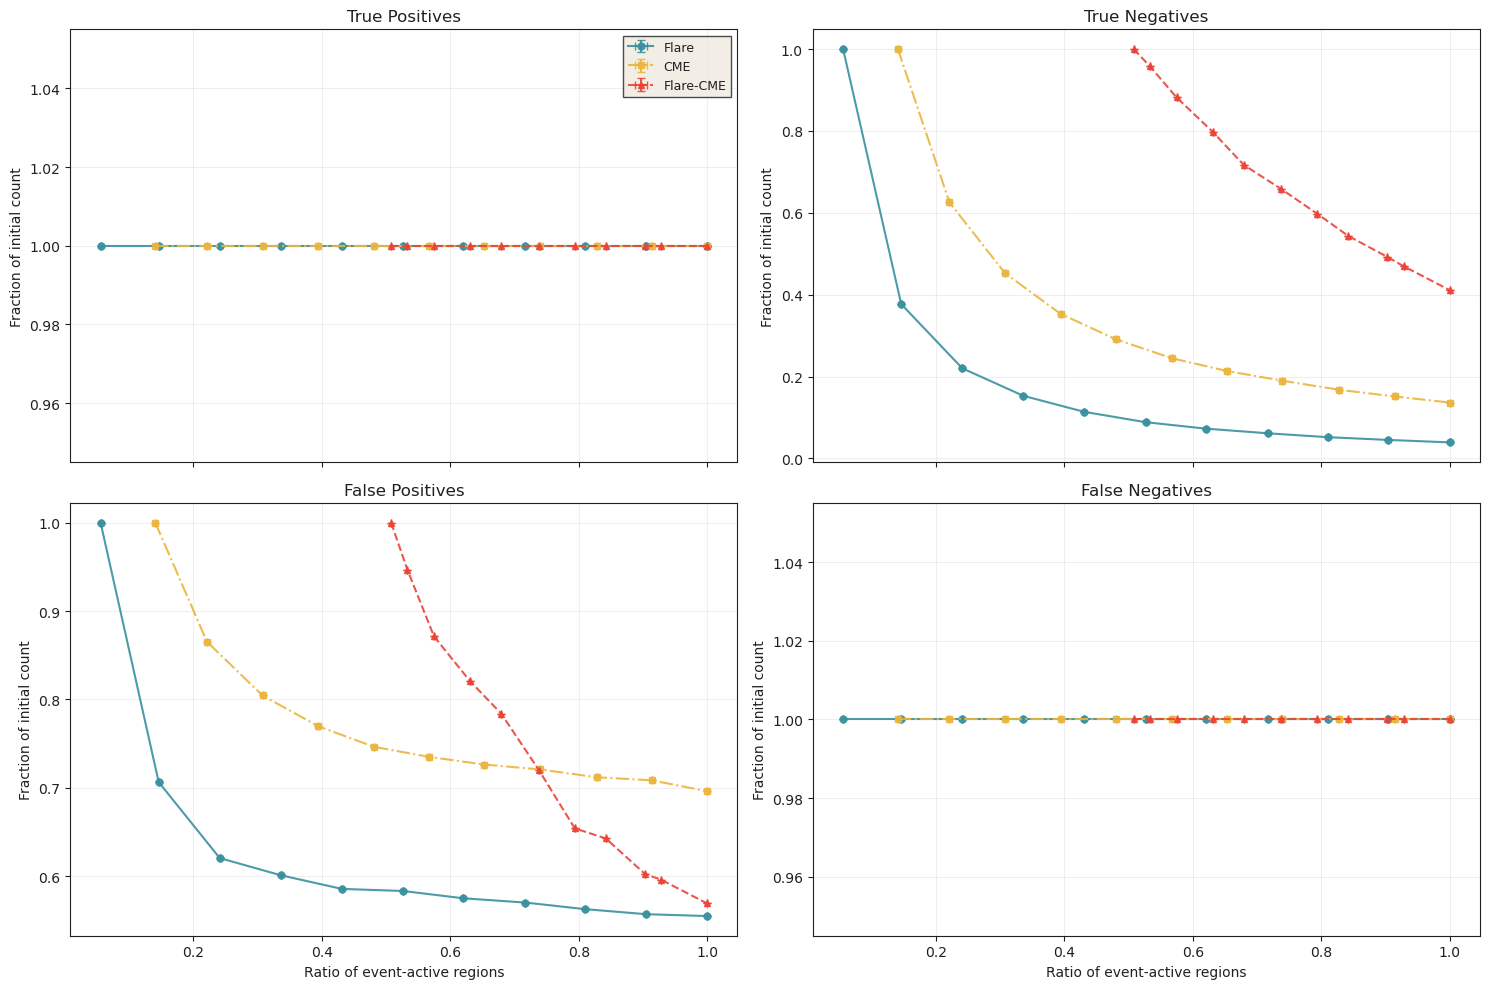

In [41]:
# ------------------------------------------------------------------
types     = ["flare", "cme", "flare_cme"]
labels    = ["Flare", "CME", "Flare-CME"]
col_map   = {"flare": colors["blue"], "cme": colors["yellow"], "flare_cme": colors["red"]}
style_map = {"flare": "-", "cme": "-.", "flare_cme": "--"}
mark_map  = {"flare": "o", "cme": "s", "flare_cme": "^"}


cm_items  = ["tp", "tn", "fp", "fn"]
titles    = ["True Positives", "True Negatives",
             "False Positives", "False Negatives"]

# =============================================================
# 2)  Four-panel figure – mean ± 1 SD counts (normalised)
# =============================================================
fig, axes = plt.subplots(2, 2, figsize=(15, 10), sharex=True)

group_stats = metrics_df.groupby(["iter", "type"]).agg(
    tp_mu=("tp", "mean"), tp_sd=("tp", "std"),
    tn_mu=("tn", "mean"), tn_sd=("tn", "std"),
    fp_mu=("fp", "mean"), fp_sd=("fp", "std"),
    fn_mu=("fn", "mean"), fn_sd=("fn", "std"),
    ratio_mu=("ratio", "mean"), ratio_sd=("ratio", "std")
).reset_index()

def err_plot(ax, x, y, xerr, yerr, typ):
    norm = y[0] or 1.0
    ax.errorbar(x, y / norm, xerr=xerr, yerr=yerr / norm,
                color=col_map[typ], linestyle=style_map[typ],
                marker=mark_map[typ], markersize=5,
                capsize=3, alpha=0.9)

for ax, cm_key, ttl in zip(axes.flat, cm_items, titles):
    for typ in types:
        sub = group_stats[group_stats["type"] == typ]
        y  = sub[f"{cm_key}_mu"].to_numpy()
        yerr = sub[f"{cm_key}_sd"].to_numpy()
        x  = sub["ratio_mu"].to_numpy()
        xerr = sub["ratio_sd"].to_numpy()
        err_plot(ax, x, y, 0, 0, typ)
    ax.set_title(ttl)
    ax.set_ylabel("Fraction of initial count")
    ax.grid(True, alpha=0.2)

for ax in axes[-1]:
    ax.set_xlabel("Ratio of event-active regions")

axes[0, 0].legend(labels, fontsize=9, frameon=True, fancybox=False,
                  facecolor=colors["beige"], edgecolor=colors["black"])
plt.tight_layout()
plt.savefig("confusion_components_vs_ratio_mean_sd.pdf", bbox_inches="tight")

findfont: Font family 'FiraCode Nerd Font' not found.
findfont: Font family 'FiraCode Nerd Font' not found.
findfont: Font family 'FiraCode Nerd Font' not found.
findfont: Font family 'FiraCode Nerd Font' not found.
findfont: Font family 'FiraCode Nerd Font' not found.
findfont: Font family 'FiraCode Nerd Font' not found.
findfont: Font family 'FiraCode Nerd Font' not found.
findfont: Font family 'FiraCode Nerd Font' not found.
findfont: Font family 'FiraCode Nerd Font' not found.
findfont: Font family 'FiraCode Nerd Font' not found.
findfont: Font family 'FiraCode Nerd Font' not found.
findfont: Font family 'FiraCode Nerd Font' not found.
findfont: Font family 'FiraCode Nerd Font' not found.
findfont: Font family 'FiraCode Nerd Font' not found.
findfont: Font family 'FiraCode Nerd Font' not found.
findfont: Font family 'FiraCode Nerd Font' not found.
findfont: Font family 'FiraCode Nerd Font' not found.
findfont: Font family 'FiraCode Nerd Font' not found.
findfont: Font family 'FiraC

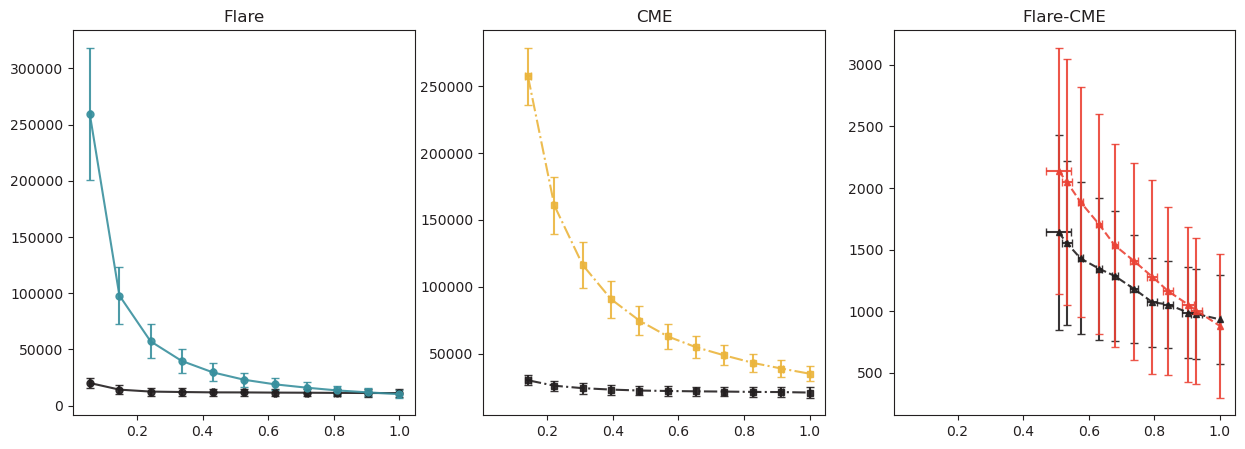

In [42]:
# Plot false positives and true negatives (in absolute value, not relative) together
# Three plots. One for each model type

fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharex=True)

for i, typ in enumerate(types):
    # Plot the count of false positives and true negatives
    sub = metrics_df[metrics_df["type"] == typ]
    ratio, fp, tn = sub.groupby("iter")[["ratio", "fp", "tn"]].mean().values.T

    ratio_sd, fp_sd, tn_sd = sub.groupby("iter")[["ratio", "fp", "tn"]].std().values.T
    ratio = ratio[~np.isnan(ratio)]

    ratio_sd = ratio_sd[~np.isnan(ratio)]

    fp = fp[~np.isnan(fp)]
    fp_sd = fp_sd[~np.isnan(fp)]
    tn = tn[~np.isnan(tn)]
    tn_sd = tn_sd[~np.isnan(tn)]
    ratio = ratio[:len(fp)]
    ratio_sd = ratio_sd[:len(fp)]
    ratio = ratio[:len(tn)]
    ratio_sd = ratio_sd[:len(tn)]
    # Plot the data manually

    ax = axes[i]
    ax.errorbar(ratio, fp, xerr=ratio_sd, yerr=fp_sd,
                color=colors["black"], linestyle=style_map[typ],
                marker=mark_map[typ], markersize=5,
                capsize=3, alpha=0.9, label="FP")

    ax.errorbar(ratio, tn, xerr=ratio_sd, yerr=tn_sd,
                color=col_map[typ], linestyle=style_map[typ],
                marker=mark_map[typ], markersize=5,
                capsize=3, alpha=0.9, label="TN")

    ax.set_title(labels[i])


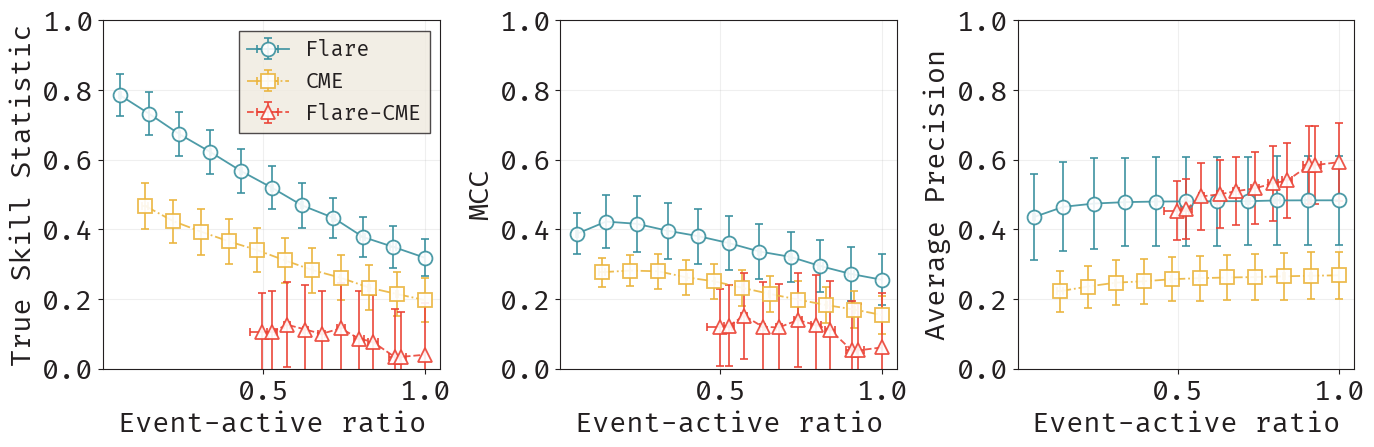

In [63]:
# =============================================================
# 1.  Three-panel figure  (mean ± 1 SD)    –  TSS • MCC • Avg-Precision
#      pulls stats directly from `metrics_df`
# =============================================================
fig, axes = plt.subplots(1, 3,
                         figsize=(2 * twocolumn, 0.66 * twocolumn),
                         sharex=True)

# -------------------------------------------------------------
# compute mean and SD on-the-fly
# -------------------------------------------------------------
stats = (
    metrics_df
    .groupby(["iter", "type"])
    .agg(ratio_mu=("ratio", "median"),  ratio_sd=("ratio", "std"),
         tss_mu=("tss", "median"),      tss_sd=("tss", "std"),
         mcc_mu=("mcc", "median"),      mcc_sd=("mcc", "std"),
         ap_mu=("ap", "median"),        ap_sd=("ap", "std"))
    .reset_index()
)

types   = ["flare", "cme", "flare_cme"]
labels  = ["Flare", "CME", "Flare-CME"]
col_map = {"flare": colors["blue"], "cme": colors["yellow"], "flare_cme": colors["red"]}
style   = {"flare": "-", "cme": "-.", "flare_cme": "--"}
mark    = {"flare": "o", "cme": "s", "flare_cme": "^"}

def eb(ax, x, y, xerr, yerr, typ, lab=None):
    ax.errorbar(x, y, xerr=xerr, yerr=yerr,
                color=col_map[typ], linestyle=style[typ], marker=mark[typ],
                markersize=10, markerfacecolor="white", markeredgewidth=1.3,
                capsize=3, linewidth=1.3, alpha=0.9, label=lab)

metric_keys = [("tss", "True Skill Statistic"),
               ("mcc", "MCC"),
               ("ap",  "Average Precision")]

for ax, (mkey, ylabel) in zip(axes, metric_keys):
    for typ, lab in zip(types, labels):
        sub = stats[stats["type"] == typ]
        eb(ax,
           sub["ratio_mu"], sub[f"{mkey}_mu"],
           sub["ratio_sd"], sub[f"{mkey}_sd"],
           typ, lab if mkey == "tss" else None)
    ax.set_ylabel(ylabel)
    ax.grid(True, alpha=0.2)
    if mkey == "tss":
        ax.set_ylim(0, 0.9)

for ax in axes:
    ax.set_xlabel("Event-active ratio")


axes[0].legend(fontsize=15, frameon=True, fancybox=False,
               facecolor=colors["beige"], edgecolor=colors["black"])

for ax in axes:
    ax.set_ylim(0,1)
    ax.tick_params(axis='both', which='major', labelsize=20)
    ax.xaxis.label.set_size(20)
    ax.yaxis.label.set_size(20)

plt.tight_layout()
plt.savefig("active_regions_metrics_mean_sd.pdf", bbox_inches="tight")


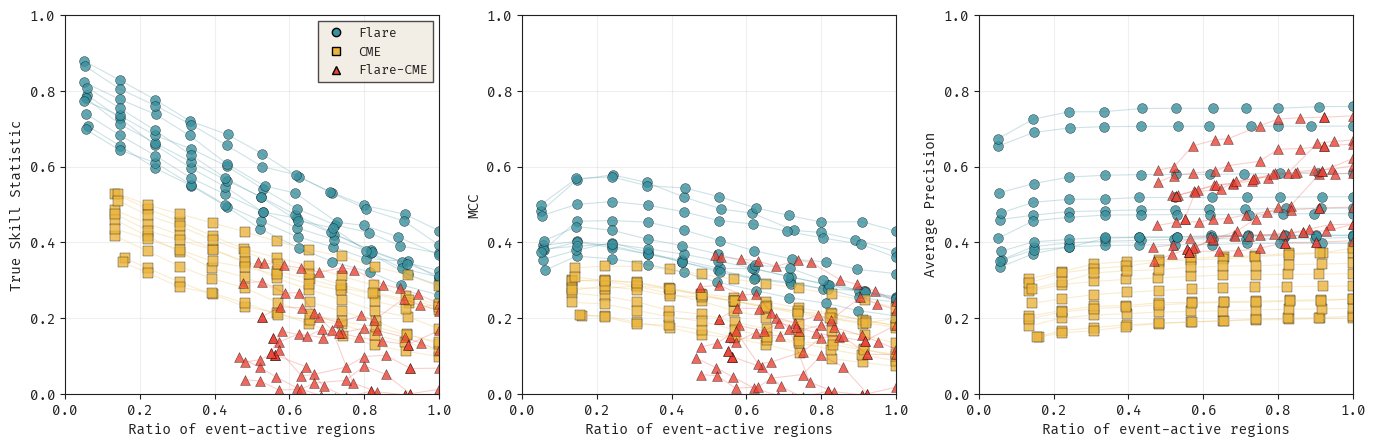

In [44]:

# =============================================================
# 2.  Scatter figure of all 10 CV runs  –  TSS • MCC • AP
# =============================================================
fig, axes = plt.subplots(1, 3,
                         figsize=(2 * twocolumn, 0.66 * twocolumn),
                         sharex=True)

def scatter_runs(ax, df_type, metric_col, typ):
    for rid, sub in df_type.groupby("run_id"):
        sub = sub.sort_values("iter")
        ax.plot(sub["ratio"], sub[metric_col],
                color=col_map[typ], alpha=0.25, linewidth=0.8)
        ax.scatter(sub["ratio"], sub[metric_col],
                   color=col_map[typ], marker=mark[typ], s=50,
                   alpha=0.8, edgecolor="black", linewidth=0.3)

# panel definitions
panels = [("tss", "True Skill Statistic"),
          ("mcc", "MCC"),
          ("ap",  "Average Precision")]

for ax, (mkey, ylabel) in zip(axes, panels):
    for typ in types:
        scatter_runs(ax,
                     metrics_df[metrics_df["type"] == typ],
                     mkey, typ)
    ax.set_ylabel(ylabel)
    if mkey == "tss":
        ax.set_ylim(0, 0.9)
    ax.grid(True, alpha=0.2)

for ax in axes:
    ax.set_xlabel("Ratio of event-active regions")

# legend
from matplotlib.lines import Line2D
handles = [Line2D([0], [0], color=col_map[t], marker=mark[t], linestyle="",
                  markersize=6, markeredgecolor="black", label=l)
           for t, l in zip(types, labels)]
axes[0].legend(handles=handles, fontsize=9, frameon=True,
               fancybox=False, facecolor=colors["beige"], edgecolor=colors["black"])


# Set limits of all from 0 to 1

for ax in axes:
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)

plt.tight_layout()
plt.savefig("active_regions_metrics_all_runs.pdf", bbox_inches="tight")

# Reliability diagrams

In [45]:
# =============================================================
# Reliability-diagram data for every run_id and forecast type
#   • 10 equal-width probability bins
#   • output:  DataFrame  `reliab_df`
#       columns: run_id • type • bin_lower • bin_upper •
#                bin_center • count • mean_pred • event_rate
# =============================================================
import numpy as np
import pandas as pd

# ------------------------------------------------------------------
# Settings
# ------------------------------------------------------------------
bin_edges   = np.linspace(0.0, 1.0, 11)           # 10 bins
bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])

# ------------------------------------------------------------------
# Forecast definitions   (pred-col , target-col)
# ------------------------------------------------------------------
forecast_meta = {
    "flare":     ("flare_pred",     "flare_target"),
    "cme":       ("cme_pred",       "cme_target"),
    "flare_cme": ("flare_cme_pred", "flare_cme_target"),
}

# working copy of full data (no trimming)
df_full = data.copy()

rows = []

# ------------------------------------------------------------------
# Loop over runs and forecast types
# ------------------------------------------------------------------
for rid in df_full["run_id"].unique():
    run_data = df_full[df_full["run_id"] == rid]

    for ftype, (pcol, tcol) in forecast_meta.items():
        sub = run_data[[pcol, tcol]].dropna()      # remove NaNs
        if sub.empty:
            continue

        preds  = sub[pcol].to_numpy()
        events = sub[tcol].to_numpy().astype(int)

        # bin membership (0…9)
        bin_idx = np.digitize(preds, bin_edges[1:-1], right=False)

        # iterate over bins
        for b in range(len(bin_centers)):
            idx = bin_idx == b
            n   = idx.sum()
            if n == 0:
                continue

            mean_pred  = preds[idx].mean()
            event_rate = events[idx].mean()

            rows.append({
                "run_id":     rid,
                "type":       ftype,
                "bin_lower":  bin_edges[b],
                "bin_upper":  bin_edges[b+1],
                "bin_center": bin_centers[b],
                "count":      n,
                "mean_pred":  mean_pred,
                "event_rate": event_rate,
            })

# ------------------------------------------------------------------
# Final reliability-diagram DataFrame
# ------------------------------------------------------------------
reliab_df = pd.DataFrame(rows)
# reliab_df.head()


In [46]:
reliab_df

,run_id,type,bin_lower,bin_upper,bin_center,count,mean_pred,event_rate
0,0,flare,0.0,0.1,0.05,256987,0.013427,0.000366
1,0,flare,0.1,0.2,0.15,11351,0.142136,0.032332
2,0,flare,0.2,0.3,0.25,6968,0.248168,0.032147
3,0,flare,0.3,0.4,0.35,6766,0.351295,0.054242
4,0,flare,0.4,0.5,0.45,6892,0.447908,0.033662
...,...,...,...,...,...,...,...,...
290,9,flare_cme,0.5,0.6,0.55,747,0.543517,0.322624
291,9,flare_cme,0.6,0.7,0.65,951,0.650296,0.245005
292,9,flare_cme,0.7,0.8,0.75,588,0.756508,0.078231
293,9,flare_cme,0.8,0.9,0.85,1539,0.849675,0.311241


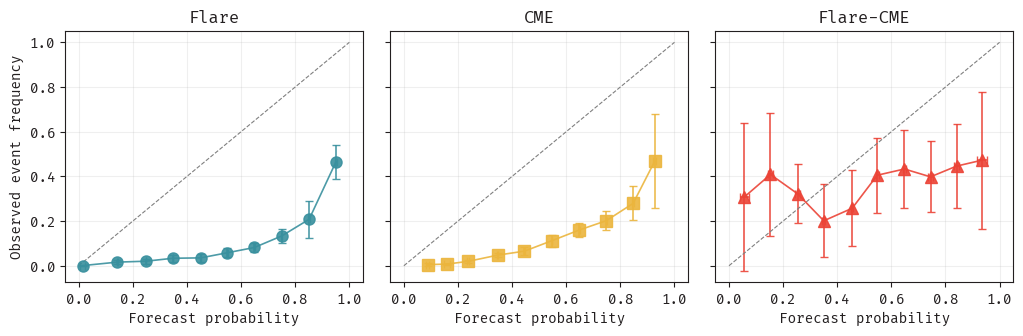

In [47]:
# =============================================================
# Reliability diagrams (mean ± 1 SD across the 10 runs)
#   • Three panels: Flare, CME, Flare-CME
#   • x-axis = mean predicted probability (per bin, per run)
#   • y-axis = observed event rate
#   • error bars:  SD of x and y across runs
# =============================================================
import matplotlib.pyplot as plt
import numpy as np

types   = ["flare", "cme", "flare_cme"]
titles  = ["Flare", "CME", "Flare-CME"]
col_map = {"flare": colors["blue"], "cme": colors["yellow"], "flare_cme": colors["red"]}
mark    = {"flare": "o", "cme": "s", "flare_cme": "^"}

fig, axes = plt.subplots(1, 3, figsize=(3 * onecolumn, onecolumn), sharey=True)

# -------------------------------------------------------------
# compute mean ± SD for each bin & type
# -------------------------------------------------------------
stat_rows = []
for typ in types:
    sub = reliab_df[reliab_df["type"] == typ]
    g   = sub.groupby("bin_center")
    for c in sorted(g.groups):
        grp = g.get_group(c)
        stat_rows.append({
            "type": typ,
            "bin_center": c,
            "mx": grp["mean_pred"].mean(),
            "sx": grp["mean_pred"].std(),
            "my": grp["event_rate"].mean(),
            "sy": grp["event_rate"].std()
        })

stat_df = pd.DataFrame(stat_rows)

# -------------------------------------------------------------
# plot for each forecast type
# -------------------------------------------------------------
for ax, typ, ttl in zip(axes, types, titles):
    sd = stat_df[stat_df["type"] == typ].sort_values("bin_center")

    ax.errorbar(sd["mx"], sd["my"],
                xerr=sd["sx"], yerr=sd["sy"],
                color=col_map[typ], marker=mark[typ], markersize=8,
                linestyle="-", capsize=3, linewidth=1.2, alpha=0.9,
                label="Mean ±1 SD")

    # 45-degree reference line
    ax.plot([0, 1], [0, 1], color="gray", linewidth=0.8, linestyle="--")

    ax.set_title(ttl)
    ax.set_xlabel("Forecast probability")
    ax.grid(True, alpha=0.2)

axes[0].set_ylabel("Observed event frequency")

plt.tight_layout()
plt.savefig("reliability_diagrams_mean_sd.pdf", bbox_inches="tight")


# Distribution of predictions

In [5]:
preds_path = "../out/main_predictions.db"

conn = sqlite3.connect(preds_path)
cur = conn.cursor()

for table in ["flare_forecast", "cme_forecast", "flare_cme_assoc"]:
    cur.execute(f"CREATE INDEX IF NOT EXISTS {table}_harpnum_idx ON {table}_rotary_transformer_24_predictions (harpnum)")
    cur.execute(f"CREATE INDEX IF NOT EXISTS {table}_run_id_idx ON {table}_rotary_transformer_24_predictions (run_id)")

# Attach ../data/features.db

cur.execute("ATTACH DATABASE '../data/features.db' AS features")

# Delete temp view if exists
cur.execute("DROP TABLE IF EXISTS combined_forecasts")

cur.executescript("""
CREATE INDEX IF NOT EXISTS idx_flare_forecast ON flare_forecast_rotary_transformer_24_predictions(run_id, harpnum, start);
CREATE INDEX IF NOT EXISTS idx_cme_forecast ON cme_forecast_rotary_transformer_24_predictions(run_id, harpnum, start);
CREATE INDEX IF NOT EXISTS idx_flare_cme_assoc ON flare_cme_assoc_rotary_transformer_24_predictions(run_id, harpnum, start);

CREATE TEMP TABLE IF NOT EXISTS combined_forecasts AS
WITH unique_keys AS (
    SELECT run_id, harpnum, start, end FROM flare_forecast_rotary_transformer_24_predictions
    UNION
    SELECT run_id, harpnum, start, end FROM cme_forecast_rotary_transformer_24_predictions
    UNION
    SELECT run_id, harpnum, start, end FROM flare_cme_assoc_rotary_transformer_24_predictions
),
baselines AS (
                  SELECT 
                  harpnum, 
                  MAX(has_flare_above_threshold) AS baseline_flare,
                  MAX(MAX(has_cme_flare_above_threshold), MAX(has_cme_flare_below_threshold), MAX(has_cme_no_flare)) AS baseline_cme,
                  MAX(has_cme_flare_above_threshold) AS baseline_cme_flare
                  FROM features.T_24_L_24_S_0_2_B_0_OVERLAPS_1_MIN_FLARE_30_dataset
                  GROUP BY harpnum
),
combined_data AS (
    SELECT 
        uk.run_id, 
        uk.harpnum, 
        uk.start,
        uk.end,
        f.pred AS flare_pred, f.target AS flare_target,
        c.pred AS cme_pred, c.target AS cme_target,
        fc.pred AS flare_cme_pred, fc.target AS flare_cme_target,
        s.baseline_cme as base_cme_pred,
        s.baseline_cme_flare as base_flare_cme_pred,
        s.baseline_flare as base_flare_pred
    FROM unique_keys uk
    LEFT JOIN flare_forecast_rotary_transformer_24_predictions f ON uk.run_id = f.run_id AND uk.harpnum = f.harpnum AND uk.start = f.start
    LEFT JOIN cme_forecast_rotary_transformer_24_predictions c ON uk.run_id = c.run_id AND uk.harpnum = c.harpnum AND uk.start = c.start
    LEFT JOIN flare_cme_assoc_rotary_transformer_24_predictions fc ON uk.run_id = fc.run_id AND uk.harpnum = fc.harpnum AND uk.start = fc.start
    INNER JOIN baselines s ON uk.harpnum = s.harpnum
)
SELECT * FROM combined_data;
""")

In [6]:
data = pd.read_sql("""
SELECT * FROM combined_forecasts
                    """, conn)

NameError: name 'thresholds' is not defined

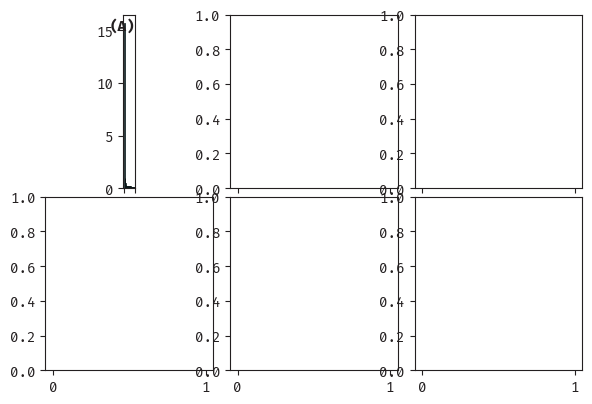

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize, LinearSegmentedColormap
from matplotlib.cm import ScalarMappable
from matplotlib.lines import Line2D
import matplotlib.patches as patches

bins = np.arange(0, 1.01, 0.05)

flare_data = data[~data["flare_target"].isna()].copy()
cme_data = data[~data["cme_target"].isna()].copy()
flare_cme_data = data[~data["flare_cme_target"].isna()].copy()

flare_active_data = flare_data[flare_data["base_flare_pred"] == 1]
cme_active_data = cme_data[cme_data["base_cme_pred"] == 1]
flare_cme_active_data = flare_cme_data[flare_cme_data["base_flare_cme_pred"] == 1]


fig, axes = plt.subplots(2, 3, figsize=(twocolumn, 2 * twocolumn/3), sharex=True, sharey=False, gridspec_kw={"hspace": 0.05, "wspace": 0.1})

# Calculate global TSS range for consistent color mapping across plots
all_tss_values = []

# Define colormap normalization
norm = Normalize(vmin=0, vmax=0.85)
cmap = LinearSegmentedColormap.from_list("custom", ["white", colors["green"]])

# Make a custom colormap going from white to colors["orange"]
ylims = {}

letters = ["A", "B", "C", "D", "E", "F"]
m = 0

for j, all_data in enumerate([[flare_data, cme_data, flare_cme_data], [flare_active_data, cme_active_data, flare_cme_active_data]]):
    for i, (forecast_data, title) in enumerate(zip(all_data, ["Flare", "CME", "Flare-CME"])):
        ax = axes[j,i]
        ax.set_aspect('equal')
        column = f"{title.replace('-', '_').lower()}"

        # Put the letter on top right of plot
        # Anchor top right of text
        ax.text(0.99,0.98, f"({letters[m]})", transform=ax.transAxes, horizontalalignment='right', verticalalignment='top', fontsize=10, fontweight='bold')
        m += 1

        # Plot histograms
        for target in [0, 1]:
            target_data = forecast_data[forecast_data[f"{column}_target"] == target]
            if target == 1:
                alpha = 0.6
            else:
                alpha = 1
            ax.hist(target_data[f"{column}_pred"], bins=bins, alpha=alpha, color=colors["yellow"] if target == 1 else colors["blue"], edgecolor="black", linewidth=0.5, density=True)
            # Plot the threshold
            ax.axvline(thresholds[column], color=colors["black"], linestyle="--", linewidth=1)

            if j == 0:
                ylims[column] = ax.get_ylim()
            else:
                ax.set_ylim(ylims[column])
            
            original_y_max = ax.get_ylim()[1]
        
        # Plot background TSS value coloring
        tss_thresholds = np.arange(0, 1.01, 0.01)
        tss_values = vectorized_true_skill_statistic(forecast_data[f"{column}_target"], forecast_data[f"{column}_pred"], tss_thresholds)
        all_tss_values.extend(tss_values)
        # Create a continuous background color image based on TSS values
        ax.imshow(np.tile(tss_values, (100, 1)), aspect='auto', extent=[0, 1, 0, original_y_max], origin='lower', cmap=cmap, alpha=0.9, zorder=-1, norm=norm)
        
        if j == 0:
            ax.set_title(title)
        #ax.set_xlabel("Prediction")
        ax.set_xlim(0, 1)

        # Remove every tick and label from y axis
        ax.set_yticks([])

axes[0,0].set_ylabel("Probability Density")
axes[1,0].set_ylabel("Probability Density")

for ax in axes[1,:]:
    # Set xticks to 0, 0.25, 0.5, 0.75, 1
    # But for 0 and 1 no decimals
    ax.set_xticks(np.arange(0, 1.01, 0.25))
    ax.set_xticklabels([f"{x:.0f}" if x in [0, 1] else f"{x:.2f}" for x in np.arange(0, 1.01, 0.25)]) 
    ax.set_xlabel("Prediction")

# plt.tight_layout()

# Adjustments for adding the vertical lines and text
for j, label in enumerate(["All regions", "Event active only"]):
    ax = axes[j, 0]  # Reference to the first plot in each row
    # Use Line2D to draw a vertical line
    # Drawing a line with annotate
    ax.annotate('', xy=(-0.2, 0), xytext=(-0.2 , 1), xycoords='axes fraction', 
                textcoords='axes fraction', arrowprops=dict(arrowstyle="-", color="black"))
    
    # Add vertical text aligned with the line. Adjust x and y values for positioning.
    ax.text(-0.3, 0.5, label, rotation=90, transform=ax.transAxes, verticalalignment='center', horizontalalignment='left', fontweight='bold')

# Adjust layout to accommodate the new text elements
# plt.tight_layout(rect=[0.05, 0, 0.95, 1])

# Create a colorbar with the same normalization and colormap
fig.subplots_adjust(right=0.90)
cbar_ax = fig.add_axes([0.92, 0.1, 0.01, 0.8])  # Adjust the position and size as needed
sm = ScalarMappable(norm=norm, cmap=cmap)
fig.colorbar(sm, cax=cbar_ax, label='TSS Value')

# Now need a manual legend
# A blue bar for "Predictions for label 0" and a yellow bar for "Predictions for label 1
# Then a dashed line for the threshold

# Create custom legend handles using rectangles for bars
legend_elements = [
    patches.Patch(facecolor=colors["blue"], edgecolor='black', linewidth=0.5, label='Predictions for label 0'),
    patches.Patch(facecolor=colors["yellow"], edgecolor='black', linewidth=0.5, label='Predictions for label 1'),
    Line2D([0], [0], color=colors["black"], lw=1, linestyle='--', label='Threshold')
]

# Place the legend on the figure
fig.legend(handles=legend_elements, ncol=3, bbox_to_anchor=(0.51, -0.06), loc='lower center', fancybox=False, facecolor=colors["beige"], edgecolor=colors["black"])
plt.savefig("predictions_distributions.pdf", bbox_inches="tight")

plt.show()


print(min(all_tss_values), max(all_tss_values))


# Plot example region predictions

In [12]:
import matplotlib.dates as mdates
from matplotlib.lines import Line2D

thresholds = {
    "flare": 0.5,
    "cme": 0.5,
    "flare_cme": 0.5
}

def plot_region_cmes(harpnums, sidetitles, events, sharex=False, highlight_span_of=None, mode="row"):
    if len(harpnums) != len(sidetitles):
        raise ValueError("harpnums and sidetitles must have the same length")

    n = len(harpnums)
    
    if mode == "row":
        fig, axes = plt.subplots(1, n, figsize=(twocolumn, twocolumn/3), sharey=True, sharex=sharex, gridspec_kw={"wspace": 0.2})
    elif mode =="column":
        fig, axes = plt.subplots(n, 1, figsize=(onecolumn, n * onecolumn), sharex=True, sharey=False, gridspec_kw={"hspace": 0.2})
    else:
        raise ValueError("mode must be either 'row' or 'column'")

    for i, harpnum in enumerate(harpnums):
        ax = axes[i]
        hdata = data[data["harpnum"] == harpnum].copy()

        hruns = hdata["run_id"].unique()

        hdata = hdata[hdata["run_id"] == hruns[0]]

        hdata["end"] = pd.to_datetime(hdata["end"])

        dates, predictions, labels = hdata[["end", f"{events[i]}_pred", f"{events[i]}_target"]].dropna().values.T

        if highlight_span_of == i:
            span_start, span_end = dates.min(), dates.max()

        ax.plot(dates, labels, color=colors["blue"], linewidth=2, solid_capstyle='round')
        ax.plot(dates, predictions, color=colors["yellow"], linewidth=2, solid_capstyle='round')

        ax.set_title(f"{sidetitles[i]}", fontsize=10, rotation=-90,ha='left', va='top', y=0.96, x=1.01)

        # Set secondary title
        ax.text(0, 1.01, f"HARPNUM: {harpnum}", transform=ax.transAxes, horizontalalignment='left', verticalalignment='bottom', fontsize=10, fontweight='bold')

        # Plot threshold
        ax.axhline(thresholds[f"{events[i]}"], color=colors["black"], linestyle="--", linewidth=2, zorder=-1)


    # Format to one day

    for ax in axes:
        ax.set_ylim(-0.05,1.05)


        if highlight_span_of:
            ax.axvspan(span_start, span_end, color=colors["black"], alpha=0.1, zorder=-1)

        ax.xaxis.set_major_locator(mdates.DayLocator(interval=1))
        ax.xaxis.set_major_formatter(mdates.DateFormatter("%m-%d"))

        plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha="right")

        ax.set_xticklabels([])


    # Set y ticks to 0, threshold, 1
    # Format to 2 decimal places
    if mode == "row":
        ticks = [0] + [thresholds[event] for event in set(events)] + [1]
        axes[0].set_yticks(ticks)
        axes[0].set_yticklabels([f"{x:.2f}" if x not in [0,1] else f"{x}" for x in ticks])
    else:
        for i in range(n):
            ticks = [0, thresholds[events[i]], 1]
            axes[i].set_yticks(ticks)
            axes[i].set_yticklabels([f"{x:.2f}" if x not in [0,1] else f"{x}" for x in ticks])


    # Now need a manual legend
    legend_elements = [
        Line2D([0], [0], color=colors["blue"], lw=2, label='Target'),
        Line2D([0], [0], color=colors["yellow"], lw=2, label='Prediction'),
        Line2D([0], [0], color=colors["black"], lw=2, linestyle='--', label='Threshold')
    ]

    if mode == "row":
        ncol = 3
        pos = (0.5, -0.1)
    else:
        ncol = 1
        pos = (0.5, -0.05)

    # In first ax put ylabel Prediction
    axes[0].set_ylabel("Prediction", fontsize=10, labelpad=10)
    # Place the legend on the figure
    fig.legend(handles=legend_elements, ncol=ncol, bbox_to_anchor=pos, loc='lower center', fancybox=False, facecolor=colors["beige"], edgecolor=colors["black"])


    return fig

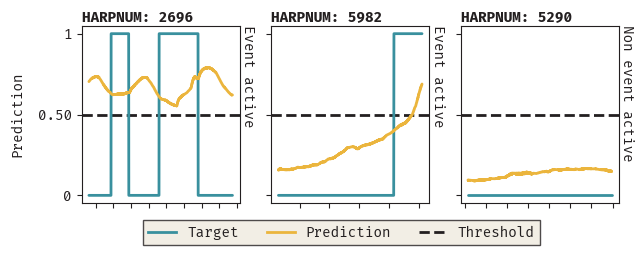

In [13]:
fig = plot_region_cmes([2696, 5982, 5290], ["Event active", "Event active", "Non event active"], ["cme", "cme", "cme"])


plt.savefig("cme_predictions_example.pdf", bbox_inches="tight")

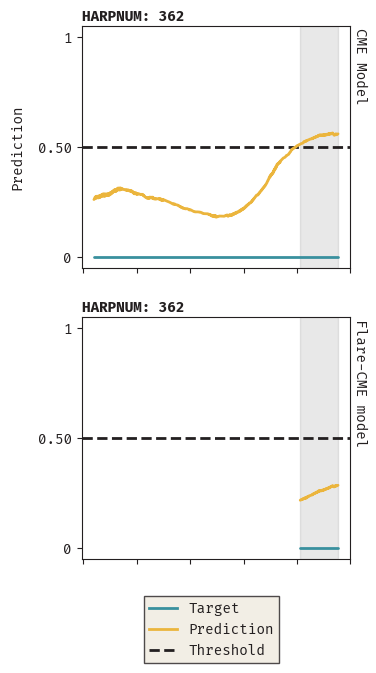

In [14]:
fig = plot_region_cmes([362, 362], ["CME Model", "Flare-CME model"], ["cme", "flare_cme"], sharex=True, highlight_span_of=1, mode="column")

# Class imbalance vs event active ratio

In [56]:
import numpy as np

# ============================================================================
#  EXACT transcription of Eqs. (10)–(21)  —  Guastavino et al., 2024
# ============================================================================

def _psi(y, i, K):
    """
    ψ(yi,pi) — Eqs. (14)-(17)  &  (10)                
    Weight for a False Positive at index i.
    """
    # full symmetric window   I_{i,K}                 (Eq. 13)
    window = y[max(0, i-K) : min(len(y), i+K+1)]

    # (a)  no event at all in the window  →  ψ = 2     (Eq. 14)
    if np.all(window == 0):
        return 2.0

    # (b)  at least one event in window -------------- (Eq. 15)
    #      find the nearest *future* event to i
    for k in range(1, K+1):
        if i + k < len(y) and y[i+k] == 1:
            return 1.0 - 1.0/(k+1)                    # ½ ≤ ψ < 1  (Eq. 17)

    # (i) only past events inside the window           (Eq. 16)
    return 1.0


def _phi(p, i, K):
    """
    φ(yi,pi) — Eqs. (18)-(21)  &  (12)               
    Weight for a False Negative at index i.
    """
    # full symmetric window   I_{i,K}                 (Eq. 13)
    window = p[max(0, i-K) : min(len(p), i+K+1)]

    # (a)  no alarm at all in the window  →  φ = 2     (Eq. 18)
    if np.all(window == 0):
        return 2.0

    # (b)  at least one alarm in window -------------- (Eq. 19)
    #      find the nearest *past* alarm to i
    for k in range(1, K+1):
        if i - k >= 0 and p[i-k] == 1:
            return 1.0 - 1.0/(k+1)                    # ½ ≤ φ < 1  (Eq. 21)

    # (i) only future alarms inside the window         (Eq. 20)
    return 1.0


def value_weighted_confusion(y_true, y_pred, K=3):
    """
    Value-weighted confusion matrix C̃ (Eqs. 6–7).     :contentReference[oaicite:2]{index=2}
    Returns wTP, wFP, wFN, wTN.
    """
    y = np.asarray(y_true, dtype=int)
    p = np.asarray(y_pred, dtype=int)
    if y.shape != p.shape:
        raise ValueError("y_true and y_pred must have the same length")

    # diagonals — identical to the classical counts     (Eq. 6)
    wTP = float(np.sum((y == 1) & (p == 1)))
    wTN = float(np.sum((y == 0) & (p == 0)))

    # off-diagonals — value-weighted sums               (Eq. 7)
    wFP, wFN = 0.0, 0.0
    for i in range(len(y)):
        if y[i] == 0 and p[i] == 1:                    # FP
            wFP += _psi(y, i, K)
        elif y[i] == 1 and p[i] == 0:                  # FN
            wFN += _phi(p, i, K)

    return wTP, wFP, wFN, wTN

left
Class imbalance: 14.0
Event active ratio: 0.2222222222222222
right
Class imbalance: 14.0
Event active ratio: 0.6666666666666666


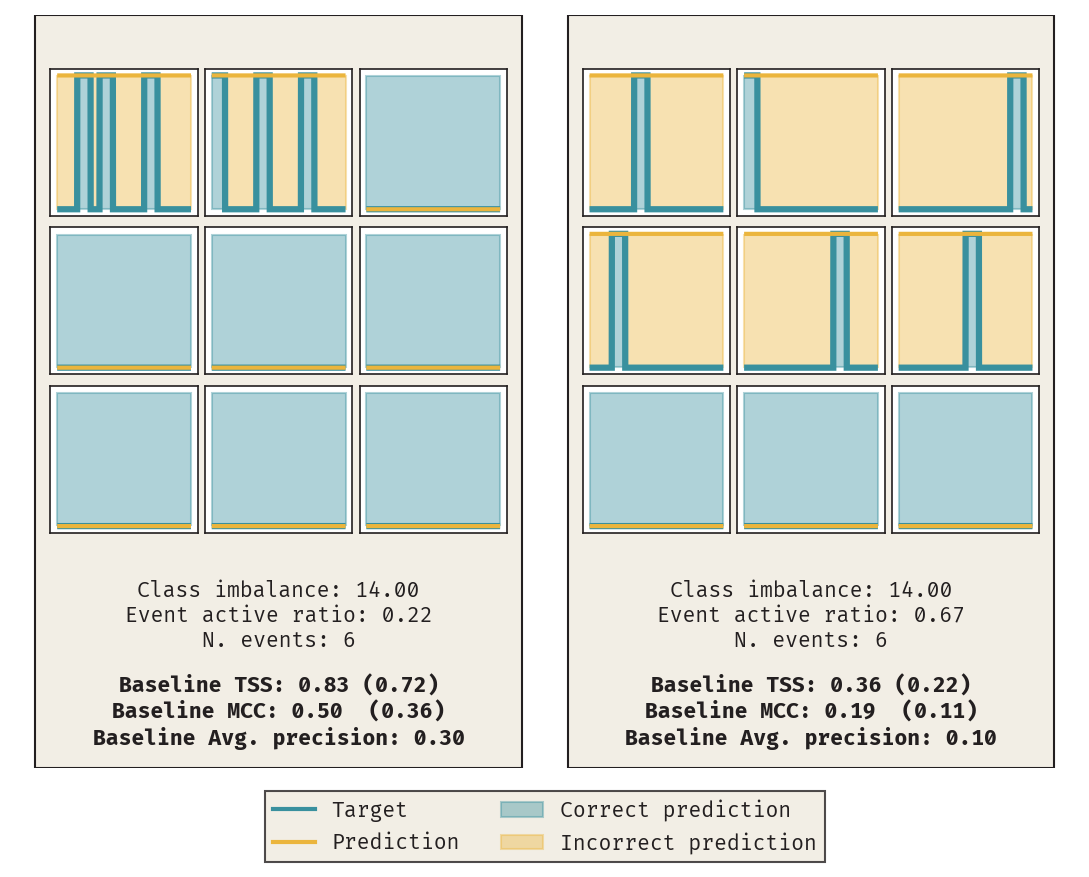

In [57]:
from sklearn.metrics import (
    confusion_matrix,
    matthews_corrcoef,
    average_precision_score
)
# ------------------------------------------------------------------
#  Weighted skill scores
# ------------------------------------------------------------------
def weighted_tss_mcc(y_true, y_pred, K=3):
    """
    Return the value-weighted versions of
        * TSS  (True-Skill Statistic)
        * MCC  (Matthews-Correlation Coefficient)

    Parameters
    ----------
    y_true, y_pred : 1-D array-likes of shape (n_samples,)
                     binary labels / predictions (0-1 or bool)
    K              : int, temporal window for the value weighting

    Returns
    -------
    wTSS, wMCC : floats
    """
    wTP, wFP, wFN, wTN = value_weighted_confusion(y_true, y_pred, K)

    # ---- weighted TSS -------------------------------------------------
    wTSS = (wTP / (wTP + wFN) if (wTP + wFN) else 0.0) - \
           (wFP / (wFP + wTN) if (wFP + wTN) else 0.0)

    # ---- weighted MCC -------------------------------------------------
    denom = np.sqrt((wTP + wFP) * (wTP + wFN) *
                    (wTN + wFP) * (wTN + wFN))
    wMCC  = (wTP * wTN - wFP * wFN) / denom if denom else 0.0

    return wTSS, wMCC

from matplotlib.patches import Rectangle
import matplotlib.colors as mcolors
np.random.seed(410112)
# Import Line2D
from matplotlib.lines import Line2D

def mix_colors(color1, color2, alpha=0.5):
    """
    Mix two colors together.
    
    Parameters:
    - color1: The first color. Any format recognized by matplotlib (e.g., name, hex, RGB).
    - color2: The second color. Any format recognized by matplotlib.
    - alpha: The weight of the first color. 1.0 will be all color1, 0.0 will be all color2.
    
    Returns: The mixed color.
    """
    # Convert colors to RGBA format
    c1 = mcolors.to_rgba(color1)
    c2 = mcolors.to_rgba(color2)
    
    # Mix the colors
    mix = [alpha * c1[i] + (1 - alpha) * c2[i] for i in range(4)]
    return mix

N_events = 6
N_event_active_left = 2
N_event_active_rigth = 6
N_event_active = {
    "left": N_event_active_left,
    "right": N_event_active_rigth
}
N_points_per_region = int(10 * 24 / 0.2)
N_points_per_event = int(24 / 0.2)

fig = plt.figure(figsize=(twocolumn, twocolumn / 2), dpi=150)
subfig1, subfig2 = fig.subfigures(1, 2, wspace=0.05)

fixed_sep = 0.05  # Fixed separation value, for example, 2% of figure size
pad = 0.05
subfig1.subplots_adjust(left=pad, right=1-pad, top=1-pad, bottom=pad, wspace=fixed_sep, hspace=fixed_sep)
subfig2.subplots_adjust(left=pad, right=1-pad, top=1-pad, bottom=pad, wspace=fixed_sep, hspace=fixed_sep)

# Choose your background color
bg_color1 = mix_colors(colors["beige"], "white", 0.8)
bg_color2 = mix_colors(colors["beige"], "white", 0.8)

# 1)  Declare once, near the top of the script
#     (all values are FRACTIONS of the sub-figure width / height)
# ------------------------------------------------------------------
box_pad_x       = 0.02   # grow/shrink box sideways   (0.02 ➜ 2 % on each side)
box_pad_bottom  = 0.4   # how far below plots the box extends
box_pad_top     = 0.05   # how far above plots the box extends
# ------------------------------------------------------------------

# ------------------------------------------------------------------
# 2)  When you CREATE the background axes (optional)
#     — make them span the *same* enlarged area so clicking the box
#       still selects it in interactive backends:
# ------------------------------------------------------------------
background_ax1 = subfig1.add_axes(
    [-box_pad_x, -box_pad_bottom,
     1 + 2*box_pad_x, 1 + box_pad_bottom + box_pad_top],
    zorder=-1
)
background_ax2 = subfig2.add_axes(
    [-box_pad_x, -box_pad_bottom,
     1 + 2*box_pad_x, 1 + box_pad_bottom + box_pad_top],
    zorder=-1
)

#  … then immediately switch them off
for bax in (background_ax1, background_ax2):
    bax.axis('off')

# ------------------------------------------------------------------
# 3)  Draw the rectangles with the SAME padding numbers
# ------------------------------------------------------------------
for subfig, bax, face in [
        (subfig1, background_ax1, bg_color1),
        (subfig2, background_ax2, bg_color2)]:

    bax.add_patch(
        Rectangle(
            (0.0 + box_pad_x, -box_pad_bottom),            # (x0, y0)
            1.0 - 2*box_pad_x,                             # width
            1.0 + box_pad_bottom + box_pad_top,            # height
            transform=subfig.transSubfigure,               # <- key line
            facecolor=face,
            edgecolor=colors["black"],
            zorder=-1
        )
    )

axes1 = subfig1.subplots(3, 3, sharex=True, sharey=True)
axes2 = subfig2.subplots(3, 3, sharex=True, sharey=True)


# Make every subplot have equal aspect ratio
# And remove all ticks

for ax in axes1.flat:
    ax.set_aspect('equal')
    ax.set_xticks([])
    ax.set_yticks([])

for ax in axes2.flat:
    ax.set_aspect('equal')
    ax.set_xticks([])
    ax.set_yticks([])

norm_x = np.linspace(0, 1, N_points_per_region)

axes = {
    "left": axes1,
    "right": axes2
}

backgrounds = {
    "left": background_ax1,
    "right": background_ax2
}

# Now we need to generate the data

labels = {
    "left": [],
    "right": []
}
preds = {
    "left": [],
    "right": []
}

event_starts = {
    "left": [],
    "right": []
}

class_imbalance = {
    "left": None,
    "right": None
}

event_active_ratio = {
    "left": N_event_active_left / 9,
    "right": N_event_active_rigth / 9
}

all_labels = {
    "left": None,
    "right": None
}

all_preds = {
    "left": None,
    "right": None
}

TSS_values = {
    "left": None,
    "right": None
}

MCC_values = {"left": None, "right": None}
AP_values  = {"left": None, "right": None}


wMCC_values = {"left": None, "right": None}
wTSS_values = {"left": None, "right": None}

for side in ["left", "right"]:
    for i in range(9):
        N_events_per_active = N_events // N_event_active[side]
        if i < N_event_active[side]:
            # Need N_events_per_active numbers from 0 to N_points_per_region - N_points_per_events separated by at least N_points_per_events + 1
            cevent_starts = np.sort(np.random.choice(np.arange(0, N_points_per_region - N_points_per_event, N_points_per_event + 80), size=N_events_per_active, replace=False))

            # This is just so the first panel on the left hast an extra change from 0 to 1 so there's the same number
            # of changes on both sides. The metrics are calculated accordingly
            if i == 0 and side=="left":
                cevent_starts += 180

            clabels = np.zeros(N_points_per_region)

            for start in cevent_starts:
                clabels[start:start + N_points_per_event] = 1

            labels[side].append(clabels)
            preds[side].append(list(np.ones_like(clabels)))
            event_starts[side].append(cevent_starts)

        else:
            labels[side].append(list(np.zeros(N_points_per_region)))
            preds[side].append(list(np.zeros(N_points_per_region)))
            event_starts[side].append([])
        
    all_labels[side] = np.array(labels[side]).flatten()
    all_preds[side] = np.array(preds[side]).flatten()

    cm = confusion_matrix(all_labels[side], all_preds[side])

    #Unravel
    TN, FP, FN, TP = cm.ravel()

    TSS = TP / (TP + FN) - (FP / (FP + TN))

    TSS_values[side] = TSS

    MCC_values[side] = matthews_corrcoef(all_labels[side], all_preds[side])
    AP_values[side]  = average_precision_score(all_labels[side], all_preds[side])

    wTSS, wMCC = weighted_tss_mcc(all_labels[side], all_preds[side])

    wTSS_values[side] = wTSS
    wMCC_values[side] = wMCC

    class_imbalance[side] = np.sum(all_labels[side] == 0) / np.sum(all_labels[side] == 1)

# Plot the data
    current_event_starts = event_starts[side]

    print(side)
    print("Class imbalance:", class_imbalance[side])
    print("Event active ratio:", event_active_ratio[side])

    vline_alpha = 0.4
    correct_color = colors["blue"]
    incorrect_color = colors["yellow"]
    for i, ax in enumerate(axes[side].flat):
        ax.plot(norm_x, labels[side][i], color=colors["blue"], linewidth=3, solid_capstyle='butt', solid_joinstyle="miter")
        ax.plot(norm_x, np.array(preds[side][i]), color=colors["yellow"], linewidth=2, solid_capstyle='butt')

        # Now we need to plot several axvspans, where the region is event active and is within event green, outside red
        # For non event active, all green


        if len(current_event_starts[i]) > 0:
            for j in range(len(current_event_starts[i])):
                event_start = current_event_starts[i][j]

                if j == 0 and event_start != 0:
                    ax.axvspan(0, event_start / N_points_per_region, color=incorrect_color, alpha=vline_alpha, ymin=0.05, ymax=0.95)
                
                if j == len(current_event_starts[i]) - 1 and event_start != N_points_per_region - N_points_per_event:
                    ax.axvspan((event_start + N_points_per_event) / N_points_per_region, 1, color=incorrect_color, alpha=vline_alpha, ymin=0.05, ymax=0.95)
                
                ax.axvspan(event_start / N_points_per_region, (event_start + N_points_per_event) / N_points_per_region, color=correct_color, alpha=vline_alpha, ymin=0.05, ymax=0.95)

                # Now, check if it's not the last event, need to fill between end of this and start of next with red

                if j != len(current_event_starts[i]) - 1:
                    next_start = current_event_starts[i][j + 1]

                    ax.axvspan((event_start + N_points_per_event) / N_points_per_region, next_start / N_points_per_region, color=incorrect_color, alpha=vline_alpha, ymin=0.05, ymax=0.95)
        else:
            # All green
            ax.axvspan(0, 1, color=correct_color, alpha=vline_alpha, ymin=0.05, ymax=0.95)

    # Put now text on the bottom of the plots
    background_ax = backgrounds[side]

    background_ax.text(0.5, 0.25, f"Class imbalance: {class_imbalance[side]:.2f}\nEvent active ratio: {event_active_ratio[side]:.2f}\nN. events: {N_events}", transform=background_ax.transAxes, horizontalalignment='center', fontsize=10, va="top")

#    background_ax.text(0.5, 0.06, f"Baseline TSS: {TSS_values[side]:.2f}", transform=background_ax.transAxes, horizontalalignment='center', fontsize=10, va="top", weight="bold")
    background_ax.text(
        0.5, 0.025, 
        (f"Baseline TSS: {TSS_values[side]:.2f} ({wTSS_values[side]:.2f})\n"
         f"Baseline MCC: {MCC_values[side]:.2f}  ({wMCC_values[side]:.2f})\n"
         f"Baseline Avg. precision: {AP_values[side]:.2f}"),
        transform=background_ax.transAxes,
        horizontalalignment='center', fontsize=10, va="bottom", weight="bold"
    )


# Now a legend

legend_elements = [
    Line2D([0], [0], color=colors["blue"], lw=2, label='Target'),
    Line2D([0], [0], color=colors["yellow"], lw=2, label='Prediction'),
    Rectangle((0, 0), 1, 1, color=correct_color, alpha=vline_alpha, label='Correct prediction'),
    Rectangle((0, 0), 1, 1, color=incorrect_color, alpha=vline_alpha, label='Incorrect prediction')
]

# Place the legend on the figure

fig.legend(handles=legend_elements, ncol=2, bbox_to_anchor=(0.5, -0.60), loc='lower center', fancybox=False, facecolor=colors["beige"], edgecolor=colors["black"])

plt.savefig("event_active_regions.pdf", bbox_inches="tight")

# PR curves

In [47]:
import numpy as np
import pandas as pd
from sklearn.metrics import precision_recall_curve

# ------------------------------------------------------------------
# Forecast definitions   (pred-col , target-col)
# ------------------------------------------------------------------
forecast_meta = {
    "flare_combined": ("flare_cme_pred", "flare_cme_target"),
    "cme":            ("cme_pred",       "cme_target"),
}

# Get the harpnums that produce at least one cme


# ------------------------------------------------------------------
# Filter to rows that actually had a flare (your stated requirement)
# ------------------------------------------------------------------
df_full = data[data["flare_target"] == 1].copy()

# Coupling logic for the flare-conditioned model
df_full["flare_cme_pred"] = df_full.apply(
    lambda row: np.nanmin([row["flare_pred"], row["cme_pred"]]),
    axis=1
)

rows = []  # will hold the PR-curve rows we append later

# ------------------------------------------------------------------
# Loop over runs and forecast types, with diagnostics
# ------------------------------------------------------------------
for rid in df_full["run_id"].unique():
    run_data = df_full[df_full["run_id"] == rid]

    print(f"\n===  RUN {rid}  ({len(run_data)} flare rows)  ===")

    for ftype, (pcol, tcol) in forecast_meta.items():
        sub = run_data[[pcol, tcol]].copy()

        # Replace NaNs in predictions with 0.0 (meaning “model abstained”)
        nan_pred_cnt = sub[pcol].isna().sum()
#        sub[pcol] = sub[pcol].fillna(0.0)

        # Basic class-balance diagnostics
        events   = sub[tcol].astype(int).to_numpy()
        preds    = sub[pcol].to_numpy()
        pos_cnt  = events.sum()
        neg_cnt  = len(events) - pos_cnt

        print(f"  {ftype:14s} | total:{len(events):5d} "
              f"NaN-preds→0:{nan_pred_cnt:5d} "
              f"pos:{pos_cnt:5d}  neg:{neg_cnt:5d}  "
              f"score-range:[{preds.min():.3f}, {preds.max():.3f}]")

        if pos_cnt == 0 or neg_cnt == 0:
            print("    ⚠  Skipping PR-curve (needs both classes).")
            continue

        # Precision-Recall calculation
        precision, recall, thresholds = precision_recall_curve(events, preds)

        # Calculate the average precision score
        ap = average_precision_score(events, preds)

        # Store all (precision, recall, threshold) points
        for p, r, t in zip(precision, recall, list(thresholds) + [None]):
            rows.append(
                {
                    "run_id":    rid,
                    "type":      ftype,
                    "precision": p,
                    "recall":    r,
                    "threshold": t,
                    "AP": ap,
                }
            )

# ------------------------------------------------------------------
# Final PR DataFrame
# ------------------------------------------------------------------
pr_df = pd.DataFrame(rows)
print("\nBuilt pr_df with", len(pr_df), "rows.")



===  RUN 5  (5798 flare rows)  ===
  flare_combined | total: 5798 NaN-preds→0:    0 pos: 1904  neg: 3894  score-range:[0.009, 0.977]
  cme            | total: 5798 NaN-preds→0:    0 pos: 3120  neg: 2678  score-range:[0.309, 0.977]

===  RUN 6  (5600 flare rows)  ===
  flare_combined | total: 5600 NaN-preds→0:    0 pos: 1947  neg: 3653  score-range:[0.007, 0.962]
  cme            | total: 5600 NaN-preds→0:    0 pos: 2852  neg: 2748  score-range:[0.342, 0.962]

===  RUN 7  (6093 flare rows)  ===
  flare_combined | total: 6093 NaN-preds→0:    0 pos: 2521  neg: 3572  score-range:[0.031, 0.958]
  cme            | total: 6093 NaN-preds→0:    0 pos: 3588  neg: 2505  score-range:[0.332, 0.958]

===  RUN 8  (6822 flare rows)  ===
  flare_combined | total: 6822 NaN-preds→0:    0 pos: 2686  neg: 4136  score-range:[0.006, 0.947]
  cme            | total: 6822 NaN-preds→0:    0 pos: 3920  neg: 2902  score-range:[0.286, 0.947]

===  RUN 1  (6661 flare rows)  ===
  flare_combined | total: 6661 NaN-p

In [48]:
# What's the AP mean and std of eacht type?
ap_stats = pr_df.groupby("type")["AP"].agg(["mean", "std"]).reset_index()
ap_stats

,type,mean,std
0,cme,0.561262,0.114168
1,flare_combined,0.414514,0.115415


In [49]:
pr_df.groupby(["run_id","type"]).last()

precision  recall  threshold        AP
run_id type                                                  
0      cme                   1.0     0.0   0.965375  0.392892
       flare_combined        1.0     0.0   0.965375  0.353448
1      cme                   1.0     0.0   0.954533  0.377203
       flare_combined        1.0     0.0   0.954533  0.286820
2      cme                   1.0     0.0   0.933618  0.491140
       flare_combined        1.0     0.0   0.933618  0.277057
3      cme                   1.0     0.0   0.970928  0.537614
       flare_combined        1.0     0.0   0.970928  0.363943
4      cme                   1.0     0.0   0.969604  0.557118
       flare_combined        1.0     0.0   0.969604  0.318832
5      cme                   1.0     0.0   0.977432  0.652879
       flare_combined        1.0     0.0   0.977432  0.395171
6      cme                   1.0     0.0   0.962143  0.740061
       flare_combined        1.0     0.0   0.962143  0.658460
7      cme                   1.0     0.0   0.957834  0.691516
       flare_combined        1.0     0.0   0.957834  0.544886
8      cme                   1.0     0.0   0.947218  0.636531
       flare_combined        1.0     0.0   0.947218  0.479745
9      cme                   1.0     0.0   0.979798  0.567298
       flare_combined        1.0     0.0   0.979798  0.485558

In [50]:
# Filter the last row for each run_id and type combination
ap_df = pr_df.groupby(["run_id", "type"]).last().reset_index()

# Pivot the DataFrame to have one row per run_id and separate columns for each type
ap_df = ap_df.pivot(index="run_id", columns="type", values="AP").reset_index()


# Display the resulting DataFrame
ap_df

type,run_id,cme,flare_combined
0,0,0.392892,0.353448
1,1,0.377203,0.286820
2,2,0.491140,0.277057
3,3,0.537614,0.363943
4,4,0.557118,0.318832
5,5,0.652879,0.395171
6,6,0.740061,0.658460
7,7,0.691516,0.544886
8,8,0.636531,0.479745
9,9,0.567298,0.485558


/tmp/ipykernel_655/2222307958.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_df["recall_bin"] = np.digitize(sub_df["recall"], global_bins) - 1
/tmp/ipykernel_655/2222307958.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_df["recall_bin"] = np.digitize(sub_df["recall"], global_bins) - 1


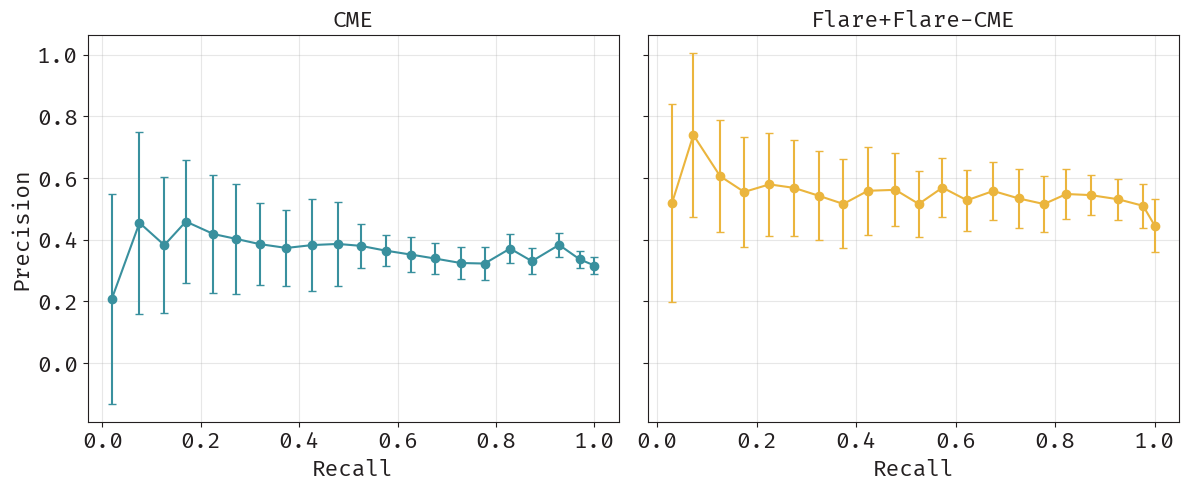

In [51]:
import numpy as np
import matplotlib.pyplot as plt

# Define the forecast types and their titles
types = ["flare_combined", "cme"]
titles = ["CME", "Flare+Flare-CME"]
colors = {"flare_combined": "#39909E", "cme": "#EBB53D"}

# Define global bins for recall
global_bins = np.linspace(0, 1, 21)  # 20 equal-width bins

# Initialize the figure and axes
fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

for ax, ftype, title in zip(axes, types, titles):
    # Filter the data for the current type
    sub_df = pr_df[pr_df["type"] == ftype]
    
    # Bin the recall values globally
    sub_df["recall_bin"] = np.digitize(sub_df["recall"], global_bins) - 1
    
    # Group by bins and calculate median and std for precision
    grouped = sub_df.groupby("recall_bin").agg(
        median_precision=("precision", "median"),
        std_precision=("precision", "std"),
        median_recall=("recall", "median")
    ).reset_index()
    
    # Plot the median precision with error bars
    ax.errorbar(
        grouped["median_recall"], 
        grouped["median_precision"], 
        yerr=grouped["std_precision"], 
        fmt="o-", 
        color=colors[ftype], 
        label=title, 
        capsize=3
    )
    
    # Set plot labels and title
    ax.set_title(title, fontsize=16)
    ax.set_xlabel("Recall", fontsize=16)
    ax.grid(True, alpha=0.3)

# Set the y-axis label for the first plot
axes[0].set_ylabel("Precision", fontsize=16)

# Set the axes and titles to larger fonts
for ax in axes:
    # Increase tick and axis label fontsize to 16
    ax.tick_params(axis='both', labelsize=16)

# Adjust layout and show the plot
plt.tight_layout()
plt.show()


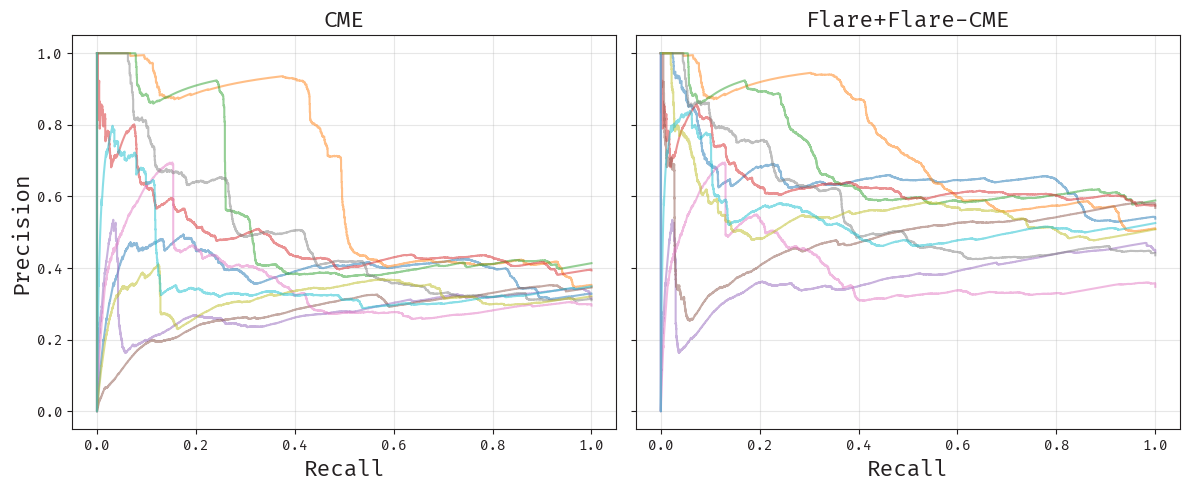

In [52]:
# Now same plot but one line per run_id

# Plot one line per run_id
fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

for ax, ftype, title in zip(axes, types, titles):
    sub_df = pr_df[pr_df["type"] == ftype]
    
    for rid in sub_df["run_id"].unique():
        run_data = sub_df[sub_df["run_id"] == rid]
        ax.plot(run_data["recall"], run_data["precision"], label=f"Run {rid}", alpha=0.5)
    
    ax.set_title(title, fontsize=16)
    ax.set_xlabel("Recall", fontsize=16)
    ax.grid(True, alpha=0.3)

axes[0].set_ylabel("Precision", fontsize=16)

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

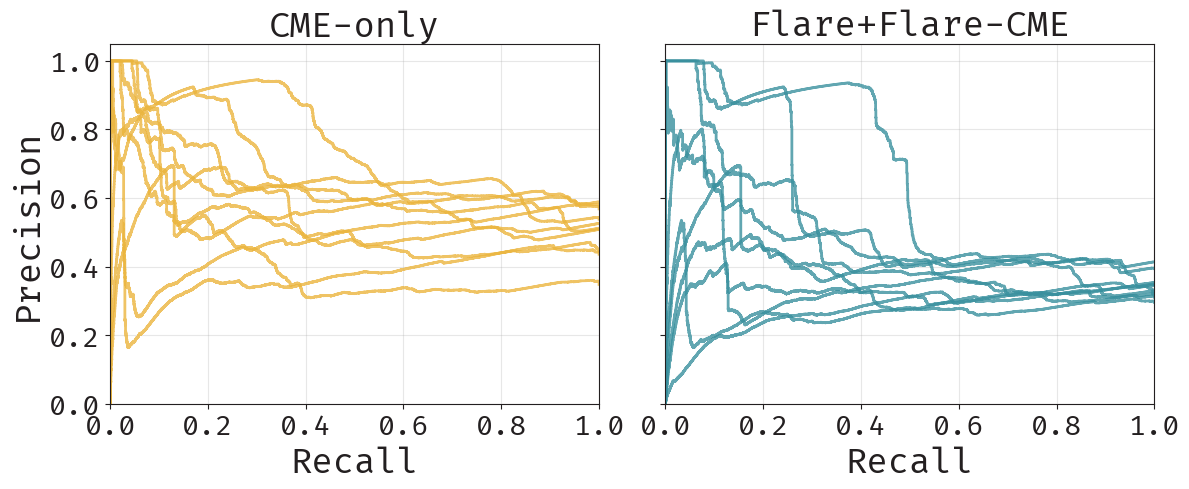

In [65]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve

# -------------------------------------------------
# 1.  Figure skeleton
# -------------------------------------------------
fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

panel_info = [
    ("cme",             "CME-only",           "#EBB53D"),
    ("flare_combined",  "Flare+Flare-CME",  "#39909E"),
]

# -------------------------------------------------
# 2.  One staircase per run_id, nothing else
# -------------------------------------------------
for ax, (ftype, title, colour) in zip(axes, panel_info):
    pcol, tcol = forecast_meta[ftype]

    for rid, g in df_full.groupby("run_id"):
        y_true  = g[tcol].astype(int).to_numpy()
        y_score = g[pcol].fillna(0.0).to_numpy()

        prec, rec, _ = precision_recall_curve(y_true, y_score)
        # sklearn already gives recall in ascending order (0 ➜ 1)
        ax.step(rec, prec, where="post",
                color=colour, alpha=0.8, linewidth=2)

    # Cosmetics
    ax.set_title(title, fontsize=25, pad=6)
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1.05)
    ax.set_xlabel("Recall", fontsize=25)
    ax.grid(alpha=0.3)

    for ax in axes:
        ax.tick_params(axis='both', which='major', labelsize=20)
        ax.xaxis.label.set_size(25)
        ax.yaxis.label.set_size(25)

axes[0].set_ylabel("Precision", fontsize=25)
plt.tight_layout()
plt.savefig("pr_curves.pdf", bbox_inches="tight")
plt.show()



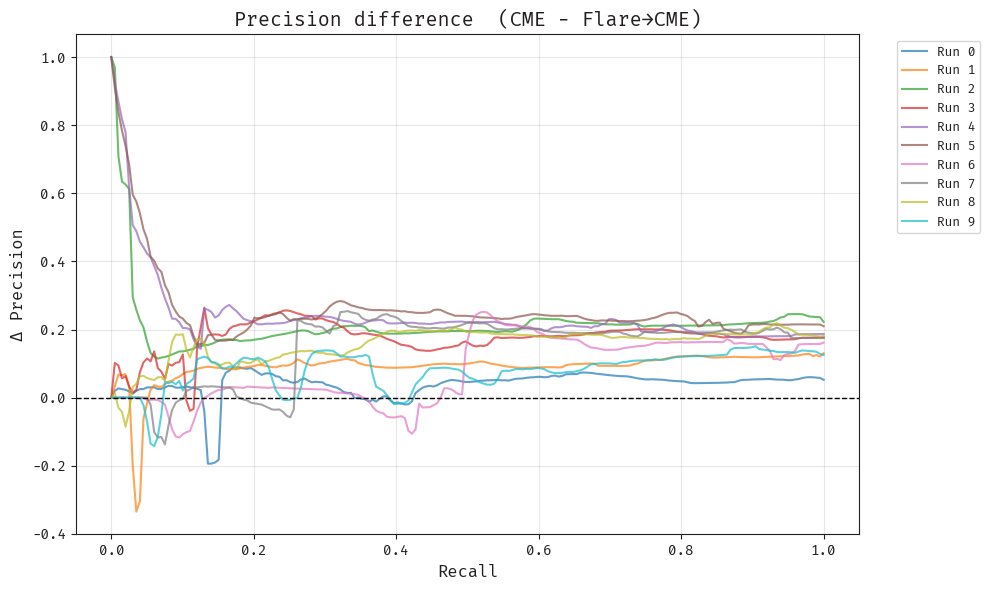

In [110]:
import numpy as np
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 6))

# common recall grid
recall_common = np.linspace(0, 1, 200)

for rid in pr_df["run_id"].unique():
    flare_df = (
        pr_df.query("run_id == @rid and type == 'flare_combined'")
              .sort_values("recall")                   # ⬅️  ensure monotonic
    )
    cme_df   = (
        pr_df.query("run_id == @rid and type == 'cme'")
              .sort_values("recall")
    )

    # interpolate
    flare_p = np.interp(recall_common,
                        flare_df["recall"].values,
                        flare_df["precision"].values)

    cme_p   = np.interp(recall_common,
                        cme_df["recall"].values,
                        cme_df["precision"].values)

    ax.plot(recall_common,
            cme_p - flare_p,
            alpha=0.7,
            label=f"Run {rid}")

# cosmetics
ax.axhline(0, color="black", ls="--", lw=1)
ax.set_title("Precision difference  (CME − Flare→CME)", fontsize=14)
ax.set_xlabel("Recall", fontsize=12)
ax.set_ylabel("Δ Precision", fontsize=12)
ax.grid(alpha=0.3)
ax.legend(bbox_to_anchor=(1.04, 1), loc="upper left", fontsize=9)
plt.tight_layout(); plt.show()


### MCC profile

In [114]:
import numpy as np
import pandas as pd
from sklearn.metrics import matthews_corrcoef
from tqdm import tqdm

# ------------------------------------------------------------------
# 0)  Make sure the gated score is what you want
#     *min of FLARE and FLARE-CME*, NOT cme_pred
# ------------------------------------------------------------------
df_full = data[data["flare_target"] == 1].copy()

df_full["flare_combined_pred"] = np.minimum(
    df_full["flare_pred"].fillna(0.0),
    df_full["flare_cme_pred"].fillna(0.0)   # <-- use flare_cme_pred here
)

# ------------------------------------------------------------------
# 1)  Helper: MCC vs threshold for ONE score vector
# ------------------------------------------------------------------
def mcc_curve(y_true, y_score):
    """Return thresholds (descending) and the corresponding MCC values."""
    thr = np.arange(1.0, -0.01, -0.01)  # thresholds from 1.0 to 0.0
    mcc = []
    for t in thr:
        y_pred = (y_score >= t).astype(int)
        mcc.append(matthews_corrcoef(y_true, y_pred))
    return thr, np.array(mcc)

# ------------------------------------------------------------------
# 2)  Build MCC curves for every run_id and model
# ------------------------------------------------------------------
rows_mcc = []

with tqdm(total=len(df_full["run_id"].unique()), desc="Building MCC curves") as pbar:
    for rid, g in df_full.groupby("run_id"):
        y_true = g["cme_target"].astype(int).to_numpy()

        # CME-only
        thr, mcc = mcc_curve(y_true, g["cme_pred"].fillna(0.0).to_numpy())
        rows_mcc.extend(
            dict(run_id=rid, model="cme", thresh=t, mcc=v)
            for t, v in zip(thr, mcc)
        )

        # Flare → CME (shared threshold)
        thr2, mcc2 = mcc_curve(y_true, g["flare_combined_pred"].to_numpy())
        rows_mcc.extend(
            dict(run_id=rid, model="flare_combined", thresh=t, mcc=v)
            for t, v in zip(thr2, mcc2)
        )

        pbar.update(1)

mcc_df = pd.DataFrame(rows_mcc)
print("Built mcc_df with", len(mcc_df), "rows")


Building MCC curves:   0%|          | 0/10 [00:00<?, ?it/s]

Building MCC curves: 100%|██████████| 10/10 [00:02<00:00,  4.98it/s]

Built mcc_df with 2020 rows


In [128]:
# ------------------------------------------------------------------
# 3)  Summarise each curve:   MCC_max   &   AUC-MCC
# ------------------------------------------------------------------
summ_rows = []

for (rid, mdl), grp in mcc_df.groupby(["run_id", "model"]):
    # sort by threshold (descending) just to be safe
    g = grp.sort_values("thresh")
    thr  = g["thresh"].to_numpy()
    mcc  = g["mcc"].to_numpy()

    mcc_max  = mcc.max()
    auc_mcc  = np.trapz(mcc[::-1], thr[::-1])   # integrate τ=1→0

    summ_rows.append(dict(run_id=rid, model=mdl,
                          mcc_max=mcc_max, auc_mcc=auc_mcc))

mcc_summ = pd.DataFrame(summ_rows)
# Change it so one row per run_id and then columns for each model type and metric. Named e.g. cme_mcc_max, cme_auc_mcc, flare_combined_mcc_max, flare_combined_auc_mcc
mcc_summ = mcc_summ.pivot(index="run_id", columns="model", values=["mcc_max", "auc_mcc"]).reset_index()
mcc_summ.columns = [f"{col[1]}_{col[0]}" for col in mcc_summ.columns]

print("\nMCC summaries  (first few rows)")
print(mcc_summ.head())


MCC summaries  (first few rows)
   _run_id  cme_mcc_max  flare_combined_mcc_max  cme_auc_mcc  \
0        0     0.170510                0.158546    -0.003098   
1        1     0.185684                0.233134     0.027080   
2        2     0.161999                0.184444     0.040363   
3        3     0.132662                0.233499     0.057277   
4        4     0.142256                0.188077     0.038286   

   flare_combined_auc_mcc  
0               -0.013728  
1               -0.085902  
2               -0.040241  
3               -0.030761  
4                0.018790  


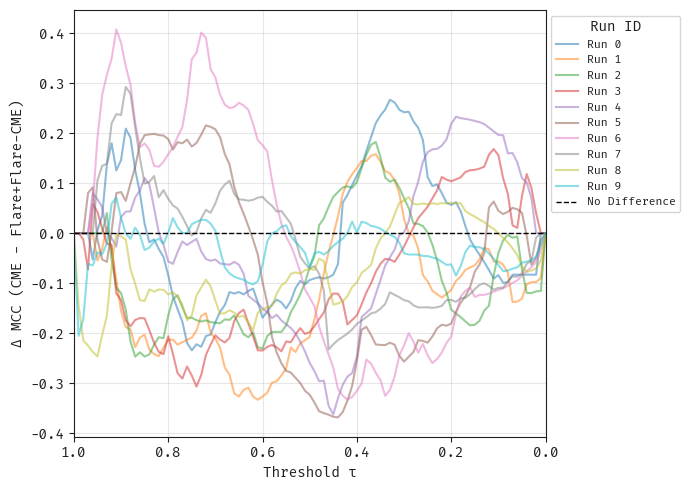

In [118]:
import matplotlib.pyplot as plt

palette = {"cme": "#EBB53D", "flare_combined": "#39909E"}

fig, ax = plt.subplots(figsize=(7, 5))

# Initialize a dictionary to store MCC values for each model
mcc_values = {}

# Loop through each model and calculate MCC values
for model in ["cme", "flare_combined"]:
       mcc_values[model] = {}
       for rid in mcc_df[mcc_df["model"] == model]["run_id"].unique():
              # Filter data for the current model and run_id
              tmp = mcc_df[(mcc_df["model"] == model) & (mcc_df["run_id"] == rid)]
              mcc_values[model][rid] = tmp.set_index("thresh")["mcc"]

# Calculate the difference between the two models for each run_id
for rid in mcc_values["cme"].keys():
       if rid in mcc_values["flare_combined"]:
              # Align thresholds and calculate the difference
              diff = mcc_values["cme"][rid].subtract(mcc_values["flare_combined"][rid], fill_value=0)
              ax.plot(diff.index, diff.values, label=f"Run {rid}", alpha=0.5)

ax.axhline(0, color="black", linestyle="--", linewidth=1, label="No Difference")
ax.set_xlim(1, 0)  # show τ descending left→right
ax.set_xlabel("Threshold τ")
ax.set_ylabel("Δ MCC (CME - Flare+Flare-CME)")
ax.grid(alpha=0.3)
ax.legend(title="Run ID", fontsize=8, loc="upper left", bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.show()


## MCC-F1 curve (https://arxiv.org/pdf/2006.11278)

In [123]:
import numpy as np
import pandas as pd
from sklearn.metrics import matthews_corrcoef, f1_score
from tqdm import tqdm

# -------------------------------------------------------------
# (A)  Ensure the gated score is correct
# -------------------------------------------------------------
df_full = data[data["flare_target"] == 1].copy()

df_full["flare_combined_pred"] = np.minimum(
    df_full["flare_pred"].fillna(0.0),
    df_full["flare_cme_pred"].fillna(0.0)
)

# -------------------------------------------------------------
# (B)  Helper: MCC & F1 vs threshold for ONE score vector
# -------------------------------------------------------------
def mcc_f1_curve(y_true, y_score, thresh_grid):
    mcc, f1 = [], []
    for t in thresh_grid:
        y_pred = (y_score >= t).astype(int)
        mcc.append(matthews_corrcoef(y_true, y_pred))
        f1.append(f1_score(y_true, y_pred))
    return np.array(mcc), np.array(f1)

# Fixed threshold grid (0 → 1, step 0.01)
THR = np.arange(1.0, -0.01, -0.01)   # descending, like sklearn

# -------------------------------------------------------------
# (C)  Build curves for every run_id and model
# -------------------------------------------------------------
rows = []
with tqdm(total=df_full["run_id"].nunique(), desc="Curves") as pbar:
    for rid, g in df_full.groupby("run_id"):
        y = g["cme_target"].astype(int).to_numpy()

        for name, col in [("cme", "cme_pred"),
                          ("flare_combined", "flare_combined_pred")]:

            mcc, f1 = mcc_f1_curve(y, g[col].fillna(0.0).to_numpy(), THR)

            rows.extend(
                dict(run_id=rid, model=name,
                     thresh=t, mcc=v_m, f1=v_f)
                for t, v_m, v_f in zip(THR, mcc, f1)
            )
        pbar.update(1)

curve_df = pd.DataFrame(rows)
print("Built curve_df with", len(curve_df), "rows")


Curves: 100%|██████████| 10/10 [00:04<00:00,  2.23it/s]

Built curve_df with 2020 rows


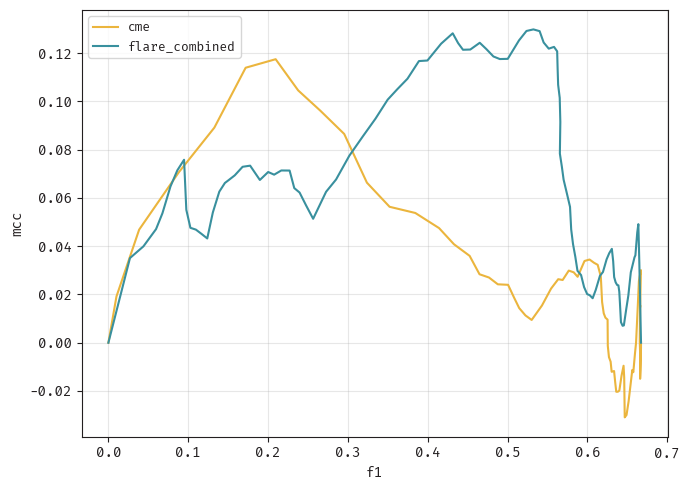

In [127]:
import matplotlib.pyplot as plt
pal = {"cme": "#EBB53D", "flare_combined": "#39909E"}

fig, ax = plt.subplots(figsize=(7, 5))

for mdl in ["cme", "flare_combined"]:
    tmp = (curve_df[curve_df.model == mdl]
           .groupby("thresh")[["mcc", "f1"]].mean()
           .reset_index())
    ax.plot(tmp["f1"], tmp["mcc"],
            "-", color=pal[mdl],
            label=f"{mdl}")

ax.set_xlabel("f1")
ax.set_ylabel("mcc")
ax.grid(alpha=0.3)
ax.legend(fontsize=9)
plt.tight_layout()
plt.show()


In [131]:
import numpy as np
import pandas as pd

# Initialize a list to store the summary rows
summary_rows = []

# Iterate over each run_id and model type
for rid, group in curve_df.groupby("run_id"):
    for model in group["model"].unique():
        # Filter the data for the current run_id and model
        sub_group = group[group["model"] == model]
        
        # Sort by F1 to ensure proper integration
        sub_group = sub_group.sort_values("f1")
        
        # Calculate the area under the MCC-F1 curve using the trapezoidal rule
        auc_mcc_f1 = np.trapz(sub_group["mcc"], sub_group["f1"])
        
        # Append the results to the summary list
        summary_rows.append({"run_id": rid, "model": model, "auc_mcc_f1": auc_mcc_f1})

# Convert the summary list into a DataFrame
mcc_f1_summary_df = pd.DataFrame(summary_rows)

# Pivot just like before
mcc_f1_summary_df = mcc_f1_summary_df.pivot(index="run_id", columns="model", values="auc_mcc_f1").reset_index()
# Rename the columns for clarity
mcc_f1_summary_df.columns = [f"{col}_auc_mcc_f1" if col != "run_id" else col for col in mcc_f1_summary_df.columns]

# Display the summary DataFrame
print(mcc_f1_summary_df)

   run_id  cme_auc_mcc_f1  flare_combined_auc_mcc_f1
0       0        0.026129                   0.021322
1       1       -0.071859                   0.069464
2       2       -0.105257                   0.031544
3       3       -0.008070                   0.042056
4       4        0.024456                   0.046929
5       5        0.090755                   0.104399
6       6        0.165901                   0.020201
7       7        0.081974                   0.030796
8       8        0.054420                   0.123136
9       9        0.084717                   0.094570


100%|██████████| 8000/8000 [01:01<00:00, 130.63it/s]


P(Model A better)  = 0.802
95% HDI for μ      = [-0.0405, 0.0890]
Posterior mean σ   = 0.0934
Posterior median ν = 22.4


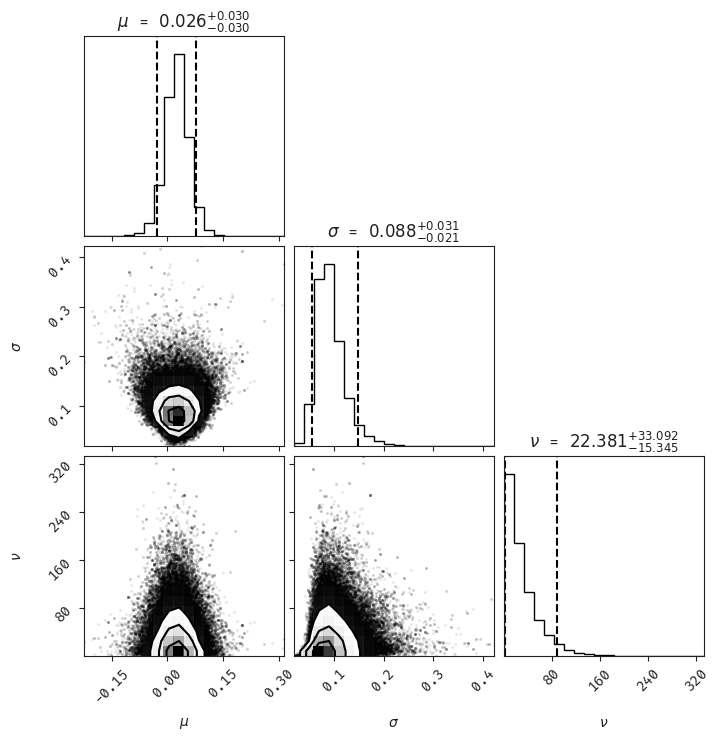

In [132]:

import numpy as np
import emcee
from scipy.special import gammaln
import corner, matplotlib.pyplot as plt

# ------------------------------------------------------------------
# DATA  – paired APP differences
# ------------------------------------------------------------------
# Get the AP of each run_id and type

diffs = mcc_f1_summary_df["flare_combined_auc_mcc_f1"] - mcc_f1_summary_df["cme_auc_mcc_f1"]
N = len(diffs)

# ------------------------------------------------------------------
# Student-t log-pdf
# ------------------------------------------------------------------
def student_t_logpdf(x, loc, scale, df):
    z = (x - loc) / scale
    return (
        gammaln((df + 1) / 2) - gammaln(df / 2)
        - 0.5 * np.log(df * np.pi) - np.log(scale)
        - (df + 1) / 2 * np.log1p(z**2 / df)
    )

# ------------------------------------------------------------------
# Prior hyper-params
# ------------------------------------------------------------------
SIGMA_HIGH = 4.0     # Uniform(0,H) upper bound

# ------------------------------------------------------------------
# LOG-PRIOR
# ------------------------------------------------------------------
def log_prior(theta):
    mu, log_sigma, log_nu_minus_one = theta

    sigma        = np.exp(log_sigma)
    nu_minus_one = np.exp(log_nu_minus_one)
    nu           = nu_minus_one + 1.0

    # support
    if not (-2 < mu < 2):
        return -np.inf
    if not (0 < sigma < SIGMA_HIGH):
        return -np.inf
    if not (-6 < log_nu_minus_one < 6):
        return -np.inf

    lp  = -0.5 * mu**2 - 0.5 * np.log(2*np.pi)        # μ ~ N(0,1)

    # Uniform(0,H) on σ  ⇒  log pdf = −log H + log σ
    lp += -np.log(SIGMA_HIGH) + log_sigma

    # ν−1 ~ Exp(1/29)  +  Jacobian for log
    lambda_rate = 1/29
    lp += -lambda_rate * nu_minus_one + log_nu_minus_one
    return lp

# ------------------------------------------------------------------
# LOG-LIKELIHOOD
# ------------------------------------------------------------------
def log_likelihood(theta, data):
    mu, log_sigma, log_nu_minus_one = theta
    sigma = np.exp(log_sigma)
    nu    = np.exp(log_nu_minus_one) + 1.0
    return np.sum(student_t_logpdf(data, loc=mu, scale=sigma, df=nu))

# ------------------------------------------------------------------
# LOG-POSTERIOR
# ------------------------------------------------------------------
def log_posterior(theta, data):
    lp = log_prior(theta)
    return lp + log_likelihood(theta, data) if np.isfinite(lp) else -np.inf

# ------------------------------------------------------------------
# MCMC setup
# ------------------------------------------------------------------
ndim      = 3                   # μ, log σ, log(ν−1)
n_walkers = 10 * ndim
rng       = np.random.default_rng(42)

init = np.column_stack([
    rng.normal(0.0, 0.2,  n_walkers),   # μ
    rng.normal(-1.0, 0.2, n_walkers),   # log σ
    rng.normal( 1.0, 0.2, n_walkers),   # log(ν−1)
])

sampler = emcee.EnsembleSampler(n_walkers, ndim,
                                log_posterior, args=(diffs,))
sampler.run_mcmc(init, 2000, progress=True)  # burn-in
sampler.reset()
sampler.run_mcmc(None, 8000, progress=True)  # posterior

flat = sampler.get_chain(flat=True)
mu_samples     = flat[:, 0]
sigma_samples  = np.exp(flat[:, 1])
nu_samples     = np.exp(flat[:, 2]) + 1.0

# ------------------------------------------------------------------
# Posterior summaries
# ------------------------------------------------------------------
p_better = (mu_samples > 0).mean()
hdi_low, hdi_high = np.percentile(mu_samples, [2.5, 97.5])
print(f"P(Model A better)  = {p_better:.3f}")
print(f"95% HDI for μ      = [{hdi_low:.4f}, {hdi_high:.4f}]")
print(f"Posterior mean σ   = {sigma_samples.mean():.4f}")
print(f"Posterior median ν = {np.median(nu_samples):.1f}")

# ------------------------------------------------------------------
# Corner plot
# ------------------------------------------------------------------
corner.corner(np.column_stack([mu_samples, sigma_samples, nu_samples]),
              labels=[r"$\mu$", r"$\sigma$", r"$\nu$"],
              quantiles=[0.05, 0.95],
              show_titles=True, title_fmt=".3f")
plt.show()


100%|██████████| 8000/8000 [01:03<00:00, 126.44it/s]


P(Model A better)  = 0.730
95% HDI for μ      = [-0.0400, 0.0711]
Posterior mean σ   = 0.0807
Posterior median ν = 23.0


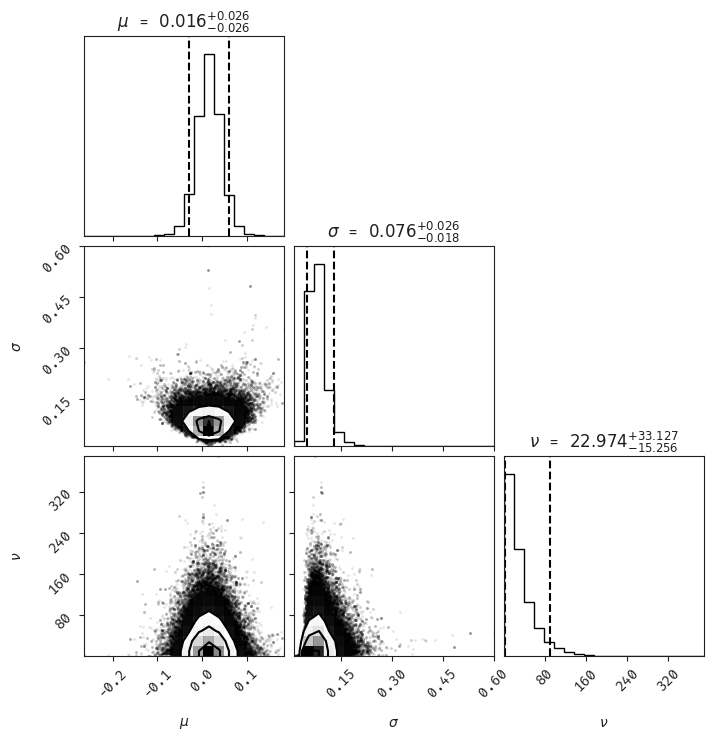

In [133]:


import numpy as np
import emcee
from scipy.special import gammaln
import corner, matplotlib.pyplot as plt

# ------------------------------------------------------------------
# DATA  – paired APP differences
# ------------------------------------------------------------------
# Get the AP of each run_id and type

diffs = mcc_summ["flare_combined_mcc_max"] - mcc_summ["cme_mcc_max"]
N = len(diffs)

# ------------------------------------------------------------------
# Student-t log-pdf
# ------------------------------------------------------------------
def student_t_logpdf(x, loc, scale, df):
    z = (x - loc) / scale
    return (
        gammaln((df + 1) / 2) - gammaln(df / 2)
        - 0.5 * np.log(df * np.pi) - np.log(scale)
        - (df + 1) / 2 * np.log1p(z**2 / df)
    )

# ------------------------------------------------------------------
# Prior hyper-params
# ------------------------------------------------------------------
SIGMA_HIGH = 4.0     # Uniform(0,H) upper bound

# ------------------------------------------------------------------
# LOG-PRIOR
# ------------------------------------------------------------------
def log_prior(theta):
    mu, log_sigma, log_nu_minus_one = theta

    sigma        = np.exp(log_sigma)
    nu_minus_one = np.exp(log_nu_minus_one)
    nu           = nu_minus_one + 1.0

    # support
    if not (-2 < mu < 2):
        return -np.inf
    if not (0 < sigma < SIGMA_HIGH):
        return -np.inf
    if not (-6 < log_nu_minus_one < 6):
        return -np.inf

    lp  = -0.5 * mu**2 - 0.5 * np.log(2*np.pi)        # μ ~ N(0,1)

    # Uniform(0,H) on σ  ⇒  log pdf = −log H + log σ
    lp += -np.log(SIGMA_HIGH) + log_sigma

    # ν−1 ~ Exp(1/29)  +  Jacobian for log
    lambda_rate = 1/29
    lp += -lambda_rate * nu_minus_one + log_nu_minus_one
    return lp

# ------------------------------------------------------------------
# LOG-LIKELIHOOD
# ------------------------------------------------------------------
def log_likelihood(theta, data):
    mu, log_sigma, log_nu_minus_one = theta
    sigma = np.exp(log_sigma)
    nu    = np.exp(log_nu_minus_one) + 1.0
    return np.sum(student_t_logpdf(data, loc=mu, scale=sigma, df=nu))

# ------------------------------------------------------------------
# LOG-POSTERIOR
# ------------------------------------------------------------------
def log_posterior(theta, data):
    lp = log_prior(theta)
    return lp + log_likelihood(theta, data) if np.isfinite(lp) else -np.inf

# ------------------------------------------------------------------
# MCMC setup
# ------------------------------------------------------------------
ndim      = 3                   # μ, log σ, log(ν−1)
n_walkers = 10 * ndim
rng       = np.random.default_rng(42)

init = np.column_stack([
    rng.normal(0.0, 0.2,  n_walkers),   # μ
    rng.normal(-1.0, 0.2, n_walkers),   # log σ
    rng.normal( 1.0, 0.2, n_walkers),   # log(ν−1)
])

sampler = emcee.EnsembleSampler(n_walkers, ndim,
                                log_posterior, args=(diffs,))
sampler.run_mcmc(init, 2000, progress=True)  # burn-in
sampler.reset()
sampler.run_mcmc(None, 8000, progress=True)  # posterior

flat = sampler.get_chain(flat=True)
mu_samples     = flat[:, 0]
sigma_samples  = np.exp(flat[:, 1])
nu_samples     = np.exp(flat[:, 2]) + 1.0

# ------------------------------------------------------------------
# Posterior summaries
# ------------------------------------------------------------------
p_better = (mu_samples > 0).mean()
hdi_low, hdi_high = np.percentile(mu_samples, [2.5, 97.5])
print(f"P(Model A better)  = {p_better:.3f}")
print(f"95% HDI for μ      = [{hdi_low:.4f}, {hdi_high:.4f}]")
print(f"Posterior mean σ   = {sigma_samples.mean():.4f}")
print(f"Posterior median ν = {np.median(nu_samples):.1f}")

# ------------------------------------------------------------------
# Corner plot
# ------------------------------------------------------------------
corner.corner(np.column_stack([mu_samples, sigma_samples, nu_samples]),
              labels=[r"$\mu$", r"$\sigma$", r"$\nu$"],
              quantiles=[0.05, 0.95],
              show_titles=True, title_fmt=".3f")
plt.show()


100%|██████████| 8000/8000 [01:02<00:00, 127.02it/s]


P(Model A better)  = 0.002
95% HDI for μ      = [-0.0802, -0.0215]
Posterior mean σ   = 0.0431
Posterior median ν = 25.7


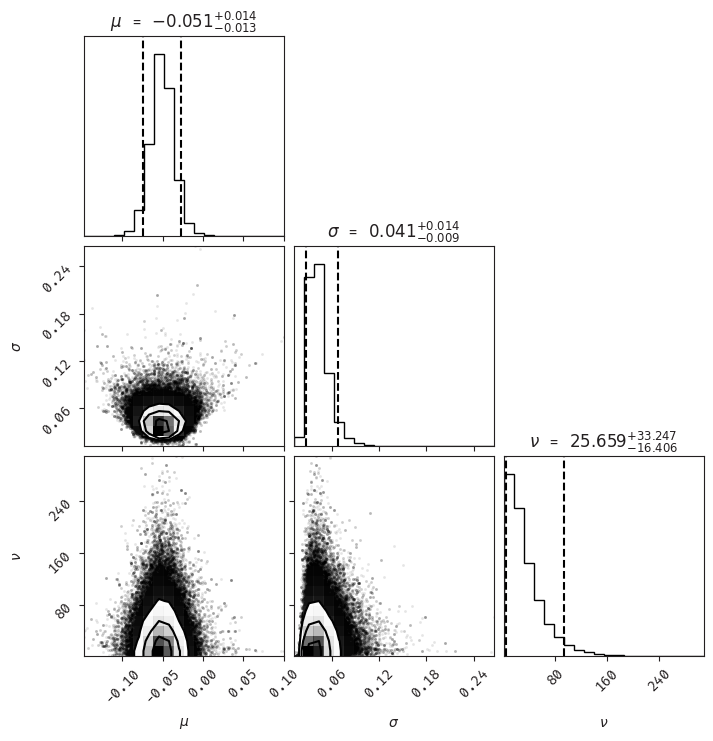

In [134]:
import numpy as np
import emcee
from scipy.special import gammaln
import corner, matplotlib.pyplot as plt

# ------------------------------------------------------------------
# DATA  – paired APP differences
# ------------------------------------------------------------------
# Get the AP of each run_id and type

diffs = mcc_summ["flare_combined_auc_mcc"] - mcc_summ["cme_auc_mcc"]
N = len(diffs)

# ------------------------------------------------------------------
# Student-t log-pdf
# ------------------------------------------------------------------
def student_t_logpdf(x, loc, scale, df):
    z = (x - loc) / scale
    return (
        gammaln((df + 1) / 2) - gammaln(df / 2)
        - 0.5 * np.log(df * np.pi) - np.log(scale)
        - (df + 1) / 2 * np.log1p(z**2 / df)
    )

# ------------------------------------------------------------------
# Prior hyper-params
# ------------------------------------------------------------------
SIGMA_HIGH = 4.0     # Uniform(0,H) upper bound

# ------------------------------------------------------------------
# LOG-PRIOR
# ------------------------------------------------------------------
def log_prior(theta):
    mu, log_sigma, log_nu_minus_one = theta

    sigma        = np.exp(log_sigma)
    nu_minus_one = np.exp(log_nu_minus_one)
    nu           = nu_minus_one + 1.0

    # support
    if not (-2 < mu < 2):
        return -np.inf
    if not (0 < sigma < SIGMA_HIGH):
        return -np.inf
    if not (-6 < log_nu_minus_one < 6):
        return -np.inf

    lp  = -0.5 * mu**2 - 0.5 * np.log(2*np.pi)        # μ ~ N(0,1)

    # Uniform(0,H) on σ  ⇒  log pdf = −log H + log σ
    lp += -np.log(SIGMA_HIGH) + log_sigma

    # ν−1 ~ Exp(1/29)  +  Jacobian for log
    lambda_rate = 1/29
    lp += -lambda_rate * nu_minus_one + log_nu_minus_one
    return lp

# ------------------------------------------------------------------
# LOG-LIKELIHOOD
# ------------------------------------------------------------------
def log_likelihood(theta, data):
    mu, log_sigma, log_nu_minus_one = theta
    sigma = np.exp(log_sigma)
    nu    = np.exp(log_nu_minus_one) + 1.0
    return np.sum(student_t_logpdf(data, loc=mu, scale=sigma, df=nu))

# ------------------------------------------------------------------
# LOG-POSTERIOR
# ------------------------------------------------------------------
def log_posterior(theta, data):
    lp = log_prior(theta)
    return lp + log_likelihood(theta, data) if np.isfinite(lp) else -np.inf

# ------------------------------------------------------------------
# MCMC setup
# ------------------------------------------------------------------
ndim      = 3                   # μ, log σ, log(ν−1)
n_walkers = 10 * ndim
rng       = np.random.default_rng(42)

init = np.column_stack([
    rng.normal(0.0, 0.2,  n_walkers),   # μ
    rng.normal(-1.0, 0.2, n_walkers),   # log σ
    rng.normal( 1.0, 0.2, n_walkers),   # log(ν−1)
])

sampler = emcee.EnsembleSampler(n_walkers, ndim,
                                log_posterior, args=(diffs,))
sampler.run_mcmc(init, 2000, progress=True)  # burn-in
sampler.reset()
sampler.run_mcmc(None, 8000, progress=True)  # posterior

flat = sampler.get_chain(flat=True)
mu_samples     = flat[:, 0]
sigma_samples  = np.exp(flat[:, 1])
nu_samples     = np.exp(flat[:, 2]) + 1.0

# ------------------------------------------------------------------
# Posterior summaries
# ------------------------------------------------------------------
p_better = (mu_samples > 0).mean()
hdi_low, hdi_high = np.percentile(mu_samples, [2.5, 97.5])
print(f"P(Model A better)  = {p_better:.3f}")
print(f"95% HDI for μ      = [{hdi_low:.4f}, {hdi_high:.4f}]")
print(f"Posterior mean σ   = {sigma_samples.mean():.4f}")
print(f"Posterior median ν = {np.median(nu_samples):.1f}")

# ------------------------------------------------------------------
# Corner plot
# ------------------------------------------------------------------
corner.corner(np.column_stack([mu_samples, sigma_samples, nu_samples]),
              labels=[r"$\mu$", r"$\sigma$", r"$\nu$"],
              quantiles=[0.05, 0.95],
              show_titles=True, title_fmt=".3f")
plt.show()


100%|██████████| 8000/8000 [01:04<00:00, 124.68it/s]


P(Model A better)  = 0.000
95% HDI for μ      = [-0.2052, -0.0895]
Posterior mean σ   = 0.0847
Posterior median ν = 25.6


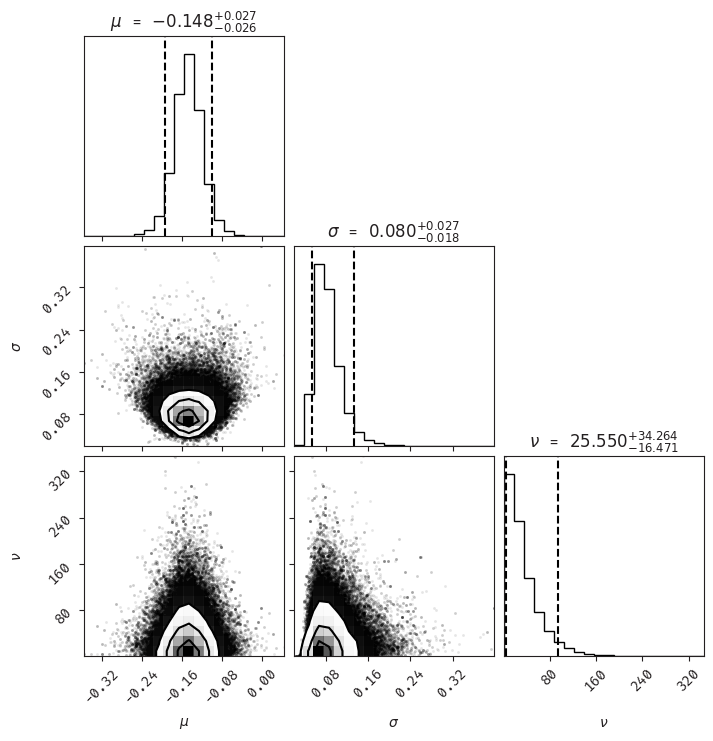

In [135]:

import numpy as np
import emcee
from scipy.special import gammaln
import corner, matplotlib.pyplot as plt

# ------------------------------------------------------------------
# DATA  – paired APP differences
# ------------------------------------------------------------------
# Get the AP of each run_id and type

diffs = ap_df["flare_combined"] - ap_df["cme"]
N = len(diffs)

# ------------------------------------------------------------------
# Student-t log-pdf
# ------------------------------------------------------------------
def student_t_logpdf(x, loc, scale, df):
    z = (x - loc) / scale
    return (
        gammaln((df + 1) / 2) - gammaln(df / 2)
        - 0.5 * np.log(df * np.pi) - np.log(scale)
        - (df + 1) / 2 * np.log1p(z**2 / df)
    )

# ------------------------------------------------------------------
# Prior hyper-params
# ------------------------------------------------------------------
SIGMA_HIGH = 4.0     # Uniform(0,H) upper bound

# ------------------------------------------------------------------
# LOG-PRIOR
# ------------------------------------------------------------------
def log_prior(theta):
    mu, log_sigma, log_nu_minus_one = theta

    sigma        = np.exp(log_sigma)
    nu_minus_one = np.exp(log_nu_minus_one)
    nu           = nu_minus_one + 1.0

    # support
    if not (-2 < mu < 2):
        return -np.inf
    if not (0 < sigma < SIGMA_HIGH):
        return -np.inf
    if not (-6 < log_nu_minus_one < 6):
        return -np.inf

    lp  = -0.5 * mu**2 - 0.5 * np.log(2*np.pi)        # μ ~ N(0,1)

    # Uniform(0,H) on σ  ⇒  log pdf = −log H + log σ
    lp += -np.log(SIGMA_HIGH) + log_sigma

    # ν−1 ~ Exp(1/29)  +  Jacobian for log
    lambda_rate = 1/29
    lp += -lambda_rate * nu_minus_one + log_nu_minus_one
    return lp

# ------------------------------------------------------------------
# LOG-LIKELIHOOD
# ------------------------------------------------------------------
def log_likelihood(theta, data):
    mu, log_sigma, log_nu_minus_one = theta
    sigma = np.exp(log_sigma)
    nu    = np.exp(log_nu_minus_one) + 1.0
    return np.sum(student_t_logpdf(data, loc=mu, scale=sigma, df=nu))

# ------------------------------------------------------------------
# LOG-POSTERIOR
# ------------------------------------------------------------------
def log_posterior(theta, data):
    lp = log_prior(theta)
    return lp + log_likelihood(theta, data) if np.isfinite(lp) else -np.inf

# ------------------------------------------------------------------
# MCMC setup
# ------------------------------------------------------------------
ndim      = 3                   # μ, log σ, log(ν−1)
n_walkers = 10 * ndim
rng       = np.random.default_rng(42)

init = np.column_stack([
    rng.normal(0.0, 0.2,  n_walkers),   # μ
    rng.normal(-1.0, 0.2, n_walkers),   # log σ
    rng.normal( 1.0, 0.2, n_walkers),   # log(ν−1)
])

sampler = emcee.EnsembleSampler(n_walkers, ndim,
                                log_posterior, args=(diffs,))
sampler.run_mcmc(init, 2000, progress=True)  # burn-in
sampler.reset()
sampler.run_mcmc(None, 8000, progress=True)  # posterior

flat = sampler.get_chain(flat=True)
mu_samples     = flat[:, 0]
sigma_samples  = np.exp(flat[:, 1])
nu_samples     = np.exp(flat[:, 2]) + 1.0

# ------------------------------------------------------------------
# Posterior summaries
# ------------------------------------------------------------------
p_better = (mu_samples > 0).mean()
hdi_low, hdi_high = np.percentile(mu_samples, [2.5, 97.5])
print(f"P(Model A better)  = {p_better:.3f}")
print(f"95% HDI for μ      = [{hdi_low:.4f}, {hdi_high:.4f}]")
print(f"Posterior mean σ   = {sigma_samples.mean():.4f}")
print(f"Posterior median ν = {np.median(nu_samples):.1f}")

# ------------------------------------------------------------------
# Corner plot
# ------------------------------------------------------------------
corner.corner(np.column_stack([mu_samples, sigma_samples, nu_samples]),
              labels=[r"$\mu$", r"$\sigma$", r"$\nu$"],
              quantiles=[0.05, 0.95],
              show_titles=True, title_fmt=".3f")
plt.show()
